In [2]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter, namedtuple
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce, partial
import dataclasses
from dataclasses import dataclass

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

# sys.path.insert(0, '/nas/xd/projects/transformers/src')
from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers.models.gpt_neo.modeling_gpt_neo import GPTNeoSelfAttention
from transformers.models.gptj.modeling_gptj import GPTJAttention, GPTJBlock
from transformers.models.xglm.modeling_xglm import XGLMAttention

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
# from transformers.trainer_utils import EvaluationStrategy

In file_utils.py: default_cache_path = /raid/xd/.cache/torch/transformers


In [5]:

from collections.abc import Iterable

In [6]:
import einops
from einops import rearrange

In [7]:
# from child_utils import *
from common_utils import *
from child_tasks import *
from model_utils import *
from utils import *

In [8]:
from model_utils import *

In [9]:
sys.path.insert(0, '/nas/xd/projects/pptree')
from pptree import Node, print_tree

In [10]:
models = {}
# cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b

cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 


In [11]:
# model_name = "EleutherAI/gpt-neo-1.3B"
for model_name in [  'EleutherAI/gpt-j-6B']:
    if model_name not in models:
        with Timer(model_name):
            model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir)  
            tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
            models[model_name] = model, tokenizer

EleutherAI/gpt-j-6B ... done 0:02:27.157094


In [12]:
# model_name = 'gpt2-large'  # medium / large /xl
model_name = 'EleutherAI/gpt-j-6B' # gpt-j-6B, gpt-neo-1.3B/2.7B
model, tokenizer = models[model_name]
_ = model.eval()

masked_lm = tokenizer.mask_token is not None and len(tokenizer.additional_special_tokens) == 0
if masked_lm:
    mask_token = tokenizer.mask_token  # '<mask>' for roberta
elif len(tokenizer.additional_special_tokens) > 0:
    mask_token = tokenizer.additional_special_tokens[0]  # '<extra_id_0>' for t5
else:
    mask_token = ''  # for gpt2
if masked_lm: nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k=5)

Using mask_token, but it is not set yet.


In [1]:
models.keys()

NameError: name 'models' is not defined

In [14]:
unify(model)
blocks = model.transformer.h
attn = blocks[0].attn
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), attn.num_heads, attn.embed_dim
we = model.transformer.wte.weight.data.t()
# wp = model.transformer.wpe.weight.t()
wu = model.lm_head.weight.data

In [15]:
L,H

(28, 16)

In [16]:
embed_dim

4096

In [15]:
def forward(model, inputs, labels=None, loss_reduction=None, by_head=False, attribute_layer=None, 
            head_mask=None, mlp_mask=None, attn_weights=None,
            hidden_states=None, detach_layer=None,
            special_head=(None, None), special_head_multiplier=1, #wv=None, wo=None, 
            multiplied_layers=[], attr_threshold=1., base_multiplier=1.5, test = False):
    head_mask = fill_list(head_mask, L, attribute_layer)
    mlp_mask = fill_list(mlp_mask, L, attribute_layer)
    attn_weights = fill_list(attn_weights, L, attribute_layer)
    from_layer = attribute_layer if hidden_states is not None else None

    self = model.transformer
    (hidden_states, inputs_embeds, position_embeds) = embed_forward(self, inputs) \
        if from_layer is None else (hidden_states, None, None)
    all_hidden_states, intermediates, mlp_outputs = (), (), ()
    attn_fwd_outputs = [] #lxy
    # hq_extra = None
    special_head_outputs = None
    for i, b in enumerate(self.h):
        if from_layer is not None and i < from_layer: continue
        if i == detach_layer: hidden_states = hidden_states.detach()
        all_hidden_states += (hidden_states,)
        hq = hk = hv = b.ln_1(hidden_states)
        # if hq_extra is not None: hq = b.ln_1(hidden_states + hq_extra)
        attn_fwd_output = attn_forward(b, hq, hk, hv, by_head=by_head or i in multiplied_layers or i == special_head[0],
                            compute_head_input=True, head_mask=head_mask[i], attn_weights=attn_weights[i])
        attn_fwd_outputs.append(attn_fwd_output) #lxy
        attn_output, aw, head_input, head_output = attn_fwd_output
        if i == special_head[0]:
            head_output = list(rearrange(head_output, 'b n i e -> n b i e'))  # nbie->n*bie
            # hq_extra = aw[:, special_head[1]] @ (hv @ wv @ wo) # bnij->bij,bje->bie
            # attn_output = attn_output + hq_extra
            head_output[special_head[1]] = head_output[special_head[1]] * special_head_multiplier
            special_head_outputs = torch.cat([special_head_outputs, head_output[special_head[1]]]) \
                if special_head_outputs is not None else head_output[special_head[1]] # sie, s in [1, 2] for 8-1, 12-10
            attn_output = sum(head_output)
        if i in multiplied_layers:
            multiplier = get_multiplier(b, hidden_states, aw, head_input, special_head_outputs, labels, L, H,
                attr_threshold=attr_threshold, base_multiplier=base_multiplier)
            attn_output = torch.einsum('bnie,ni->bie', head_output, multiplier)
        if not my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_output
        mlp_output, intermediate = mlp_forward(b, hidden_states, output_intermediate=True)
        if mlp_mask[i] is not None: mlp_output = einsum('bie,bi->bie', mlp_output, mlp_mask[i])
        intermediates += (intermediate,)
        mlp_outputs += (mlp_output,)
        if my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_output
        hidden_states = hidden_states + mlp_output
    attn_outputs, all_attentions, head_inputs, head_outputs = zip(*attn_fwd_outputs) #lxy
    all_hidden_states += (hidden_states,) # both before and after ln_f
    hidden_states = self.ln_f(hidden_states)
    all_hidden_states += (hidden_states,)

    logits = model.lm_head(hidden_states)
    loss = compute_loss(logits, labels, reduction=loss_reduction) if labels is not None else None
    if test:
        return Outputs(hidden_states = all_hidden_states, logits = logits)
    else:
        return Outputs(
            inputs_embeds=inputs_embeds, position_embeds=position_embeds,
            attn_outputs=attn_outputs, head_inputs=head_inputs, head_outputs=head_outputs, 
            intermediates=intermediates, mlp_outputs=mlp_outputs,
            hidden_states=all_hidden_states, attentions=all_attentions, 
            logits=logits, loss=loss,
        )

In [16]:
def get_multiplier(block, hidden_states, attentions, head_input, special_head_output, labels, L, H, attr_threshold=1, base_multiplier=1.5, verbose=False):
    # mask = torch.ones(1, H, L, H + 2, outputs.cat_hidden_states.size(-2)); mask[:, :, layer:] = 0 # bnloi
    # x = {'mask': mask}
    
    # special_head_output: sie
    x = {'mask': torch.ones(1, H, special_head_output.size(0) + 1, special_head_output.size(-2))}  # bnpi
#     print(special_head_output.shape) #torch.Size([1, 62, 4096])

#     print(x['mask'].shape) # torch.Size([1, 16, 2, 62])
#     print(head_input.shape)
    attn_labels = torch.einsum('bnij,bnj->bnij', attentions, head_input.norm(dim=-1)) # bnje->bnj
    # attn_labels = attn_labels / attn_labels.sum(-1, keepdim=True)  # bnij->bni1 
    fwd_fn = partial(cat_attn_forward, cat_hidden_states=special_head_output, #outputs.cat_hidden_states, 
                sum_hidden_states=hidden_states, attn_labels=attn_labels)
    attr, ys, logits = _attribute(fwd_fn, block, x, num_points=3)
    # print(ys)

    a = attr['mask']  # nloi, nsi
    # a2 = torch.add(a[:, 8, 1, :]*0, a[:, 12, 10, :]) # ni
    a2 = a[:, -1, :]  # ni

    labels_mask = (labels != -100).squeeze(0)#.fill_(1)
    multiplier_mask = (a2 >= attr_threshold) * labels_mask
    if verbose and multiplier_mask.sum() > 0:
        for head in range(H):
            n_multiplied = multiplier_mask[head].sum()
            if n_multiplied > 0:
                print(f'{layer}-{head}', n_multiplied, (a2 * labels_mask)[head].topk(min(a2.size(1), n_multiplied + 1)))
    return base_multiplier * multiplier_mask + 1 * ~multiplier_mask

In [41]:
def test(model, samples, verbose=False, k_shot = 4, **kwargs):
    data_tuples = []
    losses0 = []
    accuracy0 = []
    losses2 = []
    accuracy2 = []
    for i, text in enumerate(tqdm(samples)):
        print(f'----i={i}---- begin')
        bos_token, eos_token ='Ġ->', 'Ċ'
    #     bos_token, eos_token ='->', 'Ċ
        examples = text.strip().split('\n')
        inputs = tokenizer.encode_plus(text, return_tensors='pt')
        input_ids = inputs.input_ids
        tokens = tokenizer.tokenize(text)
        tokens = list(map(tokenizer.convert_tokens_to_string, map(lambda x: [x], tokens))) 
        bos_indices, eos_indices, answers, labels = locate_answers(input_ids, tokenizer, bos_token=bos_token, eos_token=eos_token)
        labels[:, :bos_indices[k_shot]] = -100  # 只算k_shot个示例后的loss
        with torch.no_grad():
            o = forward(model, inputs, labels=labels, by_head=False, test =True)
    #         data_tuples.append([text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o])    
        loss, all_top1_correct = show_predictions(text, examples, tokenizer, o.logits, bos_indices, eos_indices, answers, labels, 
                    topk=3, loss_reduction='none', show_range=range(k_shot, len(examples)), sep='\t', verbose=verbose)
        losses0.append(loss[loss!=0.0].view(1,-1))
        accuracy0.append(torch.tensor(all_top1_correct).view(1,-1))
        print('\n')
        from_layer, _ = kwargs['special_head']  # 12
        hidden_states = o.hidden_states[from_layer]
        with torch.no_grad():
            o2 = forward(model, inputs, labels=labels, attribute_layer=from_layer, hidden_states=hidden_states, test= True, **kwargs)
        loss2, all_top1_correct2 = show_predictions(text, examples, tokenizer, o2.logits, bos_indices, eos_indices, answers, labels, 
            topk=3, loss_reduction='none', show_range=range(k_shot, len(examples)), sep='\t', verbose=verbose)
        losses2.append(loss2[loss2!=0.0].view(1,-1))
        accuracy2.append(torch.tensor(all_top1_correct2).view(1,-1))
        del o
        del o2
        print(f'----i={i}---- end')
    losses0 = torch.cat(losses0)
    accuracy0 = torch.cat(accuracy0)
    losses2 = torch.cat(losses2)
    accuracy2 = torch.cat(accuracy2)
    print('激活前loss =',losses0.mean(0))
    print('激活前准确率 =',accuracy0.float().mean(0))
    print('激活后loss =',losses2.mean(0))
    print('激活后准确率 =',accuracy2.float().mean(0))

In [42]:
from model_utils import _attribute
from lxy.utils import  *
samples = readfileSST2('/nas/xd/projects/transformers/notebooks/data/SST-2/train.tsv',25)
# print(samples[0])

In [ ]:
b

In [44]:
samples = readfileSST2('/nas/xd/projects/transformers/notebooks/data/SST-2/train.tsv',25)

In [45]:
test(model, samples, special_head=(12, 10), special_head_multiplier=3.,
    multiplied_layers=range(13, L), attr_threshold=5., base_multiplier=1.5, verbose=True)

  0%|          | 0/25 [00:00<?, ?it/s]

----i=0---- begin
* True 0.672 {' True': 0.672, ' False': 0.292, ' Yes': 0.006} 	  is attractive . -> True
* True 0.748 {' True': 0.748, ' False': 0.221, ' ': 0.003} 	  recognize that there are few things in this world more complex -- and , as it turns out , more fragile -> True
* False 0.676 {' False': 0.676, ' True': 0.255, ' Not': 0.003} 	  seeking to pull a cohesive story out -> False
* False 0.679 {' False': 0.679, ' True': 0.304, 'False': 0.002} 	  should be doing a lot of things , but does n't . -> False




  4%|▍         | 1/25 [00:06<02:39,  6.65s/it]

* True 0.714 {' True': 0.714, ' False': 0.259, 'True': 0.004} 	  is attractive . -> True
* True 0.755 {' True': 0.755, ' False': 0.22, 'True': 0.003} 	  recognize that there are few things in this world more complex -- and , as it turns out , more fragile -> True
* False 0.726 {' False': 0.726, ' True': 0.228, ' Failed': 0.003} 	  seeking to pull a cohesive story out -> False
* False 0.7 {' False': 0.7, ' True': 0.281, 'False': 0.002} 	  should be doing a lot of things , but does n't . -> False
----i=0---- end
----i=1---- begin
  False 0.478 {' True': 0.493, ' False': 0.478, ' ': 0.003} 	  stop watching -> False
* False 0.672 {' False': 0.672, ' True': 0.303, ' ': 0.003} 	  such a fine idea for a film , and such a stultifying , lifeless execution . -> False
* True 0.605 {' True': 0.605, ' False': 0.311, ' ': 0.005} 	  with drama , romance , tragedy , bravery , political intrigue , partisans and sabotage -> True
* True 0.574 {' True': 0.574, ' False': 0.397, ' Yes': 0.002} 	  good yarn 

  8%|▊         | 2/25 [00:12<02:18,  6.04s/it]

  False 0.369 {' True': 0.611, ' False': 0.369, ' ': 0.001} 	  stop watching -> False
* False 0.628 {' False': 0.628, ' True': 0.343, ' ': 0.002} 	  such a fine idea for a film , and such a stultifying , lifeless execution . -> False
* True 0.614 {' True': 0.614, ' False': 0.323, '\n': 0.004} 	  with drama , romance , tragedy , bravery , political intrigue , partisans and sabotage -> True
* True 0.679 {' True': 0.679, ' False': 0.293, ' Yes': 0.002} 	  good yarn -> True
----i=1---- end
----i=2---- begin
* True 0.818 {' True': 0.818, ' False': 0.133, ' ': 0.005} 	  ( hayek ) throws herself into this dream hispanic role with a teeth-clenching gusto -> True
* False 0.532 {' False': 0.532, ' True': 0.441, ' Not': 0.002} 	  are cast adrift in various new york city locations with no unifying rhythm or visual style . -> False
* True 0.62 {' True': 0.62, ' False': 0.331, ' true': 0.002} 	  so heartwarmingly -> True
* False 0.711 {' False': 0.711, ' True': 0.264, ' ': 0.001} 	  much of the cast

 12%|█▏        | 3/25 [00:18<02:13,  6.08s/it]

* True 0.823 {' True': 0.823, ' False': 0.142, ' ': 0.003} 	  ( hayek ) throws herself into this dream hispanic role with a teeth-clenching gusto -> True
  False 0.351 {' True': 0.626, ' False': 0.351, 'True': 0.001} 	  are cast adrift in various new york city locations with no unifying rhythm or visual style . -> False
* True 0.717 {' True': 0.717, ' False': 0.238, ' Yes': 0.002} 	  so heartwarmingly -> True
* False 0.694 {' False': 0.694, ' True': 0.279, ' Not': 0.001} 	  much of the cast is stiff or just plain bad . -> False
----i=2---- end
----i=3---- begin
* False 0.685 {' False': 0.685, ' True': 0.273, ' ': 0.002} 	  in boredom -> False
* True 0.496 {' True': 0.496, ' False': 0.461, ' ': 0.004} 	  quirky drama -> True
* True 0.581 {' True': 0.581, ' False': 0.379, 'True': 0.002} 	  her pure fantasy character , -> True
* False 0.572 {' False': 0.572, ' True': 0.404, 'False': 0.002} 	  misfire that even tunney ca n't save -> False




 16%|█▌        | 4/25 [00:23<01:56,  5.52s/it]

* False 0.719 {' False': 0.719, ' True': 0.25, ' ': 0.002} 	  in boredom -> False
* True 0.578 {' True': 0.578, ' False': 0.382, ' ': 0.004} 	  quirky drama -> True
* True 0.622 {' True': 0.622, ' False': 0.35, 'True': 0.002} 	  her pure fantasy character , -> True
* False 0.615 {' False': 0.615, ' True': 0.365, 'False': 0.001} 	  misfire that even tunney ca n't save -> False
----i=3---- end
----i=4---- begin
  False 0.43 {' True': 0.543, ' False': 0.43, 'True': 0.003} 	  its hackneyed and meanspirited storyline with cardboard characters and performers who -> False
* True 0.883 {' True': 0.883, ' False': 0.088, 'True': 0.002} 	  captures , in luminous interviews and amazingly evocative film from three decades ago , -> True
* False 0.628 {' False': 0.628, ' True': 0.332, ' Not': 0.002} 	  the attempt to build up a pressure cooker of horrified awe -> False
* True 0.943 {' True': 0.943, ' False': 0.035, ' Yes': 0.002} 	  's a work that , with humor , warmth , and intelligence , captures a

 20%|██        | 5/25 [00:30<02:07,  6.38s/it]

* False 0.492 {' False': 0.492, ' True': 0.463, ' Not': 0.003} 	  its hackneyed and meanspirited storyline with cardboard characters and performers who -> False
* True 0.944 {' True': 0.944, ' False': 0.036, 'True': 0.002} 	  captures , in luminous interviews and amazingly evocative film from three decades ago , -> True
* False 0.547 {' False': 0.547, ' True': 0.413, ' Not': 0.002} 	  the attempt to build up a pressure cooker of horrified awe -> False
* True 0.942 {' True': 0.942, ' False': 0.038, 'True': 0.002} 	  's a work that , with humor , warmth , and intelligence , captures a life interestingly lived -> True
----i=4---- end
----i=5---- begin
* True 0.903 {' True': 0.903, ' False': 0.07, ' Yes': 0.005} 	  a strong script , powerful direction -> True
* True 0.739 {' True': 0.739, ' False': 0.225, ' Not': 0.004} 	  parker displays in freshening the play -> True
  False 0.439 {' True': 0.507, ' False': 0.439, ' Not': 0.005} 	  layer of action man cliché atop wooden dialogue -> False

 24%|██▍       | 6/25 [00:36<01:56,  6.14s/it]

* True 0.936 {' True': 0.936, ' False': 0.034, ' Yes': 0.004} 	  a strong script , powerful direction -> True
* True 0.834 {' True': 0.834, ' False': 0.127, 'True': 0.004} 	  parker displays in freshening the play -> True
* False 0.52 {' False': 0.52, ' True': 0.403, ' Not': 0.008} 	  layer of action man cliché atop wooden dialogue -> False
* False 0.515 {' False': 0.515, ' True': 0.462, ' Not': 0.002} 	  diesel is n't the actor to save it . -> False
----i=5---- end
----i=6---- begin
* False 0.494 {' False': 0.494, ' True': 0.484, ' ': 0.003} 	  does n't even have potential as a cult film , as it 's too loud to shout insults at the screen -> False
* True 0.686 {' True': 0.686, ' False': 0.276, ' ': 0.002} 	  dialog between realistic characters -> True
* True 0.526 {' True': 0.526, ' False': 0.445, ' ': 0.001} 	  colorfully -> True
  False 0.474 {' True': 0.509, ' False': 0.474, ' ': 0.001} 	  with no unified whole -> False




 28%|██▊       | 7/25 [00:41<01:41,  5.67s/it]

  False 0.413 {' True': 0.566, ' False': 0.413, ' ': 0.002} 	  does n't even have potential as a cult film , as it 's too loud to shout insults at the screen -> False
* True 0.846 {' True': 0.846, ' False': 0.134, ' ': 0.001} 	  dialog between realistic characters -> True
* True 0.594 {' True': 0.594, ' False': 0.383, 'True': 0.001} 	  colorfully -> True
* False 0.511 {' False': 0.511, ' True': 0.475, ' ': 0.001} 	  with no unified whole -> False
----i=6---- end
----i=7---- begin
* True 0.525 {' True': 0.525, ' False': 0.451, 'True': 0.001} 	  ` stock up on silver bullets for director neil marshall 's intense freight train of a film . ' -> True
* True 0.709 {' True': 0.709, ' False': 0.284, 'True': 0.001} 	  laissez-passer has all the earmarks of french cinema at its best . -> True
  False 0.426 {' True': 0.531, ' False': 0.426, ' Not': 0.004} 	  toilet humor , ethnic slurs -> False
* False 0.513 {' False': 0.513, ' True': 0.456, 'True': 0.002} 	  `` goddammit -> False




 32%|███▏      | 8/25 [00:47<01:38,  5.80s/it]

* True 0.556 {' True': 0.556, ' False': 0.42, '\n': 0.002} 	  ` stock up on silver bullets for director neil marshall 's intense freight train of a film . ' -> True
* True 0.738 {' True': 0.738, ' False': 0.254, 'True': 0.001} 	  laissez-passer has all the earmarks of french cinema at its best . -> True
  False 0.439 {' True': 0.496, ' False': 0.439, ' Not': 0.006} 	  toilet humor , ethnic slurs -> False
  False 0.445 {' True': 0.523, ' False': 0.445, 'True': 0.002} 	  `` goddammit -> False
----i=7---- end
----i=8---- begin
  False 0.27 {' True': 0.698, ' False': 0.27, ' Yes': 0.002} 	  of the more overtly silly dialogue -> False
* False 0.62 {' False': 0.62, ' True': 0.358, ' ': 0.001} 	  shifting in your chair too often -> False
* True 0.559 {' True': 0.559, ' False': 0.381, ' Yes': 0.002} 	  it 's excessively quirky and a little underconfident in its delivery , but otherwise this is the best ` old neighborhood ' project since christopher walken kinda romanced cyndi lauper in the opp

 36%|███▌      | 9/25 [00:53<01:32,  5.80s/it]

  False 0.293 {' True': 0.688, ' False': 0.293, ' Not': 0.001} 	  of the more overtly silly dialogue -> False
* False 0.598 {' False': 0.598, ' True': 0.389, ' ': 0.001} 	  shifting in your chair too often -> False
* True 0.665 {' True': 0.665, ' False': 0.272, ' Not': 0.003} 	  it 's excessively quirky and a little underconfident in its delivery , but otherwise this is the best ` old neighborhood ' project since christopher walken kinda romanced cyndi lauper in the opportunists -> True
* True 0.728 {' True': 0.728, ' False': 0.232, 'True': 0.003} 	  second helpings of love , romance , tragedy , false dawns , real dawns , comic relief , two separate crises during marriage ceremonies , -> True
----i=8---- end
----i=9---- begin
  False 0.419 {' True': 0.548, ' False': 0.419, ' true': 0.002} 	  from the addition of a wholly unnecessary pre-credit sequence designed to give some of the characters a ` back story -> False
* True 0.811 {' True': 0.811, ' False': 0.153, 'True': 0.003} 	  viveka

 40%|████      | 10/25 [00:59<01:27,  5.84s/it]

  False 0.454 {' True': 0.525, ' False': 0.454, ' ': 0.001} 	  from the addition of a wholly unnecessary pre-credit sequence designed to give some of the characters a ` back story -> False
* True 0.843 {' True': 0.843, ' False': 0.127, 'True': 0.003} 	  viveka seldahl and sven wollter will touch you to the core in a film you will never forget -- that you should never forget . -> True
* True 0.886 {' True': 0.886, ' False': 0.094, ' ': 0.002} 	  since the empire strikes back ... a majestic achievement , an epic of astonishing grandeur and surprising emotional depth -> True
* False 0.611 {' False': 0.611, ' True': 0.363, ' Not': 0.002} 	  burnt out -> False
----i=9---- end
----i=10---- begin
* False 0.556 {' False': 0.556, ' True': 0.397, 'False': 0.003} 	  can be expected from a college comedy that 's target audience has n't graduated from junior high school ? -> False
* True 0.618 {' True': 0.618, ' False': 0.353, ' ': 0.002} 	  reign of fire is hardly the most original fantasy film ev

 44%|████▍     | 11/25 [01:05<01:23,  5.98s/it]

* False 0.512 {' False': 0.512, ' True': 0.457, ' ': 0.002} 	  can be expected from a college comedy that 's target audience has n't graduated from junior high school ? -> False
* True 0.715 {' True': 0.715, ' False': 0.256, ' ': 0.001} 	  reign of fire is hardly the most original fantasy film ever made -- beyond road warrior , it owes enormous debts to aliens and every previous dragon drama -> True
  False 0.439 {' True': 0.53, ' False': 0.439, ' Yes': 0.003} 	  made me want to bolt the theater in the first 10 minutes -> False
* True 0.768 {' True': 0.768, ' False': 0.202, ' Yes': 0.003} 	  ( their lamentations are pretty much self-centered ) , there 's something vital about the movie . -> True
----i=10---- end
----i=11---- begin
* True 0.834 {' True': 0.834, ' False': 0.124, 'True': 0.003} 	  canadian filmmaker gary burns ' inventive and mordantly humorous -> True
* True 0.762 {' True': 0.762, ' False': 0.208, 'True': 0.003} 	  coming , as before , from the incongruous but chemically

 48%|████▊     | 12/25 [01:14<01:31,  7.04s/it]

* True 0.851 {' True': 0.851, ' False': 0.089, 'True': 0.003} 	  canadian filmmaker gary burns ' inventive and mordantly humorous -> True
* True 0.818 {' True': 0.818, ' False': 0.145, ' Yes': 0.004} 	  coming , as before , from the incongruous but chemically perfect teaming of crystal and de niro -> True
  False 0.341 {' True': 0.624, ' False': 0.341, ' Not': 0.002} 	  more overtly silly dialogue -> False
* False 0.635 {' False': 0.635, ' True': 0.347, ' Not': 0.001} 	  an empty shell of an epic rather than the real deal . -> False
----i=11---- end
----i=12---- begin
  True 0.29 {' False': 0.686, ' True': 0.29, ' ': 0.006} 	  into an a-list director -> True
  False 0.467 {' True': 0.509, ' False': 0.467, ' ': 0.006} 	  guide a loose , poorly structured film through the pitfalls of incoherence and redundancy -> False
  True 0.352 {' False': 0.634, ' True': 0.352, ' ': 0.001} 	  to light -> True
* False 0.67 {' False': 0.67, ' True': 0.322, 'False': 0.001} 	  run out of gas -> False




 52%|█████▏    | 13/25 [01:20<01:17,  6.46s/it]

  True 0.264 {' False': 0.716, ' True': 0.264, ' ': 0.006} 	  into an a-list director -> True
  False 0.377 {' True': 0.608, ' False': 0.377, ' ': 0.004} 	  guide a loose , poorly structured film through the pitfalls of incoherence and redundancy -> False
  True 0.379 {' False': 0.61, ' True': 0.379, ' ': 0.001} 	  to light -> True
* False 0.653 {' False': 0.653, ' True': 0.341, 'False': 0.001} 	  run out of gas -> False
----i=12---- end
----i=13---- begin
  False 0.435 {' True': 0.524, ' False': 0.435, ' Yes': 0.005} 	  in thick clouds of denial -> False
* True 0.55 {' True': 0.55, ' False': 0.411, ' Yes': 0.003} 	  of its title character -> True
* False 0.714 {' False': 0.714, ' True': 0.242, ' Not': 0.003} 	  although i did n't hate this one , it 's not very good either . -> False
* True 0.652 {' True': 0.652, ' False': 0.313, ' Yes': 0.003} 	  for the film 's winning tone -> True




 56%|█████▌    | 14/25 [01:29<01:19,  7.25s/it]

  False 0.267 {' True': 0.702, ' False': 0.267, ' Yes': 0.004} 	  in thick clouds of denial -> False
* True 0.68 {' True': 0.68, ' False': 0.281, ' Yes': 0.003} 	  of its title character -> True
* False 0.792 {' False': 0.792, ' True': 0.14, ' Not': 0.006} 	  although i did n't hate this one , it 's not very good either . -> False
* True 0.762 {' True': 0.762, ' False': 0.199, ' Yes': 0.004} 	  for the film 's winning tone -> True
----i=13---- end
----i=14---- begin
* False 0.528 {' False': 0.528, ' True': 0.423, ' Not': 0.002} 	  just did n't mean much to me and played too skewed to ever get a hold on -> False
  False 0.392 {' True': 0.547, ' False': 0.392, ' Yes': 0.003} 	  impudent -> False
  True 0.462 {' False': 0.517, ' True': 0.462, ' Yes': 0.002} 	  without bludgeoning the audience over the head -> True
* True 0.552 {' True': 0.552, ' False': 0.414, ' Yes': 0.002} 	  like a splendid meal -> True




 60%|██████    | 15/25 [01:38<01:19,  7.98s/it]

* False 0.553 {' False': 0.553, ' True': 0.397, ' Not': 0.002} 	  just did n't mean much to me and played too skewed to ever get a hold on -> False
  False 0.366 {' True': 0.588, ' False': 0.366, ' Not': 0.003} 	  impudent -> False
  True 0.446 {' False': 0.535, ' True': 0.446, ' Yes': 0.001} 	  without bludgeoning the audience over the head -> True
* True 0.558 {' True': 0.558, ' False': 0.406, ' Yes': 0.002} 	  like a splendid meal -> True
----i=14---- end
----i=15---- begin
* False 0.629 {' False': 0.629, ' True': 0.328, 'False': 0.003} 	  a sappy , preachy one -> False
* True 0.588 {' True': 0.588, ' False': 0.378, 'True': 0.002} 	  intimate feeling -> True
* True 0.923 {' True': 0.923, ' False': 0.044, ' ': 0.007} 	  driven by a fantastic dual performance from ian holm ... the film is funny , insightfully human and a delightful lark for history buffs -> True
* False 0.834 {' False': 0.834, ' True': 0.125, 'False': 0.005} 	  most opaque , self-indulgent and -> False




 64%|██████▍   | 16/25 [01:47<01:12,  8.06s/it]

* False 0.756 {' False': 0.756, ' True': 0.221, 'False': 0.003} 	  a sappy , preachy one -> False
* True 0.632 {' True': 0.632, ' False': 0.342, 'True': 0.002} 	  intimate feeling -> True
* True 0.935 {' True': 0.935, ' False': 0.037, ' ': 0.005} 	  driven by a fantastic dual performance from ian holm ... the film is funny , insightfully human and a delightful lark for history buffs -> True
* False 0.891 {' False': 0.891, ' True': 0.086, 'False': 0.005} 	  most opaque , self-indulgent and -> False
----i=15---- end
----i=16---- begin
* True 0.473 {' True': 0.473, ' False': 0.426, ' Yes': 0.005} 	  spiritual survival -> True
* True 0.525 {' True': 0.525, ' False': 0.431, ' Yes': 0.004} 	  altered -> True
  False 0.385 {' True': 0.594, ' False': 0.385, ' Yes': 0.002} 	  loathsome -> False
  False 0.388 {' True': 0.575, ' False': 0.388, ' Yes': 0.003} 	  steven spielberg has dreamed up such blatant and sickening product placement in a movie . -> False




 68%|██████▊   | 17/25 [01:54<01:03,  7.95s/it]

* True 0.497 {' True': 0.497, ' False': 0.453, ' Not': 0.003} 	  spiritual survival -> True
  True 0.415 {' False': 0.553, ' True': 0.415, ' Yes': 0.002} 	  altered -> True
  False 0.445 {' True': 0.535, ' False': 0.445, 'True': 0.001} 	  loathsome -> False
  False 0.389 {' True': 0.574, ' False': 0.389, ' Yes': 0.003} 	  steven spielberg has dreamed up such blatant and sickening product placement in a movie . -> False
----i=16---- end
----i=17---- begin
* False 0.559 {' False': 0.559, ' True': 0.408, ' ': 0.003} 	  artificial structure -> False
* True 0.525 {' True': 0.525, ' False': 0.427, ' ': 0.003} 	  those who do -> True
* False 0.593 {' False': 0.593, ' True': 0.379, ' ': 0.007} 	  , is repellantly out of control . -> False
  True 0.472 {' False': 0.49, ' True': 0.472, ' ': 0.004} 	  family drama -> True




 72%|███████▏  | 18/25 [02:01<00:53,  7.61s/it]

* False 0.544 {' False': 0.544, ' True': 0.438, ' ': 0.002} 	  artificial structure -> False
* True 0.49 {' True': 0.49, ' False': 0.478, ' ': 0.002} 	  those who do -> True
* False 0.54 {' False': 0.54, ' True': 0.438, ' ': 0.005} 	  , is repellantly out of control . -> False
* True 0.496 {' True': 0.496, ' False': 0.479, ' ': 0.002} 	  family drama -> True
----i=17---- end
----i=18---- begin
  False 0.46 {' True': 0.508, ' False': 0.46, ' ': 0.003} 	  the longest 90 minutes of your movie-going life -> False
* True 0.521 {' True': 0.521, ' False': 0.435, ' Not': 0.003} 	  whimsicality -> True
* False 0.612 {' False': 0.612, ' True': 0.369, ' ': 0.005} 	  painfully forced , false and fabricated -> False
* True 0.623 {' True': 0.623, ' False': 0.355, 'True': 0.004} 	  grows on you . -> True




 76%|███████▌  | 19/25 [02:08<00:43,  7.33s/it]

  False 0.457 {' True': 0.52, ' False': 0.457, ' ': 0.003} 	  the longest 90 minutes of your movie-going life -> False
* True 0.67 {' True': 0.67, ' False': 0.295, ' None': 0.002} 	  whimsicality -> True
* False 0.728 {' False': 0.728, ' True': 0.259, ' ': 0.004} 	  painfully forced , false and fabricated -> False
* True 0.776 {' True': 0.776, ' False': 0.21, 'True': 0.003} 	  grows on you . -> True
----i=18---- end
----i=19---- begin
  True 0.229 {' False': 0.741, ' True': 0.229, 'False': 0.003} 	  retro uplifter . -> True
* False 0.685 {' False': 0.685, ' True': 0.284, ' Not': 0.003} 	  tendency to slip into hokum -> False
* False 0.537 {' False': 0.537, ' True': 0.428, ' Yes': 0.002} 	  you laugh once ( maybe twice ) -> False
* True 0.51 {' True': 0.51, ' False': 0.473, 'True': 0.002} 	  weaves us into a complex web . -> True




 80%|████████  | 20/25 [02:15<00:36,  7.36s/it]

  True 0.161 {' False': 0.816, ' True': 0.161, 'False': 0.002} 	  retro uplifter . -> True
* False 0.667 {' False': 0.667, ' True': 0.312, ' Not': 0.002} 	  tendency to slip into hokum -> False
* False 0.519 {' False': 0.519, ' True': 0.444, ' Maybe': 0.002} 	  you laugh once ( maybe twice ) -> False
* True 0.636 {' True': 0.636, ' False': 0.35, 'True': 0.001} 	  weaves us into a complex web . -> True
----i=19---- end
----i=20---- begin
* True 0.668 {' True': 0.668, ' False': 0.301, 'True': 0.004} 	  another entertaining romp from robert rodriguez . -> True
* False 0.587 {' False': 0.587, ' True': 0.385, ' ': 0.002} 	  goes nowhere and goes there very , very slowly -> False
* True 0.548 {' True': 0.548, ' False': 0.442, ' Yes': 0.001} 	  uncovers a trail of outrageous force and craven concealment . -> True
* False 0.738 {' False': 0.738, ' True': 0.225, ' No': 0.003} 	  no character , loveable or otherwise -> False




 84%|████████▍ | 21/25 [02:24<00:31,  7.83s/it]

* True 0.74 {' True': 0.74, ' False': 0.231, 'True': 0.003} 	  another entertaining romp from robert rodriguez . -> True
* False 0.574 {' False': 0.574, ' True': 0.402, 'True': 0.001} 	  goes nowhere and goes there very , very slowly -> False
* True 0.673 {' True': 0.673, ' False': 0.317, 'True': 0.001} 	  uncovers a trail of outrageous force and craven concealment . -> True
* False 0.708 {' False': 0.708, ' True': 0.247, ' No': 0.006} 	  no character , loveable or otherwise -> False
----i=20---- end
----i=21---- begin
  False 0.384 {' True': 0.564, ' False': 0.384, 'True': 0.004} 	  resist his pleas to spare wildlife and -> False
* True 0.795 {' True': 0.795, ' False': 0.175, 'True': 0.003} 	  , a ripping good yarn is told . -> True
* True 0.941 {' True': 0.941, ' False': 0.032, ' Yes': 0.003} 	  the work of an artist , one whose view of america , history and the awkwardness of human life is generous and deep -> True
* False 0.635 {' False': 0.635, ' True': 0.226, '\n': 0.007} 	  skip

 88%|████████▊ | 22/25 [02:34<00:25,  8.55s/it]

  False 0.433 {' True': 0.525, ' False': 0.433, ' Not': 0.003} 	  resist his pleas to spare wildlife and -> False
* True 0.763 {' True': 0.763, ' False': 0.212, 'True': 0.002} 	  , a ripping good yarn is told . -> True
* True 0.941 {' True': 0.941, ' False': 0.022, ' Yes': 0.003} 	  the work of an artist , one whose view of america , history and the awkwardness of human life is generous and deep -> True
* False 0.708 {' False': 0.708, ' True': 0.166, '\n': 0.01} 	  skip -> False
----i=21---- end
----i=22---- begin
  True 0.195 {' False': 0.768, ' True': 0.195, ' Not': 0.002} 	  date-night diversion -> True
* False 0.672 {' False': 0.672, ' True': 0.252, ' Not': 0.003} 	  continuity errors -> False
* True 0.611 {' True': 0.611, ' False': 0.365, 'True': 0.002} 	  due to its rapid-fire delivery and enough inspired -> True
* False 0.507 {' False': 0.507, ' True': 0.47, ' Yes': 0.002} 	  like a can of 2-day old coke . -> False




 92%|█████████▏| 23/25 [02:44<00:17,  8.90s/it]

  True 0.218 {' False': 0.75, ' True': 0.218, ' Not': 0.002} 	  date-night diversion -> True
* False 0.653 {' False': 0.653, ' True': 0.268, ' Mostly': 0.006} 	  continuity errors -> False
* True 0.689 {' True': 0.689, ' False': 0.282, ' Yes': 0.002} 	  due to its rapid-fire delivery and enough inspired -> True
  False 0.45 {' True': 0.524, ' False': 0.45, ' Yes': 0.002} 	  like a can of 2-day old coke . -> False
----i=22---- end
----i=23---- begin
* True 0.769 {' True': 0.769, ' False': 0.196, ' Yes': 0.003} 	  with such clarity -> True
* True 0.836 {' True': 0.836, ' False': 0.134, 'True': 0.002} 	  star/producer salma hayek and director julie taymor have infused frida with a visual style unique and inherent to the titular character 's paintings and in the process created a masterful work of art of their own . -> True
* False 0.719 {' False': 0.719, ' True': 0.24, ' Not': 0.003} 	  sink the movie . -> False
* False 0.805 {' False': 0.805, ' True': 0.186, ' Not': 0.001} 	  accompanied

 96%|█████████▌| 24/25 [02:55<00:09,  9.57s/it]

* True 0.903 {' True': 0.903, ' False': 0.076, ' Yes': 0.002} 	  with such clarity -> True
* True 0.883 {' True': 0.883, ' False': 0.092, 'True': 0.002} 	  star/producer salma hayek and director julie taymor have infused frida with a visual style unique and inherent to the titular character 's paintings and in the process created a masterful work of art of their own . -> True
* False 0.737 {' False': 0.737, ' True': 0.22, ' Not': 0.003} 	  sink the movie . -> False
* False 0.864 {' False': 0.864, ' True': 0.128, ' Not': 0.001} 	  accompanied by the sketchiest of captions . -> False
----i=23---- end
----i=24---- begin
* False 0.665 {' False': 0.665, ' True': 0.31, 'False': 0.004} 	  the emperor 's club turns a blind eye to the very history it pretends to teach . -> False
  True 0.415 {' False': 0.566, ' True': 0.415, ' ': 0.002} 	  fosters moments of spontaneous intimacy -> True
* False 0.815 {' False': 0.815, ' True': 0.145, 'False': 0.002} 	  , worse , -> False
* True 0.576 {' True': 

100%|██████████| 25/25 [03:02<00:00,  7.29s/it]

* False 0.667 {' False': 0.667, ' True': 0.313, 'False': 0.003} 	  the emperor 's club turns a blind eye to the very history it pretends to teach . -> False
  True 0.47 {' False': 0.515, ' True': 0.47, ' ': 0.002} 	  fosters moments of spontaneous intimacy -> True
* False 0.809 {' False': 0.809, ' True': 0.147, 'False': 0.002} 	  , worse , -> False
* True 0.753 {' True': 0.753, ' False': 0.237, 'True': 0.002} 	  it 's just as wonderful on the big screen . -> True
----i=24---- end
激活前loss = tensor([0.6950, 0.4789, 0.5386, 0.4826])
激活前准确率 = tensor([0.6000, 0.8800, 0.7600, 0.8800])
激活后loss = tensor([0.7023, 0.4649, 0.4989, 0.4397], grad_fn=<MeanBackward1>)
激活后准确率 = tensor([0.6000, 0.8000, 0.7600, 0.8800])


In [17]:
samples = ['D -> E\nWednesday -> Thursday\n4 -> 5\nFebruary -> March\n8 -> 9\nd -> e\nfourth -> fifth\nsix -> seven\n', 'F -> G\nThursday -> Friday\nthird -> fourth\nc -> d\ne -> f\nMay -> June\nsecond -> third\nE -> F\n', '8 -> 9\nd -> e\nSaturday -> Sunday\n2 -> 3\nWednesday -> Thursday\nfour -> five\nfourth -> fifth\nB -> C\n', 'April -> May\nb -> c\nsecond -> third\nThursday -> Friday\nE -> F\nfour -> five\nTuesday -> Wednesday\n6 -> 7\n', 'b -> c\nE -> F\nthird -> fourth\nTuesday -> Wednesday\neight -> nine\nFriday -> Saturday\n2 -> 3\nfive -> six\n', 'five -> six\nF -> G\nD -> E\n7 -> 8\nE -> F\nthird -> fourth\nf -> g\ne -> f\n', 'Thursday -> Friday\nD -> E\n2 -> 3\n7 -> 8\nfour -> five\nC -> D\nsecond -> third\nthird -> fourth\n', 'four -> five\nsix -> seven\nF -> G\nSaturday -> Sunday\n4 -> 5\nJune -> July\nMarch -> April\nb -> c\n', 'Wednesday -> Thursday\n5 -> 6\nSeptember -> October\nsecond -> third\nNovember -> December\ne -> f\nOctober -> November\nFriday -> Saturday\n', 'second -> third\nSaturday -> Sunday\nApril -> May\nfive -> six\nd -> e\nMarch -> April\nc -> d\n2 -> 3\n', 'third -> fourth\nb -> c\nfourth -> fifth\nfour -> five\ne -> f\n2 -> 3\nsecond -> third\n8 -> 9\n', '2 -> 3\ntwo -> three\nFriday -> Saturday\nB -> C\nSeptember -> October\ne -> f\nthird -> fourth\nd -> e\n', 'C -> D\nfourth -> fifth\nNovember -> December\nF -> G\nsecond -> third\nB -> C\nfive -> six\nApril -> May\n', 'third -> fourth\nsecond -> third\neight -> nine\nD -> E\nb -> c\nthree -> four\ne -> f\n5 -> 6\n', 'April -> May\nThursday -> Friday\nc -> d\nAugust -> September\nE -> F\nFriday -> Saturday\nb -> c\nthird -> fourth\n', 'Wednesday -> Thursday\nf -> g\n5 -> 6\nC -> D\nd -> e\nb -> c\nAugust -> September\n8 -> 9\n', 'Friday -> Saturday\nSaturday -> Sunday\nWednesday -> Thursday\nthird -> fourth\nAugust -> September\nThursday -> Friday\ne -> f\n8 -> 9\n', '5 -> 6\nsix -> seven\nWednesday -> Thursday\ntwo -> three\n6 -> 7\neight -> nine\nD -> E\n4 -> 5\n', 'Thursday -> Friday\n2 -> 3\nSaturday -> Sunday\nfourth -> fifth\nE -> F\ntwo -> three\n7 -> 8\nseven -> eight\n', 'E -> F\nthird -> fourth\nb -> c\nthree -> four\ne -> f\nB -> C\nsix -> seven\nsecond -> third\n']

In [1044]:
samples =['September -> August\nfourth -> third\nMay -> April\nF -> E\nC -> B\nsix -> five\n6 -> 5\nFriday -> Thursday\n', 'c -> b\nsecond -> first\nfourth -> third\nSeptember -> August\nTuesday -> Monday\nthree -> two\nthird -> second\nsix -> five\n', 'b -> a\nfive -> four\nF -> E\nWednesday -> Tuesday\nd -> c\nfourth -> third\nFriday -> Thursday\nJune -> May\n', 'second -> first\nthird -> second\nFriday -> Thursday\nSaturday -> Friday\nMay -> April\nfourth -> third\nB -> A\n7 -> 6\n', 'fourth -> third\n8 -> 7\nWednesday -> Tuesday\nSaturday -> Friday\ntwo -> one\nB -> A\nFebruary -> January\nOctober -> September\n', 'e -> d\nAugust -> July\nfourth -> third\nb -> a\nMarch -> February\nThursday -> Wednesday\nthree -> two\nJuly -> June\n', 'September -> August\nfour -> three\nsecond -> first\nNovember -> October\nfourth -> third\nthird -> second\n6 -> 5\ntwo -> one\n', 'Friday -> Thursday\nsecond -> first\nApril -> March\nJuly -> June\nsix -> five\nTuesday -> Monday\n6 -> 5\nb -> a\n', 'c -> b\nD -> C\nseven -> six\nWednesday -> Tuesday\n3 -> 2\nJuly -> June\nd -> c\nsix -> five\n', 'fourth -> third\nE -> D\n3 -> 2\nfive -> four\nsecond -> first\nseven -> six\nc -> b\nfour -> three\n', 'August -> July\n6 -> 5\neight -> seven\nThursday -> Wednesday\nb -> a\nTuesday -> Monday\nC -> B\nc -> b\n', '3 -> 2\nTuesday -> Monday\nd -> c\nthird -> second\nFebruary -> January\neight -> seven\nb -> a\nThursday -> Wednesday\n', 'November -> October\nd -> c\nB -> A\nfourth -> third\nb -> a\nc -> b\nWednesday -> Tuesday\nthird -> second\n', '7 -> 6\nTuesday -> Monday\n6 -> 5\nSaturday -> Friday\nE -> D\nfourth -> third\nf -> e\nF -> E\n', 'June -> May\nSaturday -> Friday\nFriday -> Thursday\nE -> D\nC -> B\nc -> b\nAugust -> July\nfour -> three\n', 'F -> E\n4 -> 3\nOctober -> September\nSaturday -> Friday\nTuesday -> Monday\nC -> B\nd -> c\nfive -> four\n', 'Friday -> Thursday\ne -> d\nSeptember -> August\nsix -> five\nTuesday -> Monday\nfourth -> third\nfour -> three\nF -> E\n', 'eight -> seven\ntwo -> one\nb -> a\nc -> b\nJuly -> June\nTuesday -> Monday\nF -> E\nfour -> three\n', 'f -> e\nWednesday -> Tuesday\nthree -> two\ntwo -> one\nthird -> second\n6 -> 5\nC -> B\nFebruary -> January\n', '3 -> 2\nthird -> second\nOctober -> September\nfour -> three\nD -> C\nJuly -> June\nNovember -> October\nf -> e\n']

In [1047]:
samples = ['Friday -> Thursday\nC -> B\nf -> e\nb -> a\nB -> A\n8 -> 7\n6 -> 5\nE -> D\nD -> C\nsecond -> first\ntwo -> one\nTuesday -> Monday\n',
 'six -> five\nsecond -> first\ne -> d\nSeptember -> August\nd -> c\n7 -> 6\nTuesday -> Monday\nfour -> three\nF -> E\nthree -> two\nc -> b\nApril -> March\n',
 'two -> one\nSaturday -> Friday\nd -> c\nThursday -> Wednesday\nJune -> May\nC -> B\nTuesday -> Monday\nB -> A\nJuly -> June\nb -> a\nD -> C\nOctober -> September\n',
 'F -> E\nE -> D\nThursday -> Wednesday\nthird -> second\n2 -> 1\nthree -> two\nNovember -> October\nfour -> three\nJune -> May\nfourth -> third\nFriday -> Thursday\nB -> A\n',
 'd -> c\nC -> B\n5 -> 4\n7 -> 6\nFebruary -> January\nAugust -> July\nfourth -> third\nD -> C\nApril -> March\nMarch -> February\nthird -> second\nMay -> April\n',
 'eight -> seven\nC -> B\nSaturday -> Friday\nNovember -> October\n4 -> 3\nsix -> five\nf -> e\nfour -> three\nF -> E\nseven -> six\nsecond -> first\n3 -> 2\n',
 'Thursday -> Wednesday\nd -> c\nseven -> six\nMarch -> February\nfourth -> third\nE -> D\nJune -> May\n3 -> 2\n6 -> 5\nsix -> five\nfour -> three\nsecond -> first\n',
 'B -> A\ne -> d\nfourth -> third\nc -> b\n8 -> 7\nseven -> six\nMarch -> February\nthird -> second\nfour -> three\nF -> E\nJuly -> June\nJune -> May\n']

In [1313]:

samples = [" christmas perennial -> True\n the dialogue is cumbersome , -> False\n depressed fifteen-year-old 's -> False\n lead actress andie macdowell -> True\n better characters , -> True\n is still good fun . -> True\n , overused cocktail -> False\n almost unimaginable horror -> False\n",
 ' the power of shanghai ghetto -> True\n its awkward structure and -> False\n succeeds in making neither -> False\n doing its namesake proud -> True\n timely , tongue-in-cheek -> True\n squanders its beautiful women -> False\n thoughtful , reverent -> True\n against governmental odds -> False\n',
 " as an exceptional thriller -> True\n few ` cool ' actors -> False\n and con , for adults -> False\n charming , quirky , original -> True\n derivative horror film -> False\n gives hollywood sequels -> True\n might not have noticed -> False\n attractive about this movie -> True\n",
 ' exceptionally well-acted -> True\n impersonal and abstract -> False\n art-house gay porn film -> False\n slapstick sequences -> True\n the delight of discovery -> True\n want to check it out -> True\n dullest irish pub scenes -> False\n works against itself -> False\n',
 " that falls far short -> False\n that resonate with profundity -> True\n a good line in charm -> True\n i do n't think so . -> False\n as a pale successor -> False\n an intriguing story -> True\n recommend snow dogs -> True\n bored by as your abc 's -> False\n",
 " too burdened by the actor -> False\n clichéd and shallow -> False\n into such fresh territory -> True\n the best of godard 's movies -> True\n comedy to start a reaction -> True\n that already-shallow -> False\n of psychopathic pulp -> False\n a really special walk -> True\n",
 " 's pauly shore awful -> False\n pointed personalities -> True\n last-place basketball -> False\n getting a more mature body -> True\n pleasing at its best moments -> True\n the characters are so generic -> False\n is generally quite funny . -> True\n horribly depressing and not -> False\n",
 " scotland looks wonderful , -> True\n personable , amusing -> True\n i do n't see the point -> False\n stultifyingly obvious -> False\n the writing is indifferent -> False\n an impressive style -> True\n exciting documentary . -> True\n is not handled well -> False\n",
 " surprisingly engrossing -> True\n the achingly unfunny phonce -> False\n ebullient affection -> True\n contrived and secondhand -> False\n the film is well under way -- -> True\n does n't make sense -> False\n a portrait of alienation -> True\n so incredibly inane -> False\n",
 " a predictably efficient piece -> True\n the more influential works -> True\n going through the motions -> False\n feels all too familiar -> False\n the writing is indifferent -> False\n it 's sort of in-between -> True\n the film grows on you . -> True\n going to be really awful -> False\n",
 " tediously exasperating -> False\n minority report '' astounds . -> True\n lyrical and celebratory -> True\n spirals downward , and -> False\n the rut dug by the last one -> False\n old-fashioned adventure -> True\n franchise possibilities -> True\n that perverse element -> False\n",
 " 's actually sort of amazing -> True\n brash , intelligent and -> True\n film school undergrad -> False\n cinematic deception -> False\n a riveting story well told . -> True\n , there is n't much to it . -> False\n screenwriting award -> True\n is where ararat went astray . -> False\n"]

In [220]:
from lxy.utils import *

In [1222]:
samples =  get_exmaples_country2capital(12)

In [1084]:
model_name

'gpt2-large'

In [1314]:
print(samples[0])
# for sample in samples:
#     print(sample)

 christmas perennial -> True
 the dialogue is cumbersome , -> False
 depressed fifteen-year-old 's -> False
 lead actress andie macdowell -> True
 better characters , -> True
 is still good fun . -> True
 , overused cocktail -> False
 almost unimaginable horror -> False



In [1271]:
print(tokenizer.tokenize(samples[0]))

['Ġfrom', 'Ġo', 'scar', '-', 'winning', 'Ġmaster', 'Ġ->', 'ĠTrue', 'Ċ', 'Ġstrange', 'Ġand', 'Ġbeautiful', 'Ġfilm', 'Ġ->', 'ĠTrue', 'Ċ', 'Ġi', 'Ġdo', 'Ġn', "'t", 'Ġsee', 'Ġthe', 'Ġpoint', 'Ġ->', 'ĠFalse', 'Ċ', 'Ġno', 'Ġclue', 'Ġabout', 'Ġmaking', 'Ġa', 'Ġmovie', 'Ġ->', 'ĠFalse', 'Ċ', 'Ġa', 'Ġbeautiful', 'Ġ,', 'Ġa', 'ching', 'Ġsadness', 'Ġ->', 'ĠTrue', 'Ċ', 'Ġsuch', 'Ġa', 'Ġworthless', 'Ġfilm', 'Ġ->', 'ĠFalse', 'Ċ', 'Ġa', 'Ġtimid', 'Ġ,', 'Ġs', 'og', 'gy', 'Ġnear', 'Ġmiss', 'Ġ.', 'Ġ->', 'ĠFalse', 'Ċ']


In [6927]:
new_samples =[]
for sample in samples:
    examples = sample.strip().split('\n')
    new_examples =[]
    for example in examples:
        aaa= example[:example.find('>')+1]+example[example.find('>')+2:]
        new_examples.append(aaa)
    new_samples.append('\n'.join(new_examples)+'\n')

In [1045]:
# print(new_samples[1])
samples = random.sample(samples, len(samples))
samples[0]

'b -> a\nfive -> four\nF -> E\nWednesday -> Tuesday\nd -> c\nfourth -> third\nFriday -> Thursday\nJune -> May\n'

In [24]:
for text in samples:
    print(text)
    # tokenizer.encode_plus(text, return_tensors='pt')
    tokens = tokenizer.tokenize(text)
    tokenizer._convert_token_to_id("one")
    list(map(tokenizer.convert_tokens_to_string, map(lambda x: [x], tokens))) 
    break

D -> E
Wednesday -> Thursday
4 -> 5
February -> March
8 -> 9
d -> e
fourth -> fifth
six -> seven



AttributeError: 'GPT2TokenizerFast' object has no attribute '_convert_token_to_id'

In [1394]:
data_tuples = []
for text in samples:
    bos_token, eos_token ='Ġ->', 'Ċ'
#     bos_token, eos_token ='->', 'Ċ
    examples = text.strip().split('\n')
    k_shot = 4
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    input_ids = inputs.input_ids
    tokens = tokenizer.tokenize(text)
    tokens = list(map(tokenizer.convert_tokens_to_string, map(lambda x: [x], tokens))) 
    bos_indices, eos_indices, answers, labels = locate_answers(input_ids, tokenizer, bos_token=bos_token, eos_token=eos_token)
    labels[:, :bos_indices[k_shot]] = -100  # 只算k_shot个示例后的loss
    outputs = model(**inputs)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    temp = sum(correct for correct in all_top1_correct)
    print(temp)
    print('---------')
    if temp >=3:
        print(loss, all_top1_correct, '\n')
        data_tuples.append([text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels])
#         if len(data_tuples) == 3: break   

  True 0.305 {' False': 0.668, ' True': 0.305, ' ': 0.005} 	  better characters , -> True
* True 0.565 {' True': 0.565, ' False': 0.419, ' ': 0.003} 	  is still good fun . -> True
* False 0.629 {' False': 0.629, ' True': 0.357, ' ': 0.002} 	  , overused cocktail -> False
* False 0.65 {' False': 0.65, ' True': 0.342, ' ': 0.002} 	  almost unimaginable horror -> False
3
---------
tensor(0.6631, grad_fn=<NllLossBackward>) [False, True, True, True] 

  True 0.442 {' False': 0.518, ' True': 0.442, ' ': 0.004} 	  timely , tongue-in-cheek -> True
* False 0.757 {' False': 0.757, ' True': 0.221, 'False': 0.004} 	  squanders its beautiful women -> False
* True 0.673 {' True': 0.673, ' False': 0.313, 'True': 0.002} 	  thoughtful , reverent -> True
* False 0.512 {' False': 0.512, ' True': 0.478, 'False': 0.001} 	  against governmental odds -> False
3
---------
tensor(0.5399, grad_fn=<NllLossBackward>) [False, True, True, True] 

* False 0.693 {' False': 0.693, ' True': 0.282, 'False': 0.003} 	  de

In [1395]:
for data_tuple in data_tuples:
    text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels = data_tuple[:8]
    with torch.no_grad():
        o = forward(model, inputs, labels=labels, by_head=True); attentions = torch.cat(o.attentions)
        so = sum_forward(model, o, labels=labels,scaled = False)
    loss, _ = show_predictions(text, examples, tokenizer, so.logits, bos_indices, eos_indices, answers, labels, 
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss)
    attn_attr = {}
    del data_tuple[8:]
    
    data_tuple += [o, attn_attr]

  True 0.305 {' False': 0.668, ' True': 0.305, ' ': 0.005} 	  better characters , -> True
* True 0.565 {' True': 0.565, ' False': 0.419, ' ': 0.003} 	  is still good fun . -> True
* False 0.629 {' False': 0.629, ' True': 0.357, ' ': 0.002} 	  , overused cocktail -> False
* False 0.65 {' False': 0.65, ' True': 0.342, ' ': 0.002} 	  almost unimaginable horror -> False
tensor(0.6631)
  True 0.442 {' False': 0.518, ' True': 0.442, ' ': 0.004} 	  timely , tongue-in-cheek -> True
* False 0.757 {' False': 0.757, ' True': 0.221, 'False': 0.004} 	  squanders its beautiful women -> False
* True 0.673 {' True': 0.673, ' False': 0.313, 'True': 0.002} 	  thoughtful , reverent -> True
* False 0.512 {' False': 0.512, ' True': 0.478, 'False': 0.001} 	  against governmental odds -> False
tensor(0.5399)
* False 0.693 {' False': 0.693, ' True': 0.282, 'False': 0.003} 	  derivative horror film -> False
  True 0.266 {' False': 0.713, ' True': 0.266, 'False': 0.001} 	  gives hollywood sequels -> True
* Fals

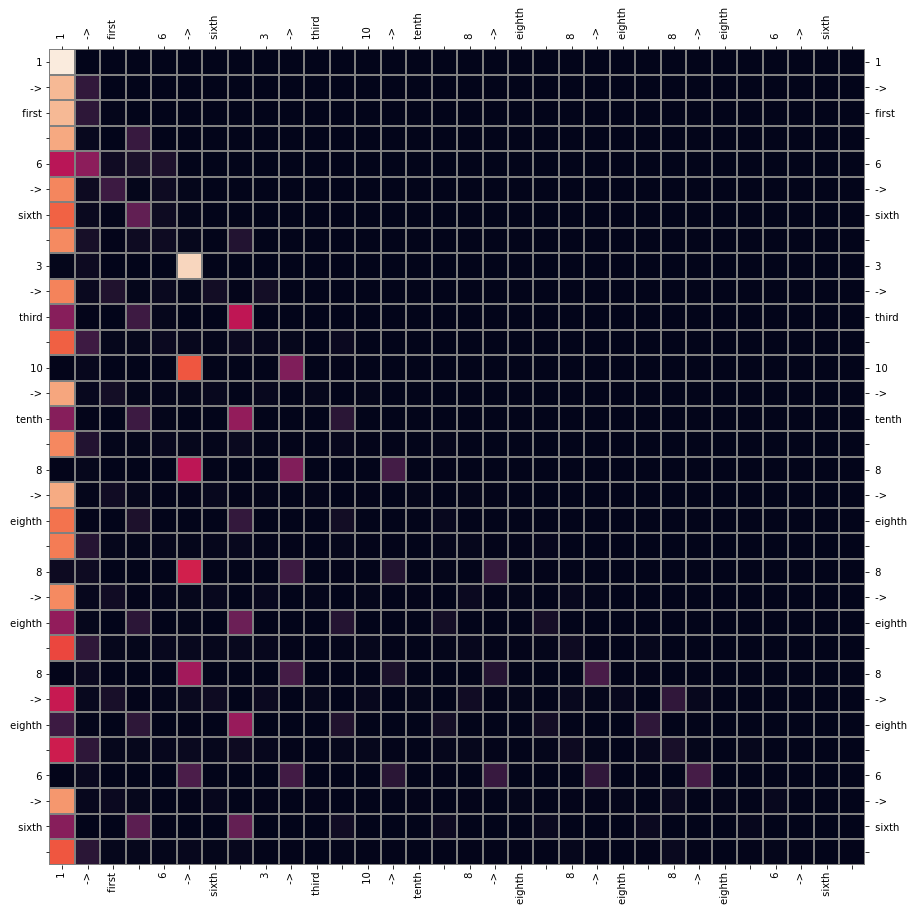

In [723]:
plot_attn(o.attentions[26][0, 8], tokens)

In [70]:
def T(f): return lambda x: f(x.T).T
show_topk.indices_fn = tokenizer.convert_ids_to_tokens
def scatter_plot(a): a = a.detach().numpy(); plt.plot(a[:,0], a[:,1], '.')
mlp = lambda x: mlp_forward(blocks[0], x)
mlp1 = lambda x: mlp_forward(blocks[19], x)
# v = we.size(1)
# 看head+mlp[0]的ov circuit所作的变换
# next num qk 3-12 (work with prev ov),  prev word+num qk 3-3 (work with next ov), general qk 3-11
layer, head = 8, 7  # prev ov: 13-9, next num ov: 14-13, next word ov: 13-4, prepend space ov: 18-3/17-10, isa ov: 14-7, antonym ov: 16-14
wq, wk, wv, wo = get_head_weights(model, layer, head)
ln = blocks[layer].ln_1
v  = we.size(1)
qk = True
with torch.no_grad():  # ve,ed,de,ev->vv
    m = ln(mlp(we[:v].T)) @ (wq.T @ wk) @ T(ln)(T(mlp)(we[:, :v])) if qk else wu[:v] @ T(ln_f)(wo @ wv @ T(ln)(T(mlp)(we[:, :v])))
    qk = False
with torch.no_grad():  # ve,ed,de,ev->vv
    m = ln(mlp1(mlp(we[:v].T))) @ (wq.T @ wk) @ T(ln)(T(mlp1)(T(mlp)(we[:, :v]))) if qk else wu[:v] @ T(ln_f)(wo @ wv @ T(ln)(T(mlp1)(T(mlp)(we[:, :v]))))
    
m = m  # q->k,  output->input
# m = m.T  # k->q, input->output
values, indices = m.topk(10)

In [19]:
def T(f): return lambda x: f(x.T).T
mlp = lambda x: mlp_forward(blocks[0], x)
v = we.size(1) #// 2
_we, _wu = we[:, :v], wu[:v]
# with torch.no_grad(): _e = mlp(_we.T) + _we.T
with torch.no_grad(): _e = mlp(_we.T)+ _we.T

In [20]:
layer, head = 14, 7
wq, wk, wv, wo = get_head_weights(model, layer, head, transpose=True)
with torch.no_grad(): eq = ek = e = blocks[layer].ln_1(_e)
# layer0, head0 = 8, 7; wv0, wo0 = get_head_weights(model, layer0, head0, transpose=True)[2:]
# if layer0 is not None: ek = blocks[layer].ln_1(blocks[layer0].ln_1(_e) @ wv0 @ wo0)

with torch.no_grad():
    # A, B = _wu, ln_f(e @ wv @ wo)
    A, B = _wu @ wo.T, e @ wv
    q, k = eq @ wq, ek @ wk

In [21]:
qk = False
with torch.no_grad():  # ve,ed,de,ev->vv
    # _m = ln(mlp(_we.T)) @ (wq.T @ wk) @ T(ln)(T(mlp)(_we)) if qk else _wu @ T(ln_f)(wo @ (wv @ T(ln)(T(mlp)(_we))))
    _m = q @ k.T if qk else _wu @ ln_f(B @ wo).T

0.99529629945755

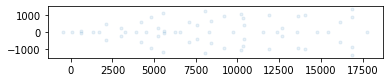

In [290]:
plot_eigv((k.T @ q).eig()[0] if qk else (B.T @ A).eig()[0], start_i=1)

In [22]:
# m = _m  # q->k, output->input
m = _m.T  # k->q, input->output
values, indices = m.topk(25, largest=True)

In [4]:
ans_prob_dist = torch.rand(1,32,10)

In [8]:
ans_prob_dist[0,0:1].softmax(-1).shape

torch.Size([1, 10])

In [23]:
show_topk.indices_fn = tokenizer.convert_ids_to_tokens
# show_topk.indices_fn = partial(convert_ids_to_tokens, tokenizer=tokenizer)

In [24]:
for i in values.mean(1).topk(1000).indices.tolist():
    print(tokenizer.convert_ids_to_tokens(i), show_topk(values[i].long(), indices[i]))

Ġsize {'Ġsize': 56, 'Ġsizes': 55, 'ĠSize': 52, 'size': 51, 'Ġsized': 49, 'Size': 49, 'sized': 44, 'SIZE': 42, 'Ġsmaller': 40, 'Ġlarger': 39, 'Ġsizing': 39, 'Ġbigger': 36, 'larg': 34, 'Ġlargest': 32, 'Ġoversized': 32, 'Ġsmallest': 31, 'Ġsmall': 30, 'small': 29, 'Ġlarge': 29, 'largest': 29, 'Small': 28, 'Ġsizeof': 28, 'Ġdiameter': 28, 'ĠSmall': 27, 'Large': 27}
Large {'Ġsize': 49, 'Ġsizes': 48, 'Ġsized': 45, 'ĠSize': 43, 'Ġlarger': 42, 'size': 42, 'Ġsmaller': 41, 'Size': 39, 'sized': 39, 'Ġbigger': 37, 'Ġlarge': 36, 'larg': 36, 'Ġsmall': 36, 'small': 36, 'Large': 35, 'Small': 34, 'Ġlargest': 34, 'ĠLarge': 33, 'Ġsmallest': 33, 'large': 33, 'SIZE': 32, 'ĠSmall': 32, 'largest': 31, 'Ġsizing': 31, 'Ġsizable': 29}
Ġsmall {'Ġsize': 47, 'Ġsizes': 47, 'Ġsized': 44, 'Ġlarger': 43, 'ĠSize': 43, 'size': 42, 'Ġsmaller': 41, 'Ġbigger': 39, 'sized': 39, 'Size': 39, 'Ġsmall': 37, 'larg': 36, 'Ġlarge': 36, 'small': 36, 'Large': 35, 'Ġsmallest': 34, 'ĠLarge': 33, 'Small': 33, 'ĠSmall': 33, 'SIZE': 33, 'Ġ

Ġmultiple {'multiple': 30, 'Ġmultiple': 29, 'Multiple': 28, 'ĠMultiple': 27, 'single': 26, 'Ġnumber': 26, 'Ġsingle': 25, 'Ġmultipl': 25, 'multi': 25, 'mult': 25, 'multipl': 25, 'Ġmultiply': 24, 'number': 24, 'Ġmulti': 24, 'Number': 23, 'Single': 23, 'Multi': 22, 'ĠMulti': 22, 'Ġmultip': 22, 'ĠSingle': 21, 'Ġmult': 21, 'Ġdual': 21, 'Mult': 21, 'ĠNumber': 20, 'NUM': 20}
Ġtimetable {'tim': 30, 'Ġtiming': 29, 'Ġtimetable': 28, 'Ġtimed': 28, 'Ġtim': 27, 'Tim': 25, 'ĠTim': 25, 'time': 25, 'Ġtimelines': 25, 'Ġtime': 24, 'Ġtimeframe': 24, 'Ġtimet': 24, 'Ġtimeline': 24, 'Ġschedule': 23, 'Ġschedules': 23, 'Time': 23, 'Ġtempo': 22, 'timer': 22, 'Ġtimestamp': 22, 'ĠTime': 21, 'Ġtimer': 21, 'Ġtemporal': 21, 'Ġtimers': 21, 'TIME': 20, 'Ġdeadlines': 19}
Ġshallow {'Ġdepth': 38, 'depth': 37, 'Ġdepths': 34, 'ĠDepth': 33, 'Ġdeeper': 33, 'Depth': 32, 'Ġshallow': 30, 'Ġdeep': 28, 'deep': 26, 'Ġdeepest': 24, 'Depths': 24, 'ĠDepths': 23, 'Deep': 22, 'Ġdeepening': 21, 'Ġdeepen': 20, 'Ġdeeply': 20, 'ĠDeep': 19

In [26]:
from lxy.utils import *
samples = get_examples_isA(12)

In [27]:
ans = []
for sample in samples:
    for data in sample.split('\n')[:-1]:
#         print(data)
        temp1, temp2 = data.split(' -> ')
#         print(temp1,temp2)
        ans.append((temp1,temp2))

In [28]:
ans[0]

('fast', 'speed')

In [29]:
country2capital = [ #The capital of Germany is Berlin.
    ('Germany', 'Berlin'),
    ('France', 'Paris'),
    ('China', 'Beijing'),
    ('the United States', 'Washington, D.C'),
    ('Italy', 'Rome'),
    ('Japan', 'Tokyo'),
    ('Russia', 'Moscow'),
    ('Spain', 'Madrid'),
    ('the United Kingdom', 'London'),
    ('Canada', 'Ottawa'),
    ('India', 'New Delhi'),
    ('Australia', 'Canberra'),
    ('Brazil', 'Brasília'),
    ('Mexico', 'Mexico City'),
    ('South Africa', 'Pretoria'),
    ('Egypt', 'Cairo'),
    ('Kenya', 'Nairobi'),
    ('Korea', 'Seoul'),
    ('the Philippines', 'Manila'),
    ('Portugal', 'Lisbon'),
    ('Switzerland', 'Bern'),
    ('Thailand', 'Bangkok'),
    ('Turkey', 'Ankara'),
    ('Spain', 'Madrid'),
    ('Greece', 'Athens'),
]
# tempstring ='A B C D E F G H I J K L M N O P Q R S T U V W X Y Z'
for key,value in ans:
    i = tokenizer.encode(' ' + key)[-1]; print(tokenizer.convert_ids_to_tokens(i))
    print(show_topk(*m[i].topk(10)))
# i = tokenizer.encode(' '+)[0]; print(tokenizer.convert_ids_to_tokens(i))
# show_topk(*m[i].topk(10))

Ġfast
{'Ġspeed': 42.101, 'Ġslower': 40.927, 'Ġspeeds': 38.982, 'Ġslow': 38.775, 'speed': 37.629, 'Ġfaster': 36.576, 'Speed': 36.055, 'Slow': 35.519, 'slow': 35.394, 'ĠSpeed': 35.181}
Ġ2017
{'Ġyear': 32.017, 'ĠYear': 30.657, 'Year': 30.626, 'year': 28.176, 'ĠYEAR': 24.305, 'Ġyears': 22.742, 'Ġyearly': 22.184, 'Ġdate': 22.061, 'Ġdates': 21.207, 'years': 20.585}
Ġwarm
{'Ġtemperature': 36.782, 'ĠTemperature': 33.122, 'Ġtemperatures': 33.071, 'Ġcolder': 31.669, 'Ġwarmer': 29.981, 'Temperature': 29.84, 'Ġcold': 28.073, 'Ġhotter': 27.8, 'Ġwarmth': 27.79, 'Ġcooler': 27.281}
Ġold
{'Ġage': 45.358, 'Ġaged': 39.49, 'Ġages': 38.689, 'ĠAge': 36.321, 'Age': 36.074, 'Ġyounger': 35.512, 'Ġolder': 35.373, 'Ġaging': 33.352, 'Ġageing': 31.365, 'Ġoldest': 30.149}
Ġcool
{'Ġtemperature': 31.755, 'ĠTemperature': 28.056, 'Ġcooler': 27.973, 'Ġtemperatures': 27.828, 'cool': 27.312, 'warm': 27.193, 'Ġwarmer': 27.143, 'Ġcool': 26.474, 'Ġwarm': 26.404, 'Ġhotter': 26.256}
Ġspring
{'Ġseasonal': 20.666, 'Ġseason': 19.

Ġautumn
{'Ġseasonal': 22.036, 'season': 18.726, 'Ġseason': 18.427, 'ĠSeason': 17.275, 'Ġseasons': 17.056, 'Ġautumn': 17.041, 'Ġspring': 16.672, 'Ġwinter': 16.618, 'Season': 15.669, 'Ġmonth': 15.323}
Ġcat
{'Ġ0': 13.871, 'tier': 12.24, 'Ġinstead': 12.135, 'Ġsmaller': 11.926, 'Ġsmall': 11.864, 'Ġdimension': 11.814, 'Ġspecies': 11.425, 'Ġcomfortably': 11.258, 'Ġtemporarily': 11.24, 'Ġoptimal': 11.189}
Ġ2017
{'Ġyear': 32.017, 'ĠYear': 30.657, 'Year': 30.626, 'year': 28.176, 'ĠYEAR': 24.305, 'Ġyears': 22.742, 'Ġyearly': 22.184, 'Ġdate': 22.061, 'Ġdates': 21.207, 'years': 20.585}
Ġred
{'Ġcolor': 41.292, 'Ġcolour': 38.814, 'Ġcolors': 37.89, 'Ġcolored': 36.024, 'color': 35.683, 'Ġcolours': 35.462, 'ĠColor': 34.917, 'colour': 33.533, 'Color': 33.351, 'Ġcoloured': 32.836}
ĠFebruary
{'Ġmonth': 25.809, 'ĠMonth': 23.284, 'month': 23.147, 'Month': 22.512, 'Ġdate': 21.518, 'date': 20.834, 'months': 19.354, 'January': 19.219, 'Ġmonths': 19.045, 'November': 18.965}
Ġfast
{'Ġspeed': 42.101, 'Ġslower': 40

### attr.head.shape

In [814]:
def data2str(data):
    i, topk, layer, head, label_type = data.step, data.topk, data.layer, data.head, data.label_type
    # s = f'[{i}] top{topk} {layer}' if head is None else f'[{i}] top{topk} {layer}-{head}'
    s = f'[{i}] top{topk} '
    if head is None: s += f'{layer}'
    elif not isinstance(layer, Iterable): s += f'{layer}-{head}'
    else: s += ','.join([f'{l}-{h}' for l, h in zip(layer, head)])

    if label_type is not None: s = s + ' ' + label_type
    return s

In [816]:
def node2fn(model, node, outputs, labels, attn_attr):
    d = node.data
    i, layer, head, label_type = d.step, d.layer, d.head, d.label_type
    if head is None:
        return partial(mlp_forward, layer=layer) if label_type is None \
            else partial(mlp_forward, layer=layer, labels=labels)
    if label_type == 'attn_labels':
        if isinstance(layer, Iterable): # tuple, list or np.ndarray
            attn_labels = [attn_attr[node.parent.name][l, h] for l, h in zip(layer, head)]
            hidden_states_k = [outputs.hidden_states[l] for l in layer]
        else:
            attn_labels = attn_attr[node.parent.name][layer, head]
            # attn_labels = attn_labels / (attn_labels.sum(-1, keepdim=True) + 1e-9)  # ij->i1 # don't normalize attn attr
            hidden_states_k = outputs.hidden_states[layer]
        kwargs = {'hidden_states_k': hidden_states_k, 'attn_labels': attn_labels}
    else:
        kwargs = {'attn_weights': outputs.attentions[layer]}
        if label_type == 'labels':
            kwargs['labels'] = labels
        elif label_type == 'argmax_labels':
            kwargs['labels'] = get_argmax_labels(model, outputs.head_outputs[layer][:, head], labels)
    return partial(head_forward, layer=layer, head=head, **kwargs)

In [1410]:
# 创建归因树的根节点
i = -1
root = Node('[-1] root')
root.data = AttrData(step=i)
nodes = {}
nodes[i] = root
print_tree(root)

 [-1] root


In [1399]:
i = 0

In [1428]:
# 查看当前父节点的信息
i
parent = nodes[i]
print(parent.name)
attr = parent.data.attr
list(zip(*topk_md(attr.head, 8)))
list(zip(*topk_md(attr.mlp, 5)))


2

[2] top1 9-11 attn_labels


[(8, 1, 0.8178904),
 (4, 3, 0.4191555),
 (6, 3, 0.22937278),
 (7, 14, 0.22547106),
 (1, 7, 0.17756931),
 (5, 9, 0.17319524),
 (6, 6, 0.16743737),
 (8, 3, 0.15427525)]

[(0, 1.1132423),
 (6, 0.64482975),
 (4, 0.48666254),
 (8, 0.42636803),
 (2, 0.2141263)]

In [1430]:
# 选择下一步要归因的head/mlp，创建节点数据
# topk = [0,1]
topk = 0
# layer, head = np.array(list(zip(*topk_md(attr.head, 10)[:2])))[topk].T
layer, head, _ = list(zip(*topk_md(attr.head, 10)))[topk]

# layer, head = list(zip(*topk_md(attr.mlp, 10)))[topk][0], None 
label_type = [None, 'labels', 'argmax_labels', 'attn_labels'][0]
if i == -1: assert label_type in ['labels', 'argmax_labels', 'attn_labels']
# else: assert label_type is None
data = AttrData(step=i + 1, topk=topk, layer=layer, head=head, label_type=label_type)
print(data2str(data))

[3] top0 8-1


In [1431]:
# 创建节点添加到树，并作为当前父节点
i += 1
node = Node(data2str(data), parent)
node.data = data
nodes[i] = node
nodes[i].name = '*' + nodes[i].name
print_tree(root)
nodes[i].name = nodes[i].name[1:]  # strip prepending '*'

 [-1] root┐
          └[0] top[0, 1, 2, 4, 5] 21-8,18-15,22-5,13-9,22-4 attn_labels┐
                                                                       └[1] top[0, 1] 12-10,13-13 attn_labels┐
                                                                                                             └[2] top1 9-11 attn_labels┐
                                                                                                                                       └*[3] top0 8-1


In [1409]:
node.name

'[1] top1 13-13 attn_labels'

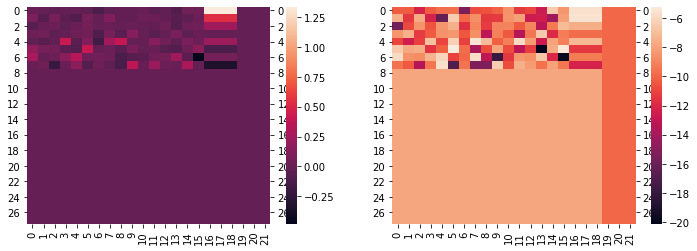

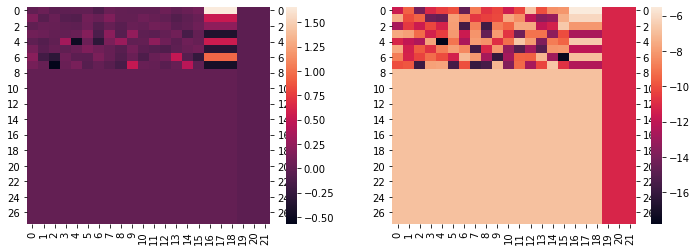

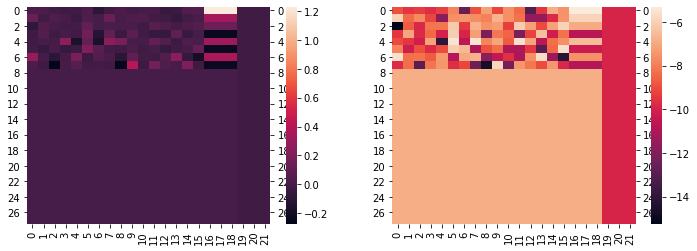

attribution step 3 results


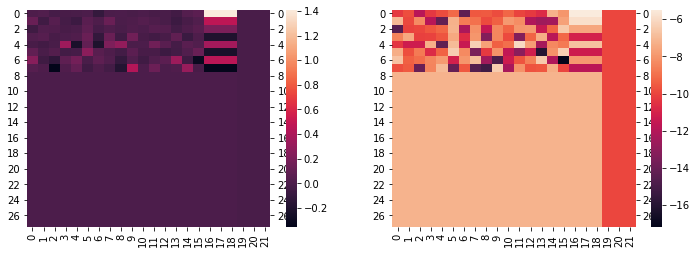

,0,1,2,0,1,2,0,1,0,1
0,7,9,0.428892,4,11,-6.047760,0,1.411348,0,-5.486750
1,4,3,0.337722,4,7,-6.351696,1,0.467760,1,-5.892434
2,6,13,0.329057,5,15,-6.365631,6,0.456055,4,-6.785124
3,7,14,0.313462,5,5,-6.411388,4,0.363662,2,-7.555506
4,4,8,0.292774,7,9,-6.491060,2,0.201111,6,-7.930259
5,5,5,0.259090,6,13,-6.526752,3,-0.207844,3,-11.029980
6,6,0,0.251014,2,15,-6.557787,5,-0.232953,5,-11.263560
7,4,7,0.208561,6,0,-6.760713,7,-0.337034,7,-11.823228


3


In [1432]:
attrs, attrs2 = [], []
for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[:3]:
    fns = []; node = nodes[i]
#     while node != root: fns.append(node2fn(model, node, o, labels, attn_attr)); node = node.parent
    while node != root.children[0].children[0]: fns.append(node2fn(model, node, o, labels, attn_attr)); node = node.parent
#     fns.append(node2fn(model, node, o, labels, attn_attr));
    (output_layer, _labels) = (nodes[i].data.layer, None) if len(fns) > 0 else (L, labels)
    to_layer = max(output_layer) if isinstance(output_layer, Iterable) else output_layer
    keys = ['attn_weights', 'mlp_mask', 'embed_mask']
    x = OrderedDict((key, get_x(key, o, to_layer=to_layer)) for key in keys)
    fwd_fn = partial(sum_forward, outputs=o, labels=_labels, output_layer=output_layer)
    attr, ys, logits = attribute(fwd_fn, model, x, fns, num_points=10, batch_size=11)  # print(ys)

    fwd_fn = partial(sum_forward, outputs=o, labels=_labels, reduce_fn=torch.cat, scaled=False)
    attr2 = attribute2(fwd_fn, model, x, fns)

    plot_attr(attr, attr2)
    # pd.concat([to_df(*topk_md(a[: to_layer], 10)) for a in [attr.head, attr2.head, attr.mlp, attr2.mlp]], axis=1)
    attrs.append(attr); attrs2.append(attr2)
    attn_attr[nodes[i].name] = attr.attn # attn attr can NOT be averaged accross examples and attached to current node's data. 
                                         # associate attn attr to current node in this tricky way
        
print(f'attribution step {i} results')
attr, attr2 = reduce_objects(attrs, ['head', 'mlp']), reduce_objects(attrs2, ['head', 'mlp'])
plot_attr(attr, attr2)
pd.concat([to_df(*topk_md(a[: to_layer], min(to_layer, 10))) for a in [attr.head, attr2.head, attr.mlp, attr2.mlp]], axis=1)
print(i)
nodes[i].data.attr = attr

In [823]:
from model_utils import get_conductivity,

In [834]:
import gzip,pickle
with gzip.open(f'eigv_positivity012_{model_name}.pkl.gz', 'rb') as f:
    eigv_positivity012 = pickle.load(f)

In [843]:
d = np.load('k_compositions_gpt2-large.npz')
k_compositions = d['k_compositions']
k_comp_max = k_compositions.max(-1)[0]

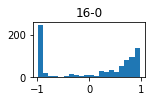

16-0 0.751


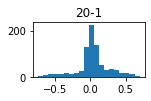

20-1 0.156


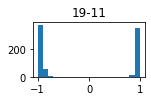

19-11 0.934


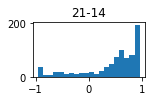

21-14 0.629


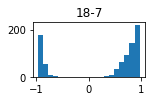

18-7 0.830
18-19 0.000


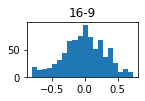

16-9 0.252


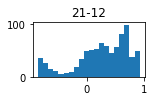

21-12 0.456


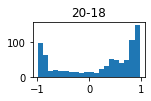

20-18 0.675


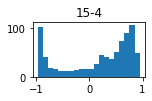

15-4 0.605


In [918]:
for l, h, v in zip(*topk_md(attr.head, 10)):
    print('%d-%d %.3f' % 
        (l, h, get_conductivity(eigv_positivity012, l, h, plot=True, figsize=(2, 1))))

In [ ]:
16-0/20-1/19-11/18-7/16-9/21-12/20-18

7 9 0.4288919 4


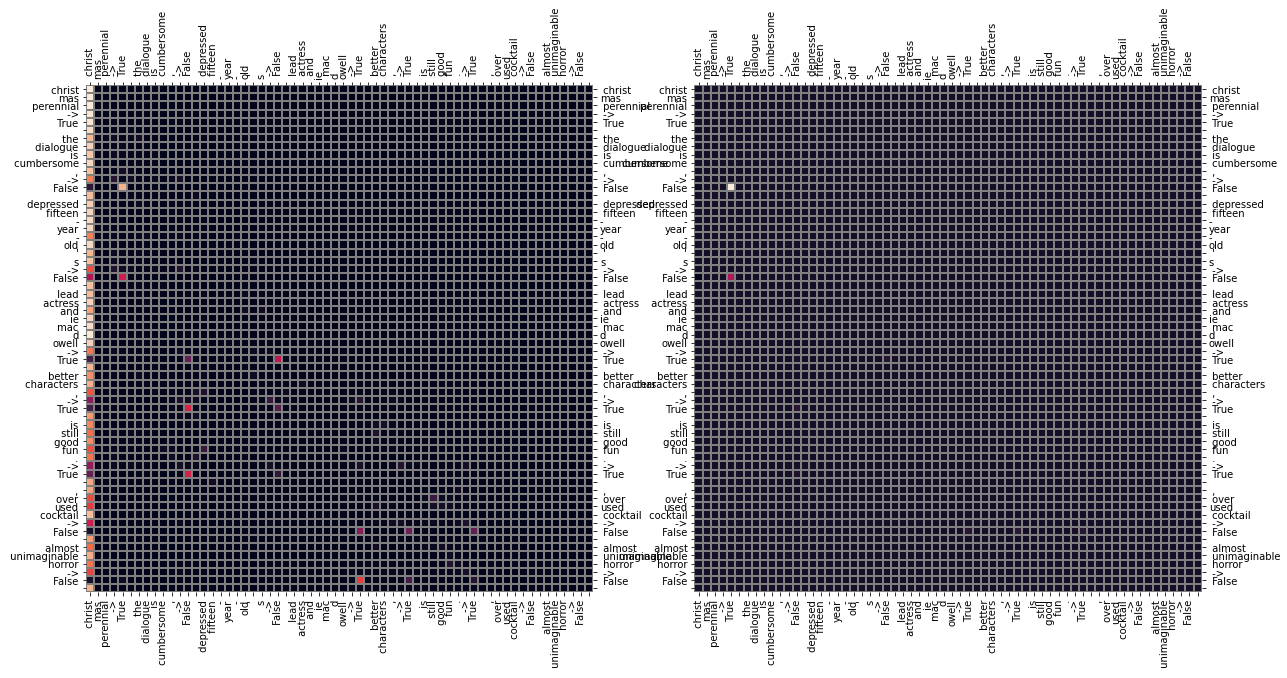

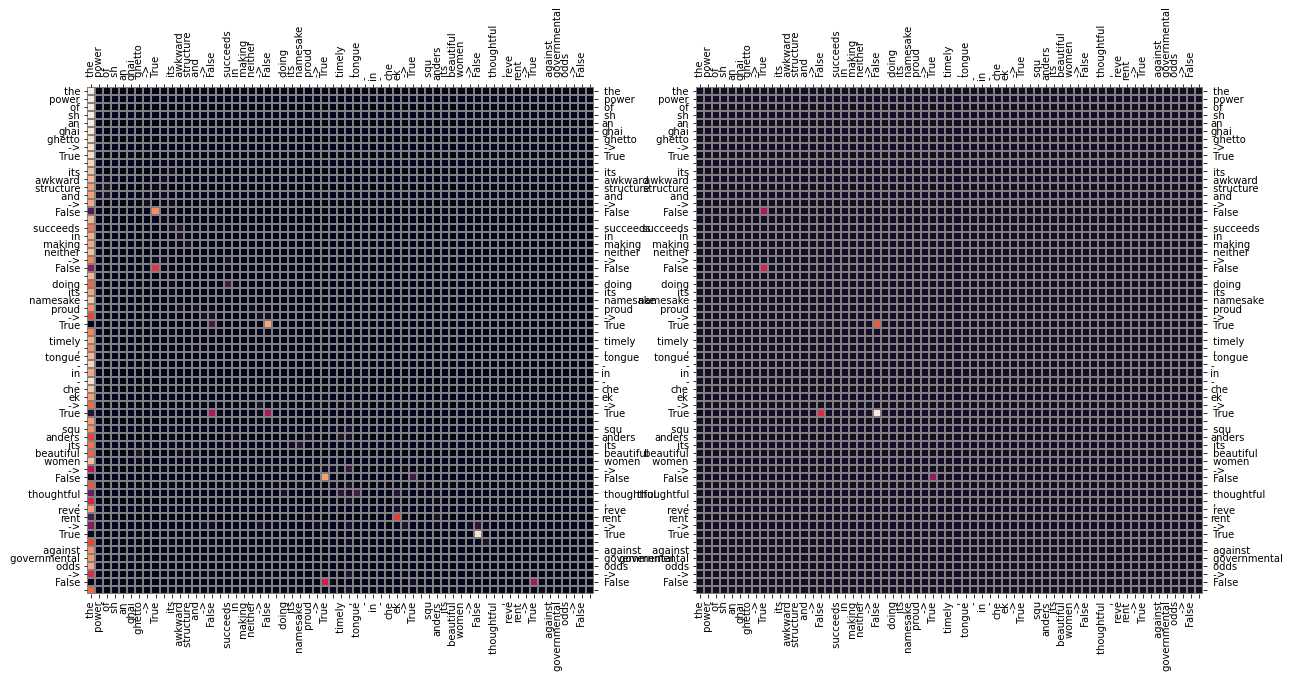

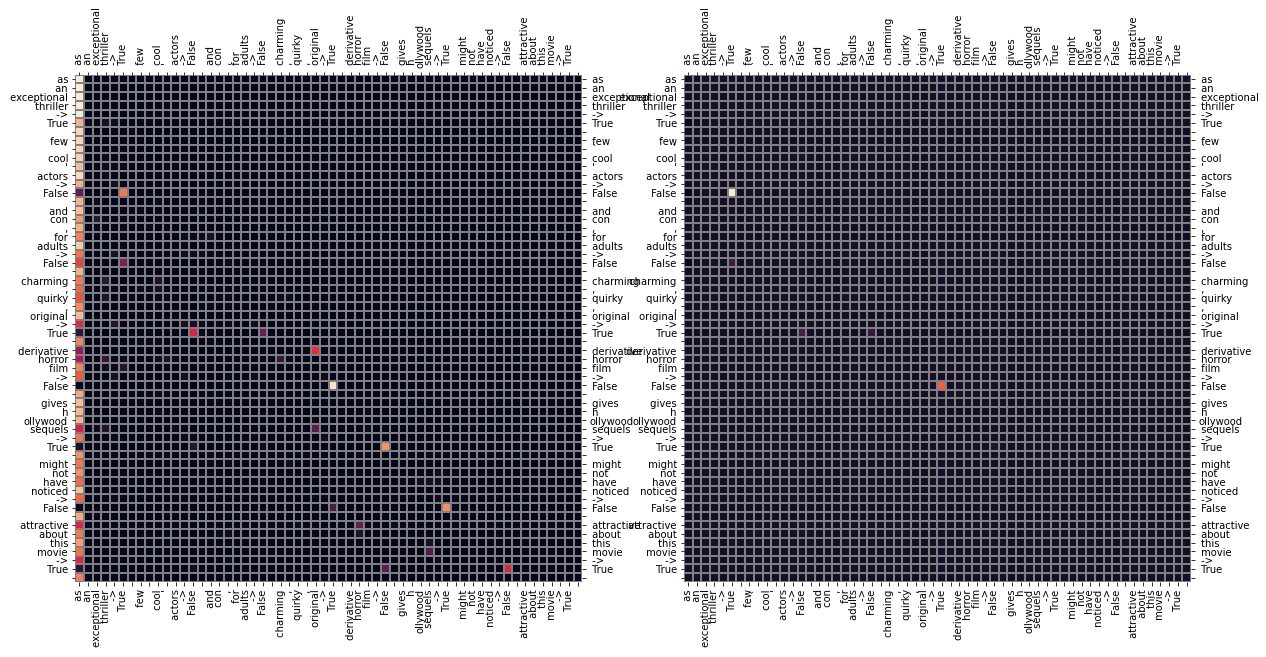

4 3 0.3377216 None


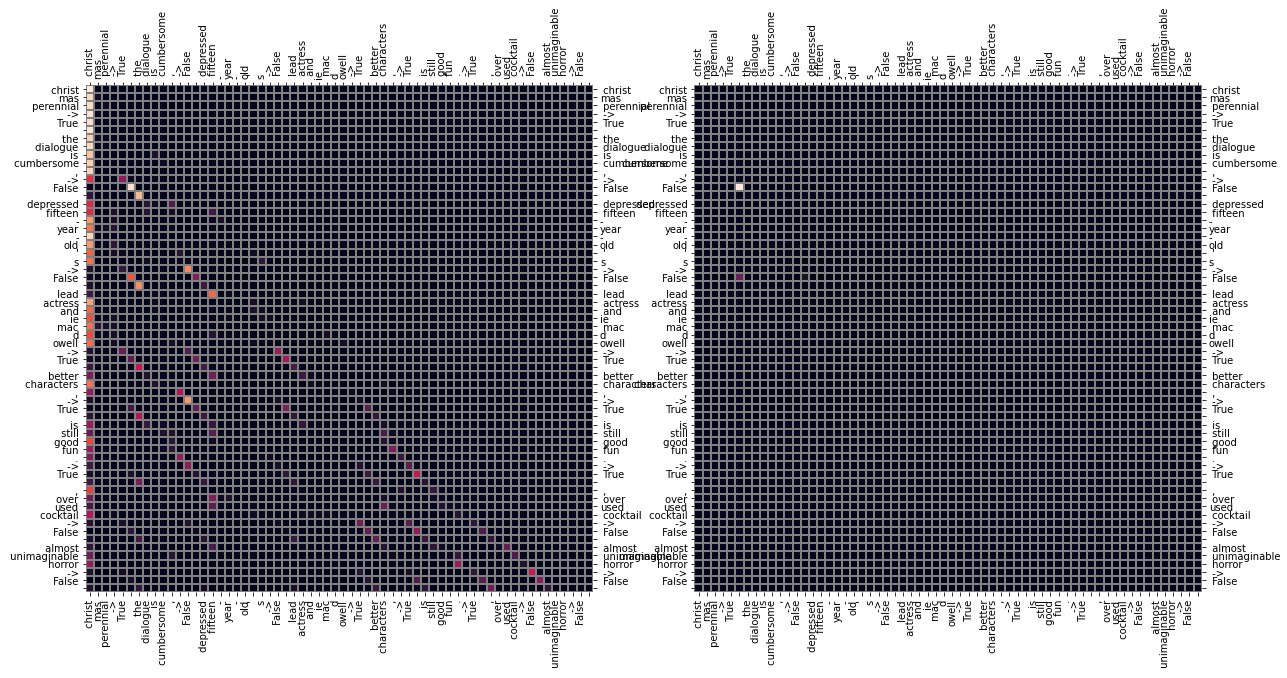

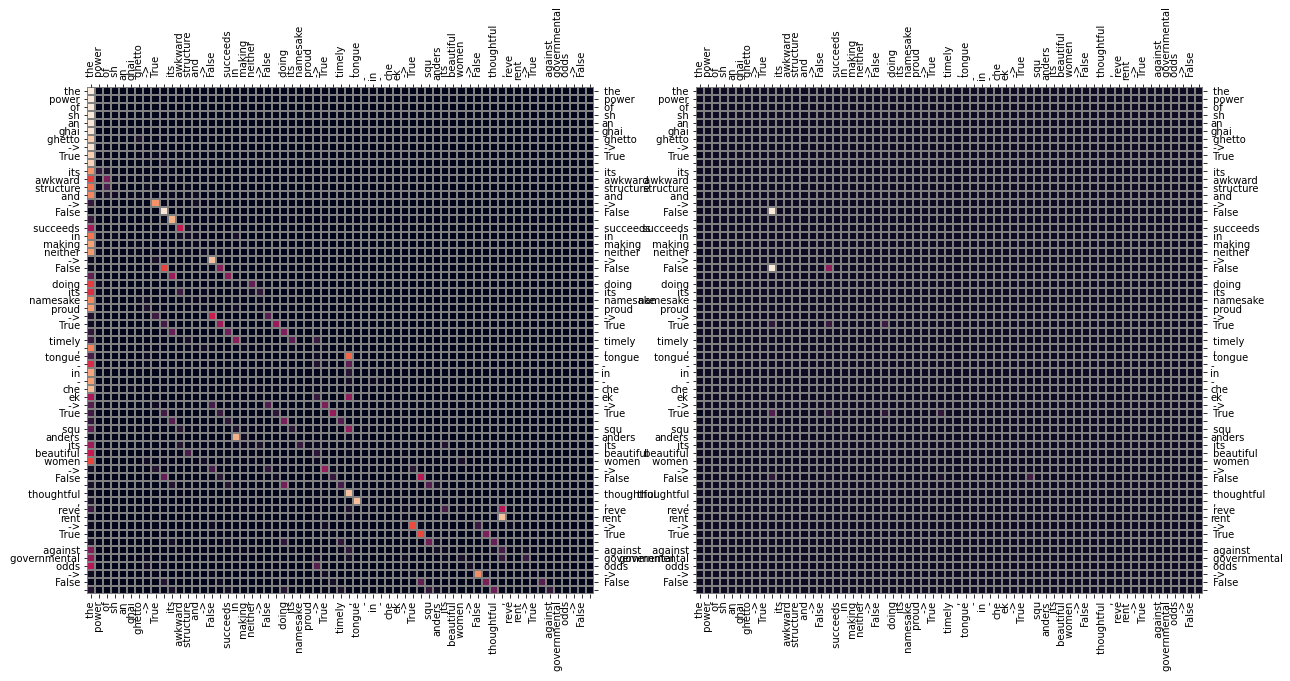

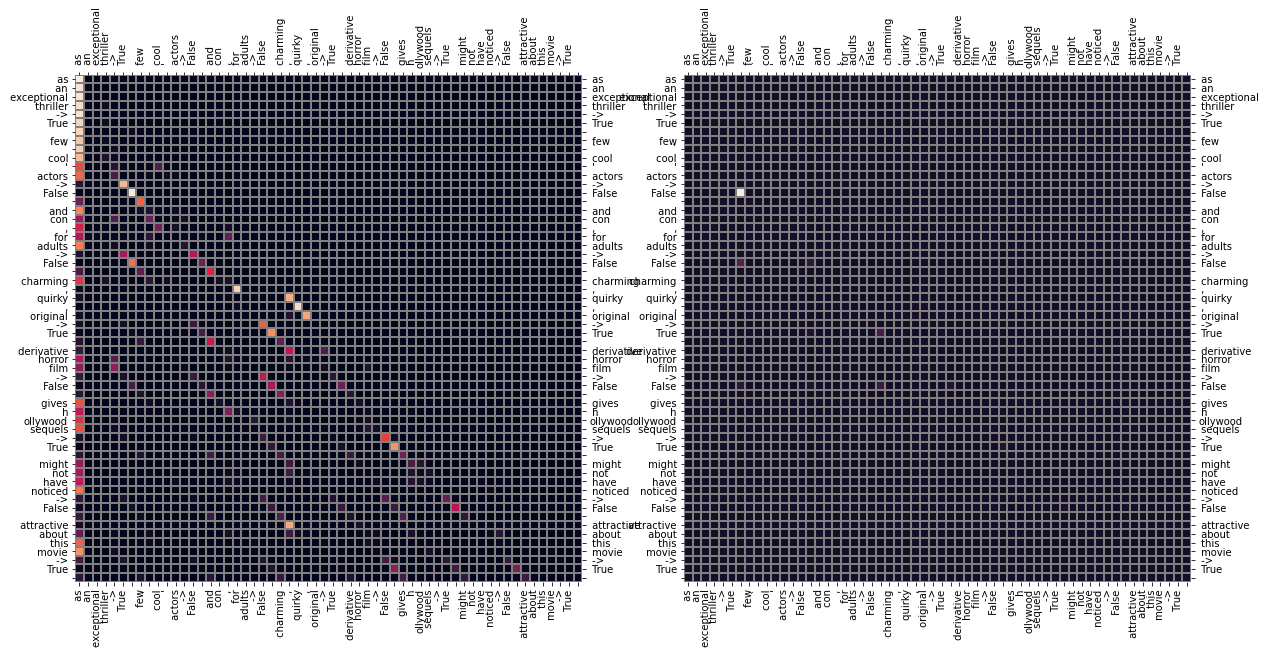

6 13 0.3290573 5


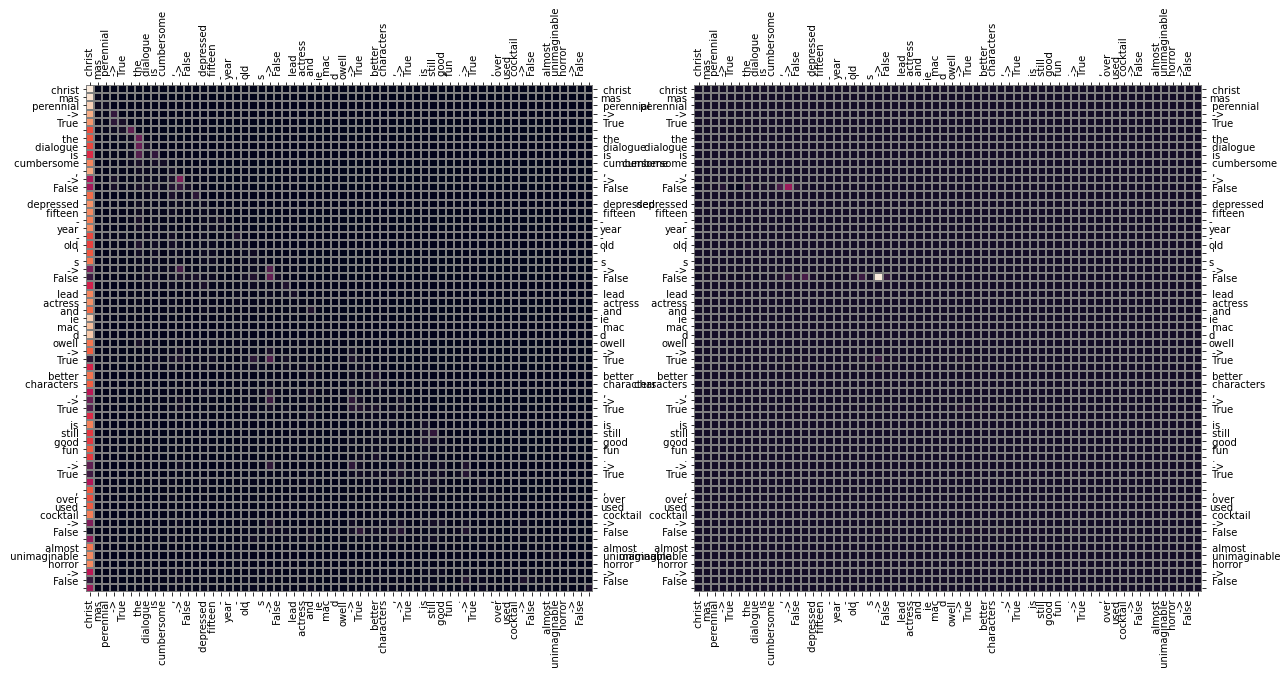

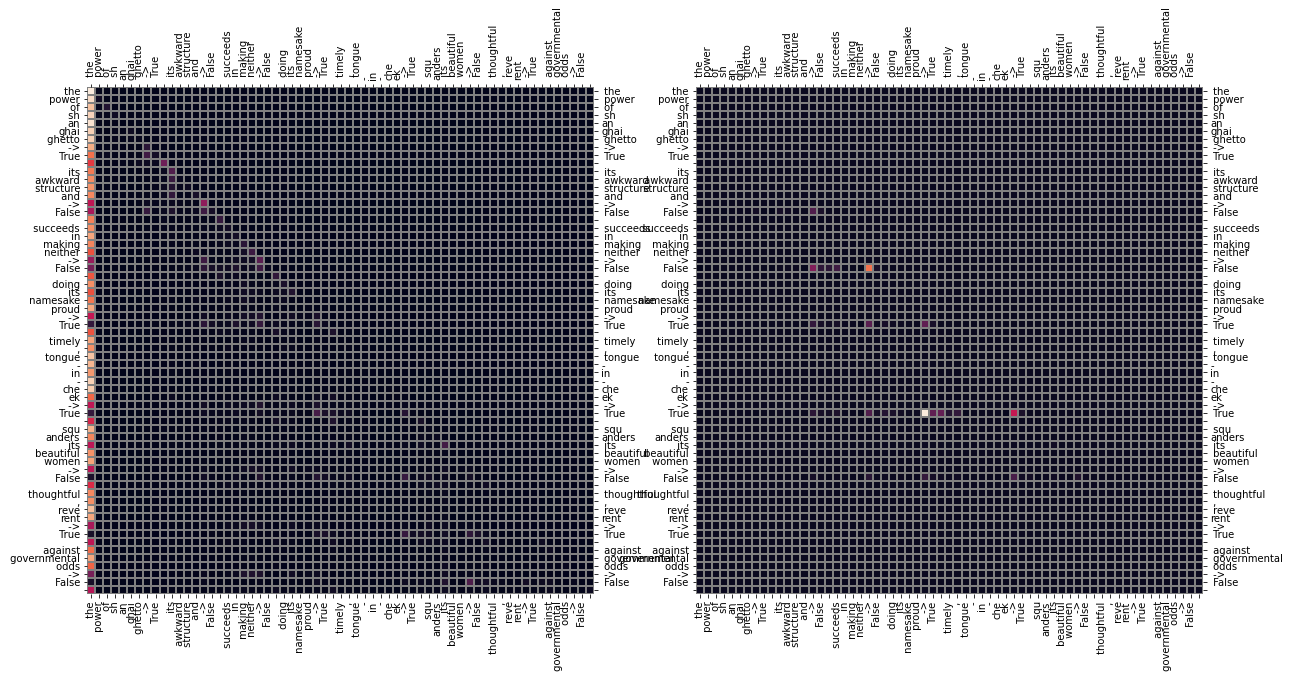

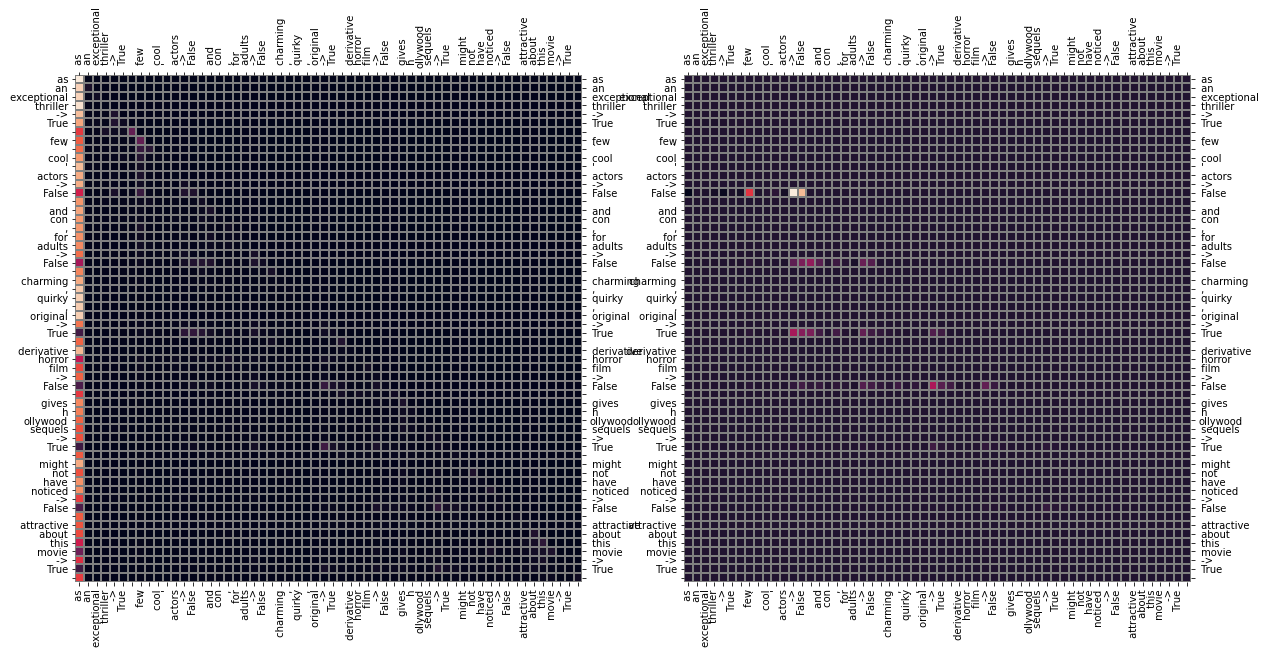

7 14 0.313462 None


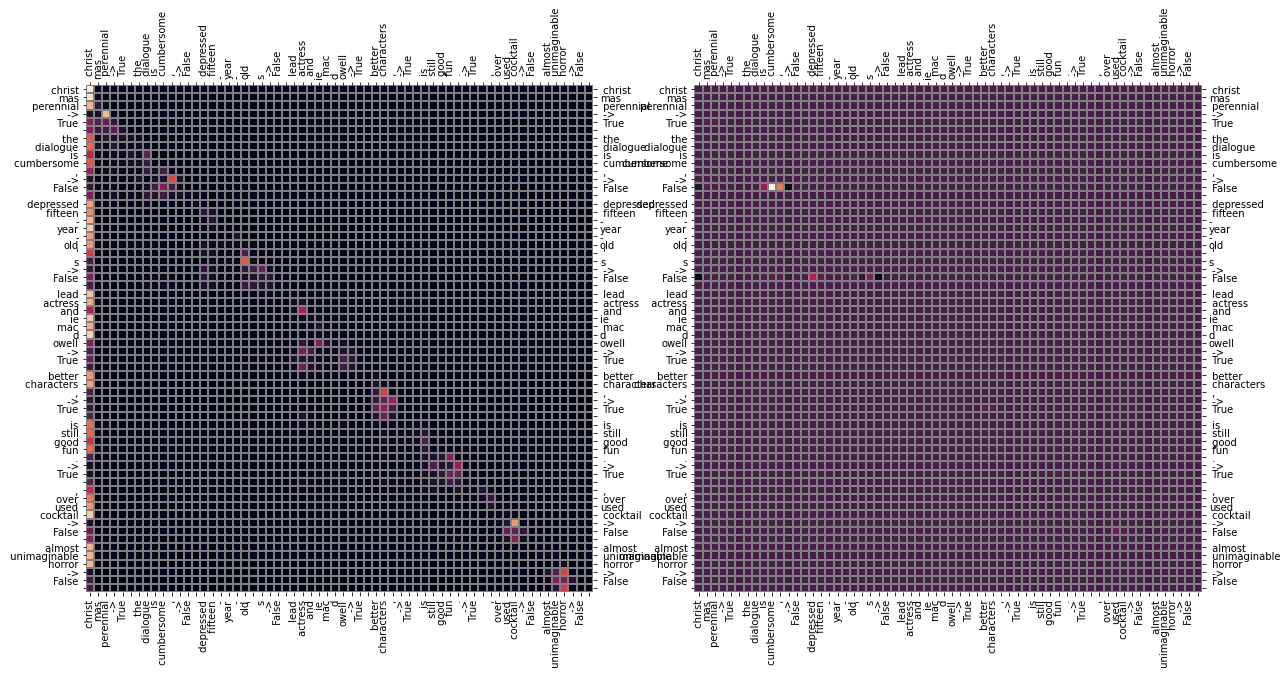

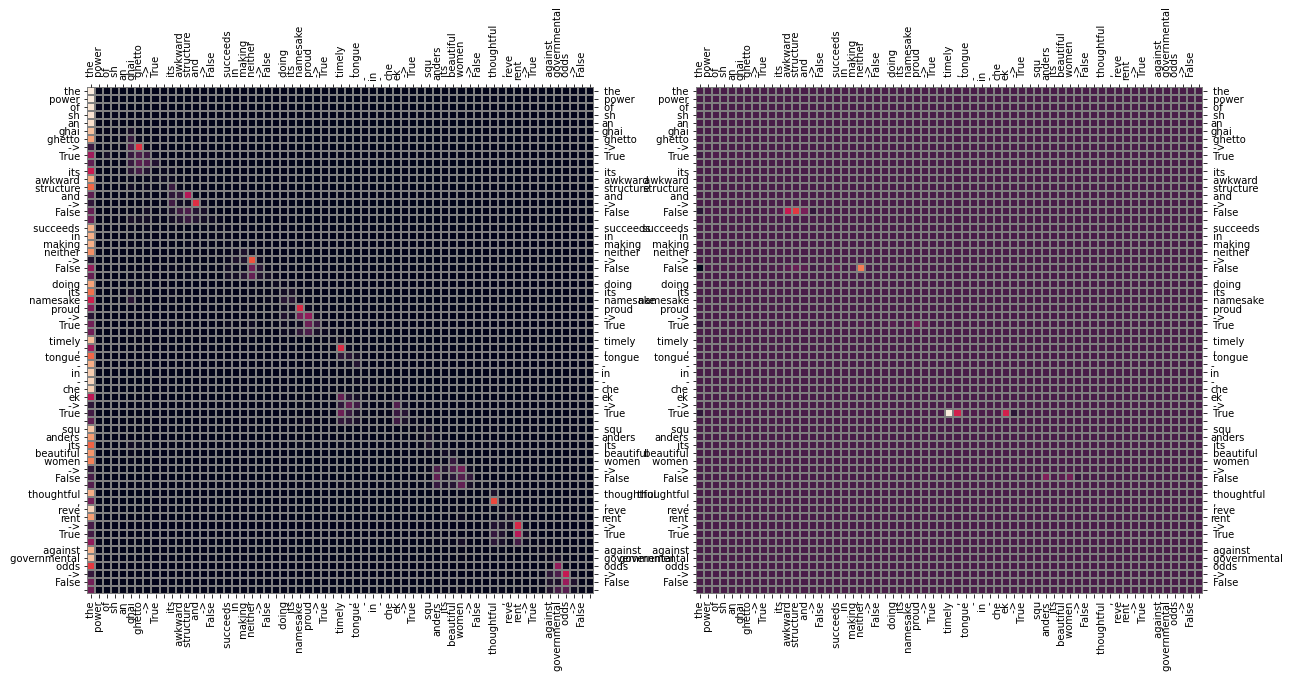

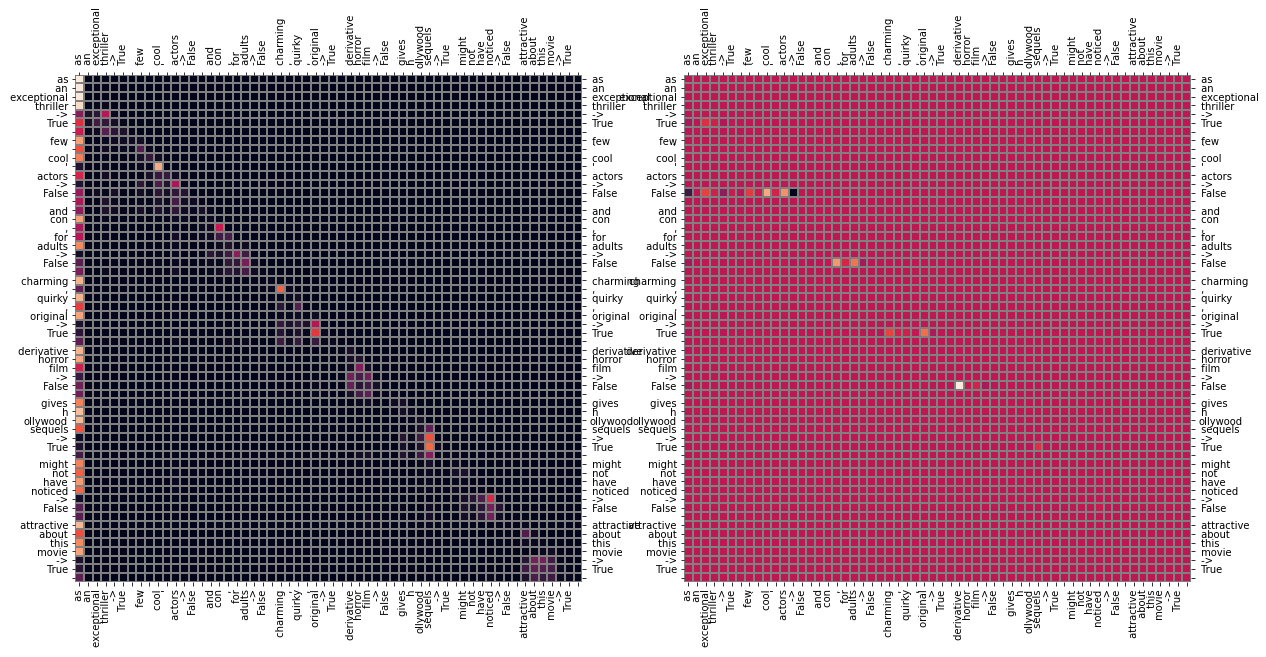

4 8 0.29277423 None


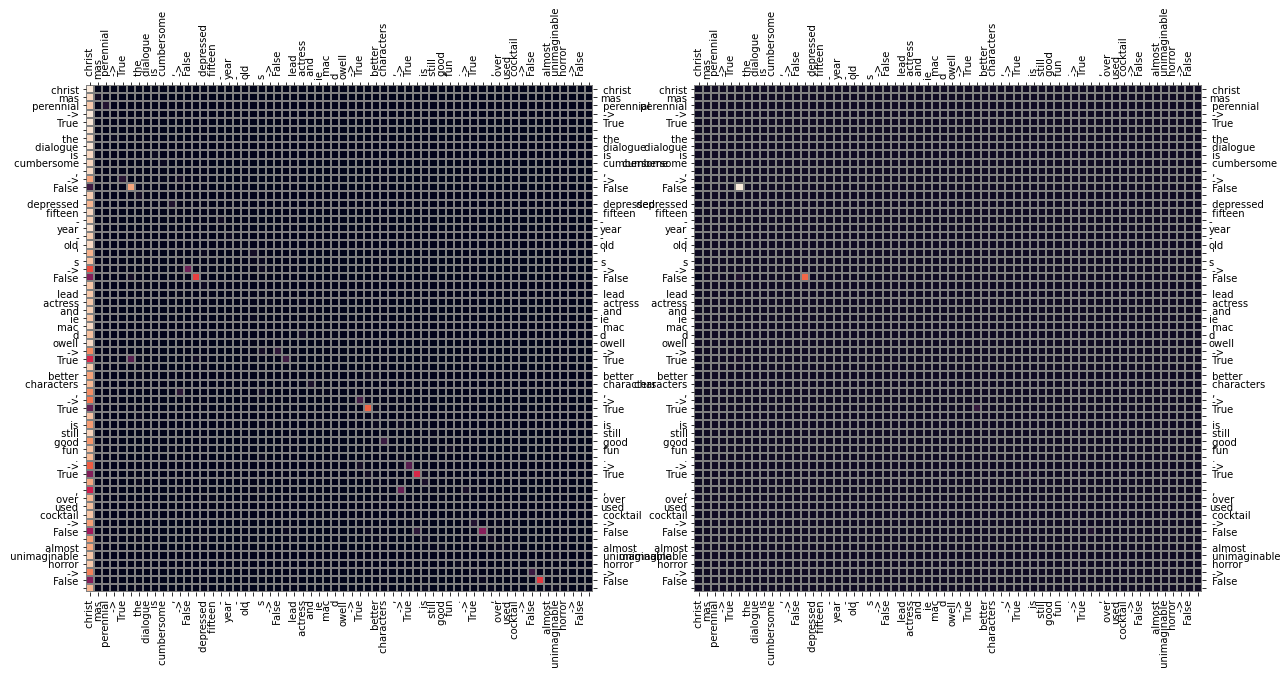

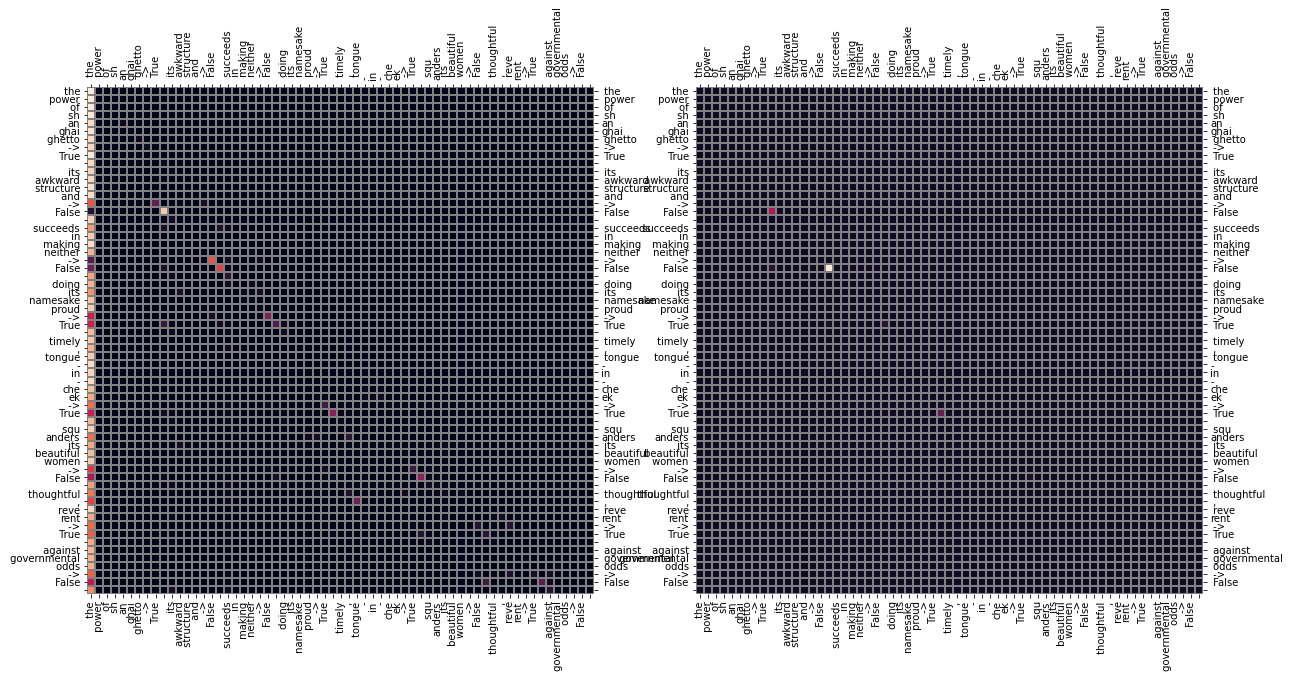

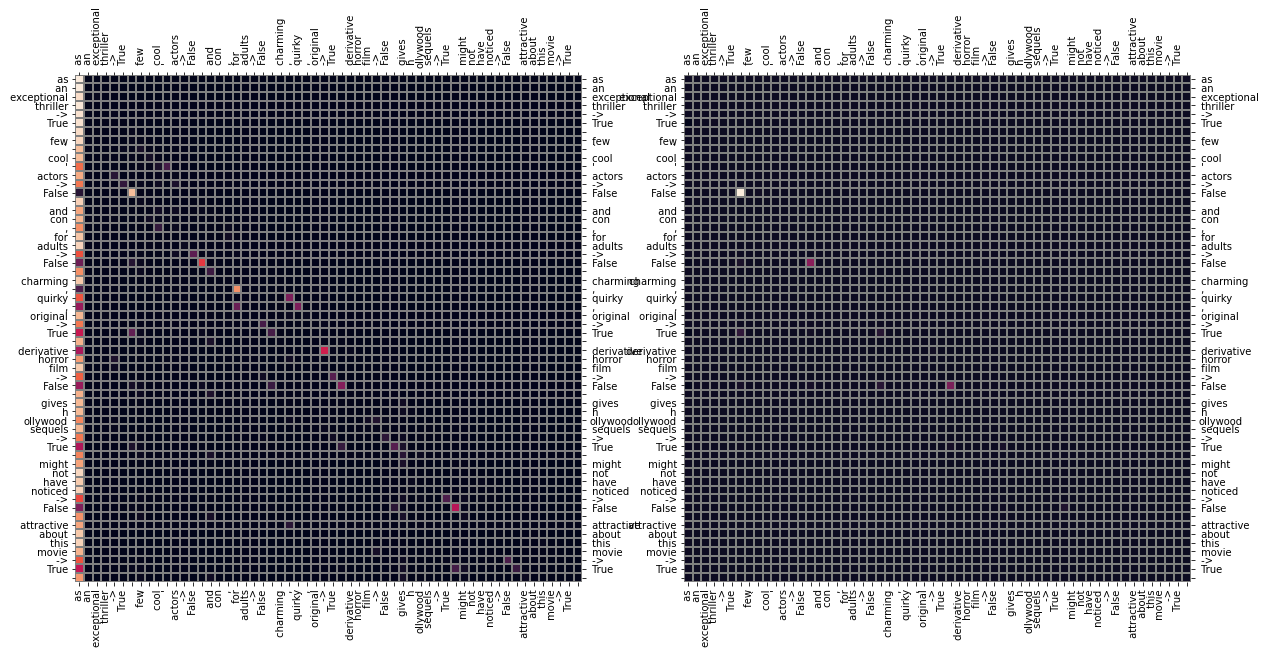

5 5 0.25908968 3


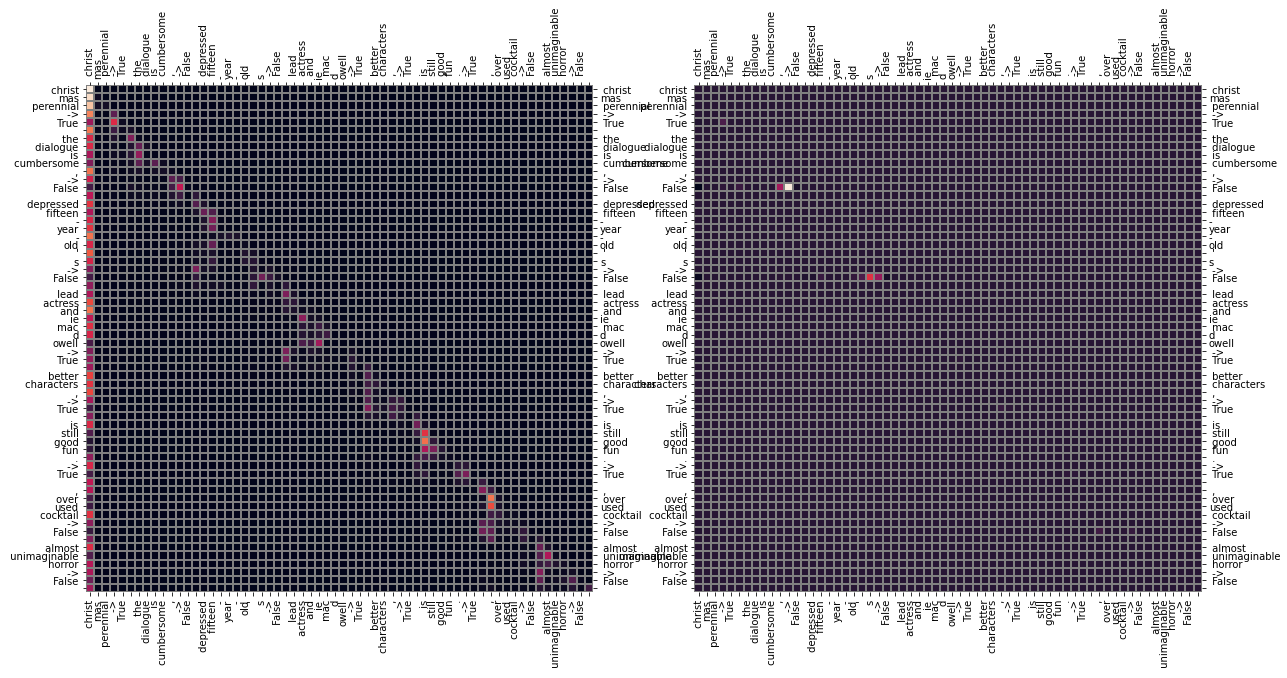

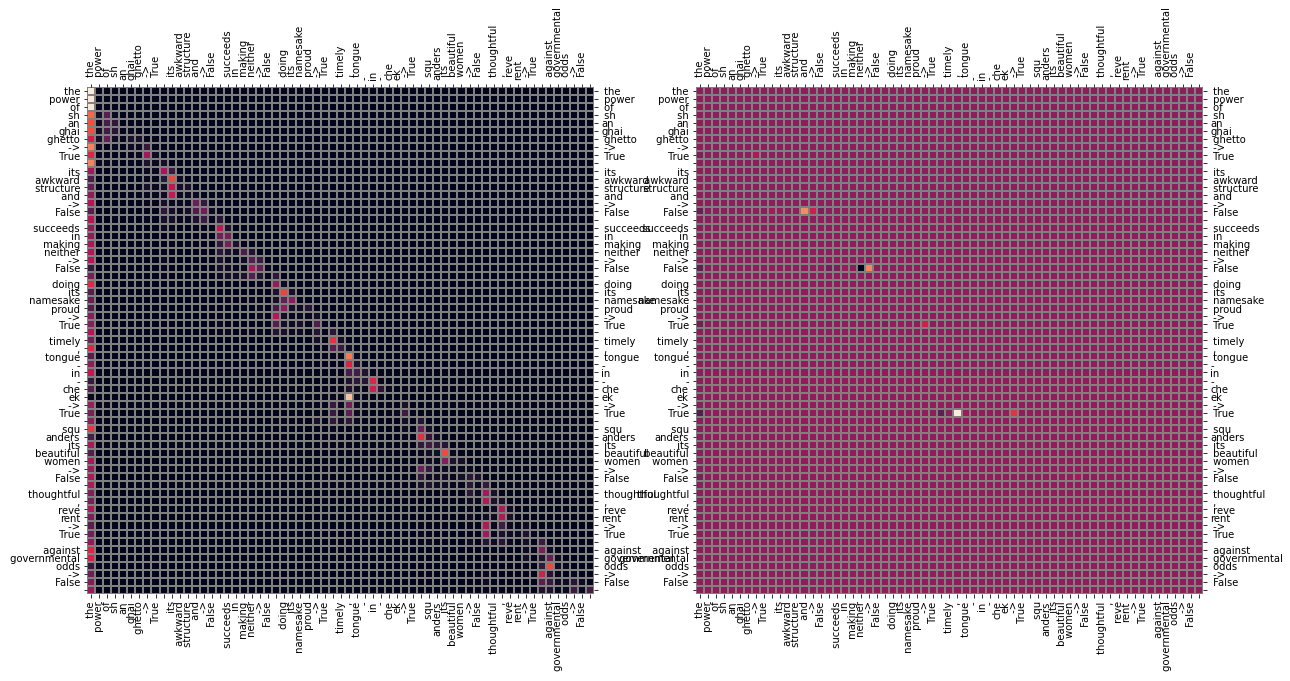

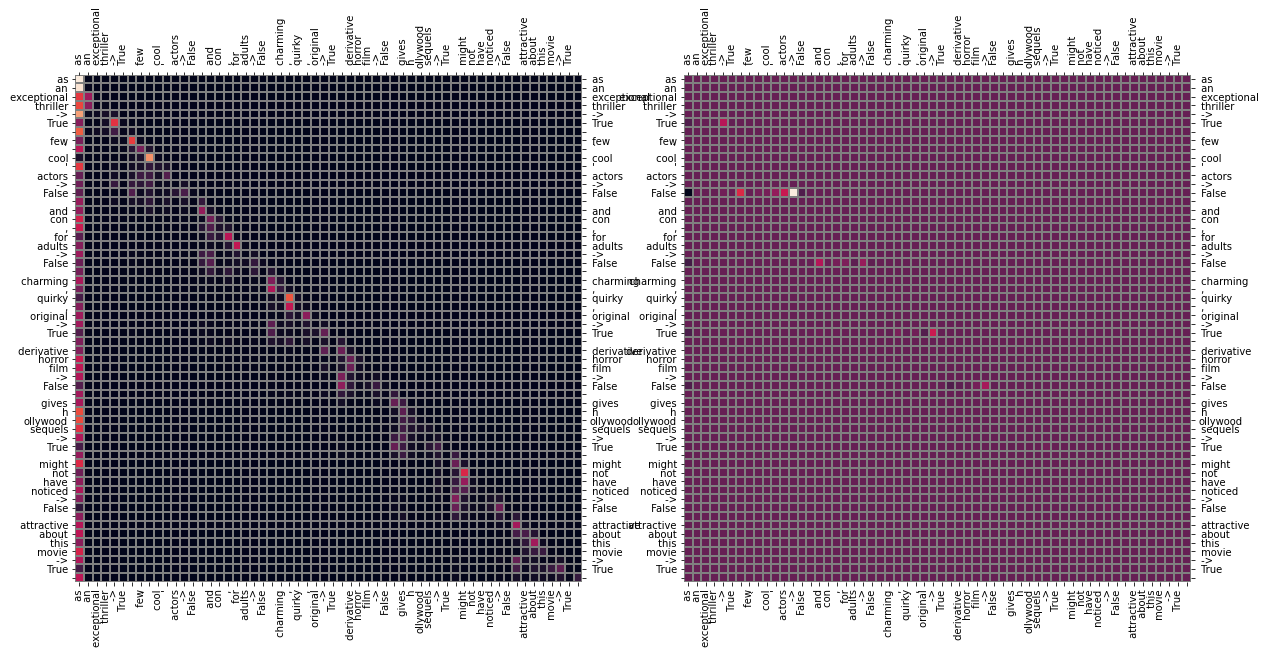

In [1433]:
# attr = nodes[i-1].data.attr
for l, h, v in zip(*topk_md(attr.head, 6)):
    print(l, h, v, get_head_rank(attr2.head, l, h))
#     l = 25
    for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[:3]:
        fns = []; node = nodes[i]
        while node != root: fns.append(node2fn(model, node, o, labels, attn_attr)); node = node.parent
            
        x = OrderedDict((key, get_x(key, o, to_layer=l)) for key in keys)
        fwd_fn = partial(sum_forward, outputs=o)
        fn = partial(head_forward, layer=l, head=h, attn_weights=o.attentions[l],
                            labels=labels if len(fns) == 0 else None)
#         fn = partial(mlp_forward, layer=l, labels=labels)
        post_fwd_fn = compose_forward_fns([fn] + fns, scaled=True)
#         _, ys, logits = attribute(fwd_fn, model, x, post_fwd_fn, num_points=3, batch_size=3); print(ys)
#         print(logits.shape,logits.size(-1) == model.lm_head.out_features)
#not isinstance(logits, Iterable) and 
        if not isinstance(logits, Iterable) and logits.size(-1) == model.lm_head.out_features:
            # 最后一维的logits
            show_predictions(text, examples, tokenizer, logits[-1:], bos_indices, eos_indices, answers, labels, 
                topk=4, show_range=range(k_shot, len(examples)), sep='\t')

        fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))
        for ax, a in zip(axs, [o.attentions[l][0, h], attn_attr[nodes[i].name][l, h]]):
            plot_attn(a, tokens, ax=ax)
        plt.show()

In [7220]:
25-3,22-0,21-4,26-14

SyntaxError: invalid syntax (<ipython-input-7220-d451eee6b972>, line 1)

In [ ]:
for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples:
    temp = attn_attr[nodes[i].name]
    head_attr = torch.einsum('lnij->ln', temp)
    layer, head, _ = list(zip(*topk_md(head_attr, 10)))[0]
    aw_label = binarize(temp[layer, head])
    wq, wk = get_head_weights(model,layer, head)[:2]
    
    query = torch.einsum('bie,de->bid', o.hidden_states[layer], wq)
    head_outputs = rearrange(list(o.head_outputs), 'l 1 n i e -> 1 l n i e')[:, :layer]
    key = torch.einsum('blnje,de->blnjd', head_outputs, wk)
    attn_logits = torch.einsum('bid,blnjd->lnij', query, key) # b==1
    attn_head_attr = rearrange(attn_logits, 'l n i j -> i j l n')[aw_label == 1].mean(0)
    head_inputs_ = rearrange(list(o.head_inputs), 'l 1 n j e -> l n j e')[:layer]
    attentions_ = attentions[:layer]
    if True: # faster version
        key = head_inputs_ @ wk.T  # lnje,de->lnjd
        lnkj_attn_logits = torch.einsum('bkd,lnjd->lnkj', query, key) # b==1
        lnkij_attn_logits = torch.einsum('lnij,lnkj->lnkij', attentions_, lnkj_attn_logits)
    else: # slower version, but easier to understand (similar to unseal)
        lnije = torch.einsum('lnij,lnje->lnije', attentions_[:layer], head_inputs_)
        key = lnije @ wk.T  # lnije,de->lnijd    
        lnkij_attn_logits = torch.einsum('bkd,lnijd->lnkij', query, key)  # b==1
    # kij means k attends i in higher layer, i attends j in lower layer
    attn_attn_attr = torch.einsum('lnkij,ki->lnij', lnkij_attn_logits, aw_label)
    for l, h, v in zip(*topk_md(attn_head_attr, 2)):
        print(l, h, v)
        fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
        for ax, a in zip(axs, [attentions[l, h], attn_attn_attr[l, h], binarize(attn_attn_attr[l, h])]):
            plot_attn(a, tokens, ax=ax)
        plt.show()

In [1321]:
# (attn_attr[nodes[i].name][6, 10] - nodes[i].data.attr.attn[6,10]).float().mean()
layer, head

(12, 10)

In [ ]:
for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples:
    logits = model.lm_head(ln_f(o.head_outputs[16][:, 7] + o.head_outputs[17][:, 9] + o.head_outputs[24][:, 7] + 
                                o.head_outputs[27][:, 5] + o.head_outputs[24][:, 10] + o.head_outputs[14][:, 7]+ 
                                o.head_outputs[13][:, 3]+ o.mlp_outputs[-1]*1 ))
    show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
        topk=4, show_range=range(k_shot, len(examples)), sep='\t')

In [ ]:
# def forward(model, inputs, labels=None, loss_reduction=None, by_head=False, attribute_layer=None, 
#             head_mask=None, mlp_mask=None, attn_weights=None,
#             hidden_states=None, detach_layer=None, 
#             separate_qkv_layer=None, get_hqkv=None):
#     head_mask = fill_list(head_mask, L, attribute_layer)
#     mlp_mask = fill_list(mlp_mask, L, attribute_layer)
#     attn_weights = fill_list(attn_weights, L, attribute_layer)
#     # get_hqkv_fns = fill_list(get_hqkv, L, separate_qkv_layer, default_get_hqkv)
#     from_layer = attribute_layer if hidden_states is not None else None

#     self = model.transformer
#     (hidden_states, inputs_embeds, position_embeds) = embed_forward(self, inputs) \
#         if from_layer is None else (hidden_states, None, None)
#     all_hidden_states, intermediates, mlp_outputs = (), (), ()
#     attn_forward_outputs = []
#     for i, b in enumerate(self.h):
#         if from_layer is not None and i < from_layer: continue
#         if i == detach_layer: hidden_states = hidden_states.detach()
#         all_hidden_states += (hidden_states,)
#         # hq, hk, hv = get_hqkv_fns[i](hidden_states)
#         hq = hk = hv = b.ln_1(hidden_states)
#         attn_forward_output = attn_forward(b, hq, hk, hv, by_head=by_head, compute_head_input=True,
#                                     head_mask=head_mask[i], attn_weights=attn_weights[i])
#         attn_forward_outputs.append(attn_forward_output)
#         if not my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_forward_output[0]
#         mlp_output, intermediate = mlp_forward(b, hidden_states, output_intermediate=True)
#         if mlp_mask[i] is not None: mlp_output = einsum('bie,bi->bie', mlp_output, mlp_mask[i])
#         intermediates += (intermediate,)
#         mlp_outputs += (mlp_output,)
#         if my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_forward_output[0]
#         hidden_states = hidden_states + mlp_output
#     attn_outputs, all_attentions, head_inputs, head_outputs = zip(*attn_forward_outputs)
#     all_hidden_states += (hidden_states,) # both before and after ln_f
#     hidden_states = self.ln_f(hidden_states)
#     all_hidden_states += (hidden_states,)

#     logits = model.lm_head(hidden_states)
#     loss = compute_loss(logits, labels, reduction=loss_reduction) if labels is not None else None
#     return Outputs(
#         inputs_embeds=inputs_embeds, position_embeds=position_embeds,
#         attn_outputs=attn_outputs, head_inputs=head_inputs, head_outputs=head_outputs, 
#         intermediates=intermediates, mlp_outputs=mlp_outputs,
#         hidden_states=all_hidden_states, attentions=all_attentions, 
#         logits=logits, loss=loss,
#     )

In [ ]:
# 对某层的attn_weights单独梯度归因
attrs = []
for attribute_layer in range(27):
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'head_mask': torch.ones(1, H, o.hidden_states[0].size(1))}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y, num_points=8)
    ys
    attrs.append(attr)
    
head_attr2 = rearrange([attr['head_mask'] for attr in attrs], 'l n i -> l n i')
head_attr2 = torch.einsum('lni->ln', head_attr2)
list(zip(*topk_md(head_attr2, 10)))

# 对某层的attn_weights单独梯度归因
for attribute_layer, attribute_head, __ in list(zip(*topk_md(head_attr, 10)))[:3]: # heads 27-17, 17-4, 22-13
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'attn_weights': o.attentions[attribute_layer]}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y)
    # ys
    print(attribute_layer, attribute_head)
    plot_attn(attr['attn_weights'][attribute_head], tokens, figsize=(5, 5))
    plt.show()

In [1286]:
nodes[i].data.attr.attn.shape

torch.Size([28, 16, 32, 32])

In [1301]:
nodes[1].name

'[1] top2 12-10'

In [1292]:
(nodes[i-1].data.attr.attn[6,10] - attn_attr[nodes[i-1].name][6,10]).float().mean()

tensor(-0.0063)

以上用归因找到对最终预测结果起重要作用的上层heads（induction heads），  
以下用归因找到对上层induction heads的attn_weights起重要作用的下层heads（Q-compostion or K-composition with induction heads）

In [1277]:
# 找第2重要的induction head（17-4）的K-composition heads
# layer, head, _ = list(zip(*topk_md(head_attr, 10)))[1]
layer, head
aw_label = binarize(attr.attn[layer, head])
wq, wk = get_head_weights(model,layer, head)[:2]

(6, 10)

In [695]:
# 对head_output归因
query = torch.einsum('bie,de->bid', o.hidden_states[layer], wq)
head_outputs = rearrange(list(o.head_outputs), 'l 1 n i e -> 1 l n i e')[:, :layer]
key = torch.einsum('blnje,de->blnjd', head_outputs, wk)
attn_logits = torch.einsum('bid,blnjd->lnij', query, key) # b==1
# i j l n -> n_label l n -> ln
attn_head_attr = rearrange(attn_logits, 'l n i j -> i j l n')[aw_label == 1].mean(0)

[(1, 3, 350.12573),
 (4, 3, 310.8318),
 (2, 10, 270.55423),
 (1, 1, 255.90451),
 (3, 8, 236.18115),
 (5, 2, 230.12857),
 (0, 7, 189.12363),
 (1, 15, 186.55338),
 (4, 0, 161.37318),
 (0, 12, 149.00491)]

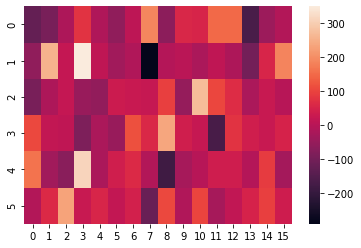

In [696]:
_ = sns.heatmap(attn_head_attr)
list(zip(*topk_md(attn_head_attr, 10)))

In [697]:
# 对attn_weights归因
# h2: a higher-layer (induction) head (layer, head)
# h1: lower-layer heads forming K-composition with h2
# i: h2 query position, j: h2 key position, k: h1 query position
head_inputs_ = rearrange(list(o.head_inputs), 'l 1 n j e -> l n j e')[:layer]
attentions_ = attentions[:layer]
if True: # faster version
    key = head_inputs_ @ wk.T  # lnje,de->lnjd
    lnkj_attn_logits = torch.einsum('bkd,lnjd->lnkj', query, key) # b==1
    lnkij_attn_logits = torch.einsum('lnij,lnkj->lnkij', attentions_, lnkj_attn_logits)
else: # slower version, but easier to understand (similar to unseal)
    lnije = torch.einsum('lnij,lnje->lnije', attentions_[:layer], head_inputs_)
    key = lnije @ wk.T  # lnije,de->lnijd    
    lnkij_attn_logits = torch.einsum('bkd,lnijd->lnkij', query, key)  # b==1
# kij means k attends i in higher layer, i attends j in lower layer
attn_attn_attr = torch.einsum('lnkij,ki->lnij', lnkij_attn_logits, aw_label)

1 3 350.12573


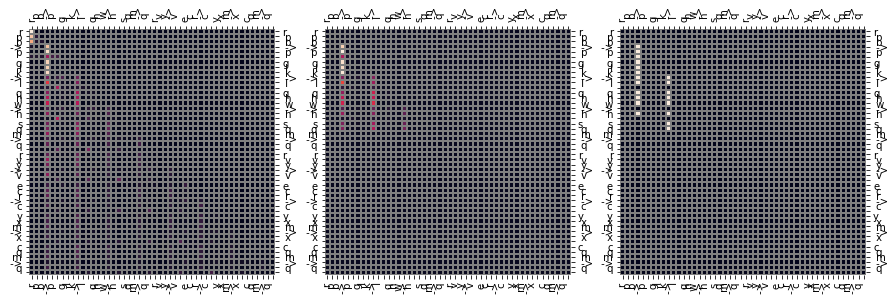

4 3 310.8318


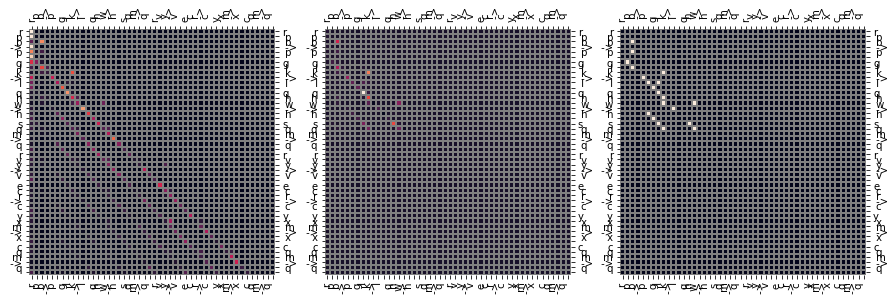

2 10 270.55423


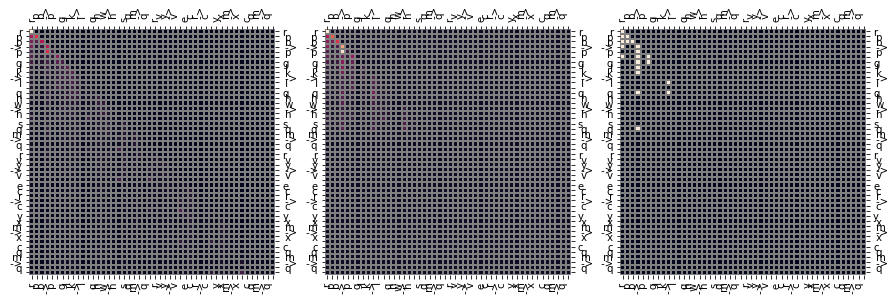

1 1 255.90451


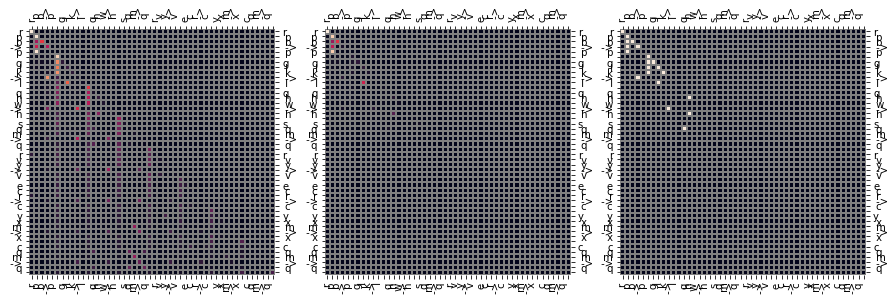

3 8 236.18115


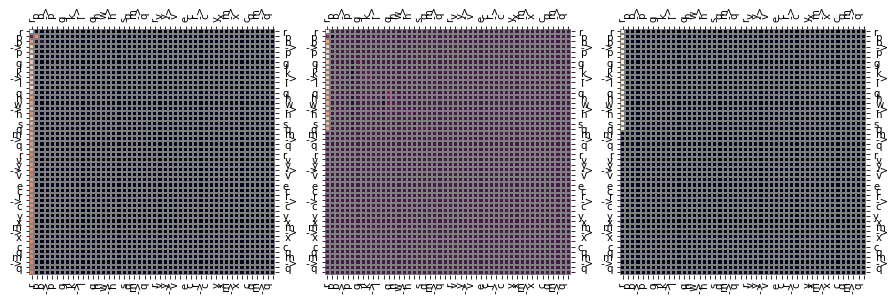

5 2 230.12857


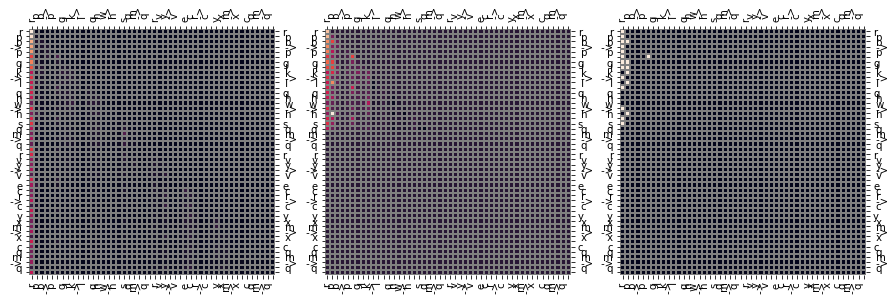

0 7 189.12363


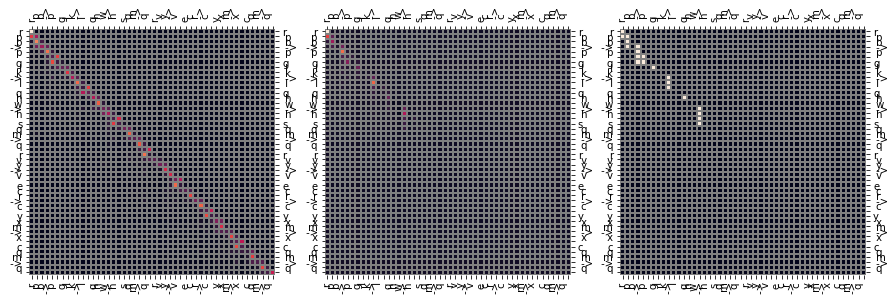

1 15 186.55338


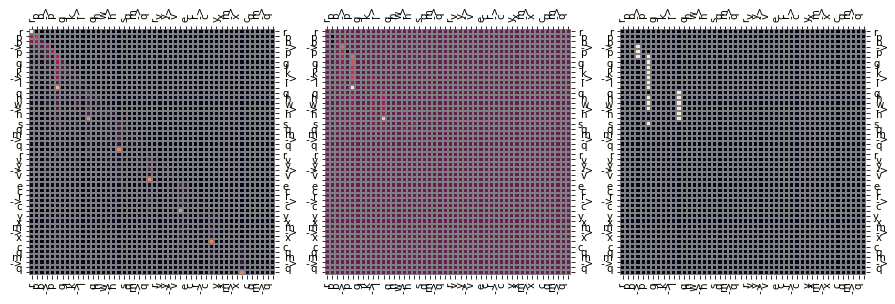

4 0 161.37318


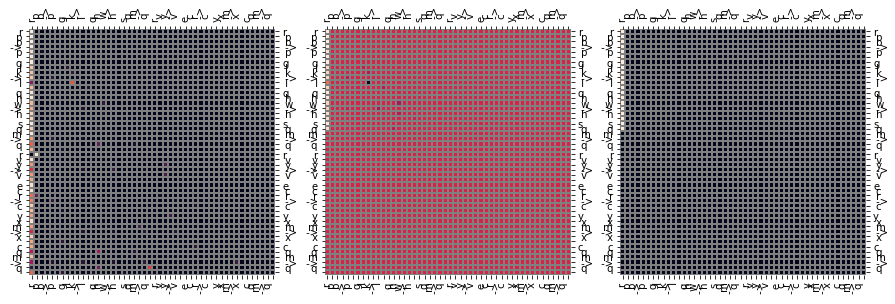

0 12 149.00491


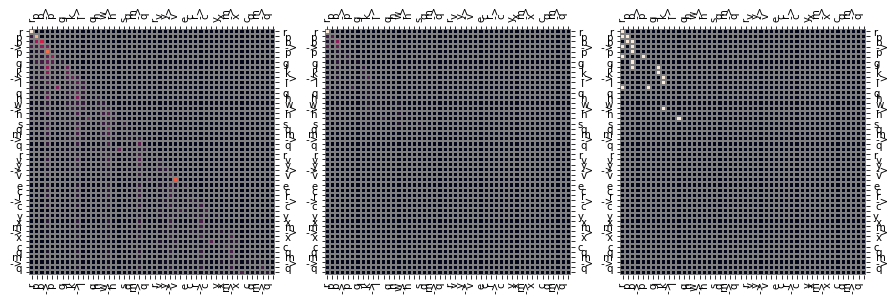

In [698]:
for l, h, v in zip(*topk_md(attn_head_attr, 2)):
    print(l, h, v)
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for ax, a in zip(axs, [attentions[l, h], attn_attn_attr[l, h], binarize(attn_attn_attr[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

In [473]:
all_attrs, all_yss = {}, {}

In [324]:
def qk_forward(model, outputs, layer, head, aw_label, attr_x, **mask_kwarges):
    ln = blocks[layer].ln_1
    kwargs = {x: ln(outputs.hidden_states[layer]) for x in ['hq', 'hk', 'hv']}
    kwargs[attr_x] = scaled_ln(ln, sum_forward(model, outputs, **mask_kwarges).hidden_states[0], scale=0.01) # attr_x in ['hq', 'hk']
    aw = attn_forward(blocks[layer], **kwargs)[1][:, head]
    aw_label_sum = torch.einsum('ij->', aw_label)
    # print('aw_label_sum =', aw_label_sum)
    mean_prob = torch.einsum('bij,ij->b', aw, aw_label) / aw_label_sum
    mean_logprob = torch.einsum('bij,ij->b', (aw + 1e-8).log(), aw_label) / aw_label_sum
    print('mean_prob =', mean_prob)
    print('mean_logprob =', mean_logprob)
    return mean_prob, mean_logprob

In [ ]:
# ig attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y)
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
attrs, yss = all_attrs[key], all_yss[key]

In [ ]:
dlosses = [(ys[0] - ys[-1]).item() for ys in yss]
np.array(dlosses)
_ = plt.bar(range(len(dlosses)), dlosses, 0.3)

In [248]:
# nattrs = [attr / abs(dloss) for attr, dloss in zip(attrs, dlosses)]
nattrs = [attr / attr.abs().mean() for attr in attrs]

In [251]:
mean_nattrs = torch.cat([nattr.mean(dim=-1) for nattr in nattrs])

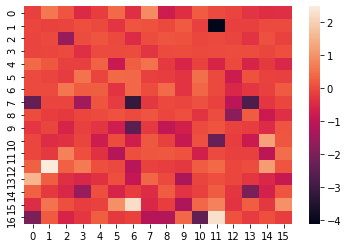

In [252]:
_ = sns.heatmap(mean_nattrs, cbar=True)

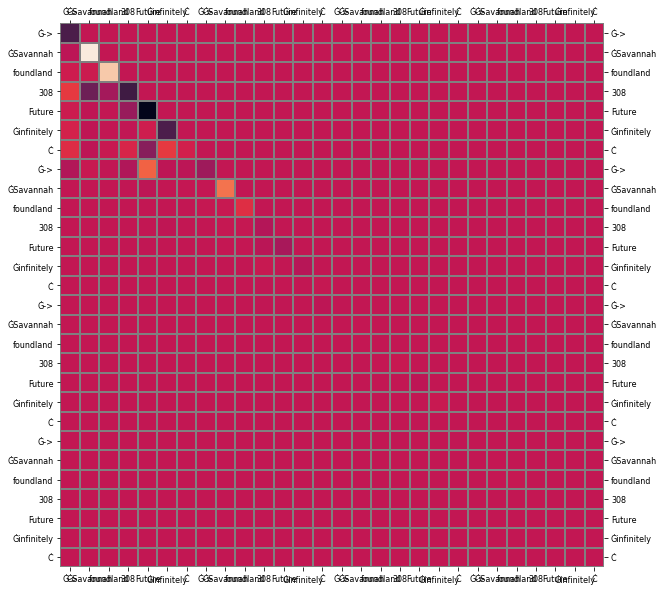

In [320]:
l, h = 6, 6
# attn = o.attentions[l][0, h]
attn = attrs[l][0, h]
plot_attn(attn, tokens)

QK circuit: $W_E^T W_Q^T W_K W_E$  
OV circuit: $W_U W_O W_V W_E$

In [230]:
def plot_eigenvalues(evs, ncols=4):
    fig, axs = plt.subplots(H // ncols, ncols, sharex=True, sharey=True, figsize=(20, 5))
    for i, (e, v) in enumerate(evs):
        e = e.detach().numpy()
        _ = axs[i // ncols][i % ncols].plot(e[:,0], e[:,1], '.')

In [281]:
WQK, WOV = [], []
for l in tqdm(range(L)):
    WQK.append([combine_weights(get_head_weights(l, h), qk=True) for h in range(H)])
    WOV.append([combine_weights(get_head_weights(l, h), qk=False) for h in range(H)])

100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


In [284]:
WQK = [[combine_weights(get_head_weights(l, h), qk=True) for h in range(H)] for l in tqdm(range(L))]
WOV = [[combine_weights(get_head_weights(l, h), qk=False) for h in range(H)] for l in tqdm(range(L))]

100%|██████████| 24/24 [00:01<00:00, 20.26it/s]


In [333]:
# rwqk2, rwov1 = torch.rand(hidden_size, hidden_size) * 10, torch.rand(hidden_size, hidden_size) * 100

# rwq, rwk = torch.rand(hidden_size // H, hidden_size)*10, torch.rand(hidden_size // H, hidden_size)
# rwo, rwv = torch.rand(hidden_size, hidden_size // H), torch.rand(hidden_size // H, hidden_size)*100
# rwqk2, rwov1 = rwq.t().mm(rwk), rwo.mm(rwv)

# rwqk2.mm(rwov1).norm() / (rwqk2.norm() * rwov1.norm())

K-composition: $\text{Id} \otimes A^{h_{-1}} \otimes (W_E^T W_{QK}^h W_{OV}^{h_{-1}} W_E)$, measured by Frobenius norm ratio: $||W_{QK}^{h_2}W_{OV}^{h_1}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F)$

In [345]:
dl = 3
kcomp3 = np.array([[[(WQK[l][h2].mm(WOV[l-dl][h1]).norm() / (WQK[l][h2].norm() * WOV[l-dl][h1].norm())).item() 
          for h1 in range(H)] for h2 in range(H)] for l in tqdm(range(dl, L))])

100%|██████████| 21/21 [01:23<00:00,  3.96s/it]


In [1703]:
def scatter_plot(a): a = a.detach().numpy(); plt.plot(a[:,0], a[:,1], '.')

In [74]:
chains = [
    [(4, 14), (3, 3)],  # 0.24024388
    [(5, 4), (2, 2)],  # 0.21996385
    [(5, 4), (3, 7)],  # 0.31488344
    [(6, 6), (3, 3)],  # 0.27304175
    [(6, 6), (5, 3)],  # 0.12567882
]

In [314]:
(l2, h2), (l1, h1) = chains[4]

In [433]:
e = WQK[l2][h2].mm(WOV[l1][h1]).eig()[0]

In [435]:
e[:10] = 0

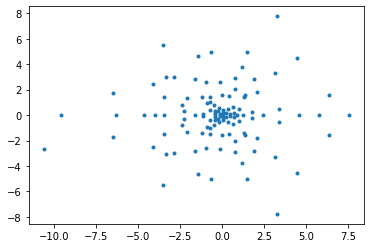

In [436]:
scatter_plot(e)

In [437]:
e = WOV[l2][h2].eig()[0]

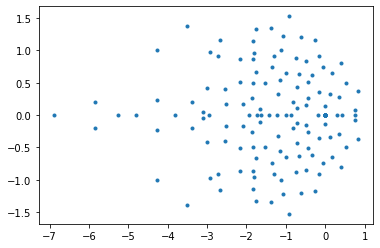

In [438]:
scatter_plot(e)

In [356]:
a = kcomp3[2]; ind = np.unravel_index(a.argmax(), a.shape); ind, a[ind]

((4, 2), 0.21996384859085083)

<AxesSubplot:>

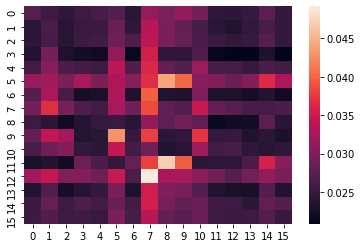

In [319]:
kcomp = np.array(kcomp)
sns.heatmap(kcomp, cbar=True)

In [364]:
wov_evs = [torch.eig(combine_weights(get_head_weights(3, h), qk=False, with_embedding=True, BA=True)) for h in tqdm(range(H))]

100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


  0%|          | 0/16 [3:32:06<?, ?it/s]


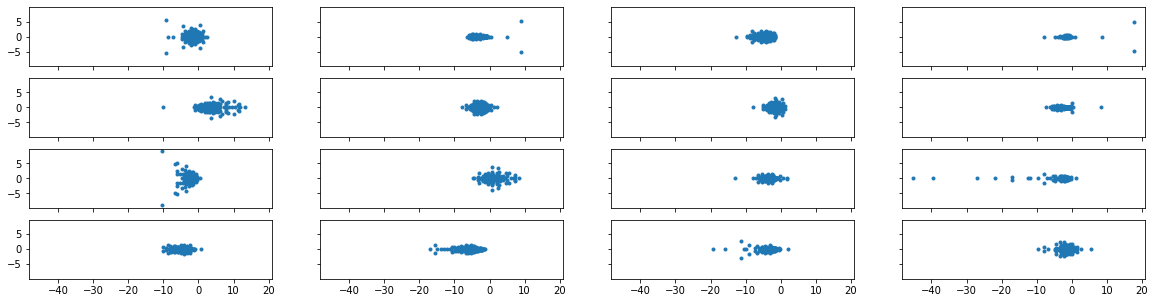

In [363]:
plot_eigenvalues(wov_evs)

In [138]:
w_eu = w_e.matmul(w_u)

In [522]:
def mlp(layer): return lambda x: blocks[layer].mlp(blocks[layer].ln_2(x))
def mlp0(layer): return lambda x: blocks[layer].mlp(x)

In [186]:
def attn(layer): return lambda x: blocks[layer].attn(blocks[layer].ln_1(x))

In [537]:
w_e2 = w_e * 50
w_eu2 = (w_e2 + mlp0(L-1)(w_e2)).matmul(w_u)

In [ ]:
# grad attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y);
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
plot_attn(globalize(attentions[8])[0, 2], figsize=(20, 20))

In [5395]:
for i, token in enumerate(tokens):
    if token in ['Ċ', '^']: print()
    else: print('%2d %s' %(i, token), end='  ')
tgt_positions


 1 E   2 N   3 K   4 R   5 ->   6 N  
 8 A   9 T  10 D  11 7  12 ->  13 T  
15 Q  16 A  17 P  18 K  19 ->  20 A  
22 A  23 N  24 L  25 5  26 ->  27 N  
29 V  30 1  31 P  32 B  33 ->  34 1  
36 G  37 V  38 7  39 4  40 ->  41 V  
43 R  44 Y  45 J  46 P  47 ->  48 Y  
50 A  51 C  52 S  53 Y  54 ->  55 C  


tensor([ 2,  9, 16, 23, 30, 37, 44, 51])

In [5409]:
a = all_attrs[task_name]['aw' + str(int(pred_attn))]
a = a / a.view(a.size(0), -1).norm(dim=1)[:, None, None, None] #.view(a.size(0), 1, 1, 1)
if not pred_attn:
    src_indices, tgt_indices = [src], [tgt]
    _a = a[:, :, src_indices, tgt_indices]
    values, indices = _a.view(_a.size(0), H, -1).topk(1, dim=-1)
    show_top_heads(values, indices, src_indices=src_indices, tgt_indices=tgt_indices)
    print()
# src_indices = numpy(ans_positions[:])
# src_indices = numpy(tgt_positions + 1)
# tgt_indices = tgt_positions
_a = a[:, :, src_indices, :]
values, indices = _a.view(_a.size(0), H, -1).topk(nrows // 2, dim=-1)
show_top_heads(values, indices, src_indices=src_indices)#, tgt_indices=tgt_indices)

16-15	0.918 [(51, 0.918, 66.8)]	0.13030353 *0.66812056 0.011132528 0.0006797812 
14-0	0.783 [(51, 0.783, 66.5)]	0.14255618 *0.6645065 0.019694159 0.0019851688 
17-13	0.705 [(51, 0.705, 49.8)]	0.18755053 *0.49829417 0.078217894 0.10344336 
13-2	0.505 [(51, 0.505, 44.5)]	0.43078056 *0.44530356 0.017190581 0.001503151 
17-17	0.213 [(51, 0.213, 40.9)]	0.16368316 *0.4086181 0.24944614 0.11208218 
14-13	0.192 [(51, 0.192, 32.8)]	0.20337617 *0.32792574 0.07777147 0.073093265 
15-8	0.159 [(51, 0.159, 22.5)]	0.15539594 *0.22527154 0.26876858 0.27620015 
14-16	0.101 [(51, 0.101, 26.3)]	0.11579089 *0.2628595 0.104256935 0.014017421 
15-16	0.099 [(51, 0.099, 13.2)]	0.13631786 *0.1315605 0.098822616 0.30740336 
13-12	0.095 [(51, 0.095, 13.1)]	0.44031265 *0.13147357 0.035518978 0.05850061 
13-3	0.078 [(51, 0.078, 34.5)]	0.46285912 *0.34470326 0.08684665 0.0354087 
7-2	0.062 [(51, 0.062, 27.9)]	0.105706446 *0.2786354 0.16776893 0.2326701 
17-1	0.047 [(51, 0.047, 46.0)]	0.38024765 *0.45963302 0.023335

In [5408]:
def show_top_heads(values, indices, src_indices=None, tgt_indices=None, topk=15):
    val, ind = values.sum(dim=-1).view(-1).topk(topk)
    val, ind = numpy(val), unravel_index(ind, values.size()[:-1])
    for (l, h), v in zip(ind, val):
        _l = l + layer_range[0]
        if _l <= 3: continue
        top_links = list(zip(unravel_index(indices[l, h], (seq_len, seq_len)), numpy(values[l, h], decimals=3)))
        if src_indices is not None: top_links = [([src_indices[_s], _t], _v) for [_s, _t], _v in top_links]
        if tgt_indices is not None: top_links = [([_s, tgt_indices[_t]], _v) for [_s, _t], _v in top_links]
        top_links = [([_s, _t], _v, numpy(globalize(attentions[_l]) * 100, decimals=1)[0, h, _s, _t]) for [_s, _t], _v in top_links]
        _top_links = [([_s, _t], _v, _a) if len(src_indices) > 1 else (_t, _v, _a) for [_s, _t], _v, _a in top_links]
        print('%d-%d\t%.3f' % (_l, h, v), _top_links, end='\t') 
        if len(top_links) == 1:
            probs = numpy(globalize(attentions[_l])[0, h, src])
            for i in cand_range:
                if i == tgt: print('*', end='')
                print(probs[i], end=' ')
        print()

tensor([0.6156])


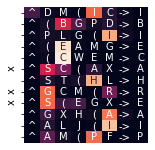

In [5057]:
a = globalize(attentions[layer2])[:, head2]
# a = a.softmax(-1)
a = torch.cat([a[:, i - 1: i, i - ncols - 2: i + 1] for i in ans_positions], dim=1)
# a = a.softmax(-1)
loss = a.view(a.size(0), -1)[:, tgt_positions[1:]].mean(dim=1)
print(loss)
plot_tgt_attn(a[0])

In [3455]:
wvos = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(11, 8), (12, 18)]]
wqk = torch.matmul(*get_head_weights(13, 2)[:2])
ww = wvos[0].matmul(wvos[1]).matmul(wqk)

In [3735]:
ww.norm(dim=0).topk(40).indices

tensor([2484,   88,  578, 1781,  586,  408, 2054,  304,  824, 1675, 1772,  501,
        2456, 1019,  936, 2463, 2368,  340, 2418,  101, 1734,  687, 2159, 1060,
          20, 1838,  224, 1669, 1187,  870, 1585,  232,  281, 1474, 1729,  328,
        1860, 1174,  816, 1524])

In [3741]:
show_topk(*aw.view(-1).topk(20, largest=False), indices_fn=indices_fn)

{(578, 586): -0.0016085216,
 (578, 88): -0.0011706072,
 (936, 1782): -0.0011014504,
 (578, 501): -0.0009034774,
 (578, 114): -0.00086396607,
 (578, 1761): -0.00080681103,
 (578, 1067): -0.0007989705,
 (936, 814): -0.00079893926,
 (936, 405): -0.00076955673,
 (936, 336): -0.0007586547,
 (578, 2149): -0.00074234203,
 (578, 1666): -0.0007264766,
 (578, 408): -0.00071433355,
 (578, 1019): -0.00066249806,
 (936, 946): -0.00065255526,
 (2484, 1675): -0.00064498984,
 (578, 1675): -0.0006330121,
 (578, 1651): -0.00062471436,
 (936, 1445): -0.00062095723,
 (578, 289): -0.0006184878}

In [4065]:
wvos2 = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(9, 9), (10, 1), (12, 18)]]
ww2 = reduce(torch.matmul, wvos2 + [wqk])

In [5015]:
attn_output1, out = None, None
out_proj_w = self1.out_proj.weight.view(hidden_size, H, -1).permute(1, 2, 0).unsqueeze(0)
head_mask = torch.zeros(H, seq_len, seq_len)
head_mask[[18,]] = 1
# head_mask[:] = 1
attn1 = attentions[layer1]
_attn1, __attn1 = torch.zeros_like(attn1), torch.zeros_like(attn1)
for i in range(0, nrows):
    _attn1[:, :, arrow_positions[i], ans_positions[i]] = 1
    __attn1[:, :, arrow_positions[i], ans_positions[:i]] = 1 / i if i > 0 else 0
    
def ffn(layer, x): return blocks[layer].mlp(blocks[layer].ln_2(x))

def tgt_attn_loss(h1, attn1, key0, residual=None, attn_output_w=1, apply_softmax=True, temperature=10, 
                  positions=tgt_positions, plot=False, ax=None):
    def get_attn(attn_output):
        out = (residual if residual is not None else 0) + attn_output * attn_output_w
        if residual is not None: out = out + ffn(layer1, out)
        if residual is not None: out = ln2(out)
        query = out.matmul(wq2.t()).unsqueeze(2) # (bsz, nrows, d_head) -> (bsz, nrows, 1, d_head), ln2 is omissible
        key = key0.matmul(wk2.t()).view(bsz, nrows, ncols + 3, hidden_size // H)
        a = (query * key).sum(-1) # (bsz, nrows, ncols + 3)
        a[:, :, [-1]] = -1e9
        if apply_softmax: a = (a / temperature).softmax(-1)
        return a

    self1.w = attn1 * head_mask; attn_output1 = self1(h1)[0] - self1.out_proj.bias
    a = get_attn(attn_output1[:, arrow_positions])
    loss = a.view(a.size(0), -1)[:, positions]
    if plot:
#         a = a - a.min(dim=2, keepdim=True).values
        plot_tgt_attn(a[0], ax=ax)#; print(loss)
    return loss.mean()

residual = None or hidden_states[layer1][:, arrow_positions]

[0.7721180319786072, 0.9933991432189941, 0.9961371421813965]

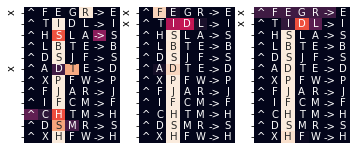

In [5052]:
def get_ln(layer): return blocks[layer].ln_1
# 10-ffn, 9-11 for find special, 9-11 for AbCD->B/b, 9-11 for ABCD->C
# 10-19+ffn+8!, 9-11 for after bracket 5-5/7, 9-11, 10-1+13+ffn+8+19 for in brackets
mask = torch.zeros(H, seq_len, 1); mask[11] = 1#; mask[:] = 0 # 11-8, 10-1, 9-11,   9-11/6?->8-17 for 2nd
# for i in range(0, nrows): mask[1, ans_positions[i], tgt_positions[i]+1] = 1
layer0 = 9
self0, ln0 = get_attn_module(blocks[layer0]), blocks[layer0].ln_1

h0 = hidden_states[9]*0 + head_outputs[8][:, [17]].sum(1)*1
self0.w = attentions[layer0] * mask; attn_output0 = self0((h0), attention_masks[layer0])[0] - self0.out_proj.bias
# h1 = hidden_states[9]*0 + head_outputs[11][:, [8]].sum(1)*1 #+ ffn_outputs[10]#+ head_outputs[11][:, [8,]].sum(1)*1
# h1 = ln1(h1)
h1 = attn_output0
key0 = get_ln(10)(hidden_states[10])#; key0.reqires_grad = True; key0.retain_grad()
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24))
# loss = tgt_attn_loss(h1, __attn1, key0, residual=None, plot=True, apply_softmax=True, temperature=1, ax=axes[0]); loss
# print('after', key0[:, :, 0])
[tgt_attn_loss(h1, attn, key0, residual=None,plot=True,temperature=1, positions=tgt_positions[(i>0)*2:],ax=ax).item() 
    for i, (attn, ax) in enumerate(zip([_attn1, attn1, __attn1], axes))]
# if losses[0] > 0.8 and losses[-1] > 0.8: print(layer, head, losses)

In [5075]:
def get_weight_norm(w):
    return w.abs().mean().item()

In [5083]:
wvo1 = get_combined_w(9, 11) * get_combined_w(12, 18)
for layer in [8, ]:
    for head in range(H):
        wvo = get_combined_w(layer, head)
        print('%d-%d %.4f %.4f' % (layer, head, get_weight_norm(wvo.matmul(wvo1)) / get_weight_norm(wvo), get_weight_norm(wvo.matmul(wvo1))))

8-0 0.0865 0.0030
8-1 0.0865 0.0016
8-2 0.0866 0.0026
8-3 0.0870 0.0027
8-4 0.0867 0.0019
8-5 0.0873 0.0022
8-6 0.0874 0.0027
8-7 0.0867 0.0023
8-8 0.0867 0.0021
8-9 0.0879 0.0026
8-10 0.0874 0.0023
8-11 0.0866 0.0024
8-12 0.0870 0.0024
8-13 0.0868 0.0023
8-14 0.0866 0.0017
8-15 0.0870 0.0023
8-16 0.0874 0.0029
8-17 0.0865 0.0014
8-18 0.0876 0.0025
8-19 0.0866 0.0024


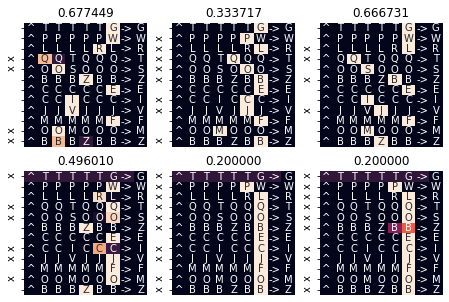

In [4950]:
front_chains = [
    [[(11, 8), create_mask(ans_positions, tgt_positions)]],
    [[(9, 9), create_mask(tgt_positions + 1, tgt_positions)], [(10, 1), create_mask(ans_positions, tgt_positions + 1)]],
]
rear_chains = [
    [[(12, 18), create_mask(arrow_positions, ans_positions)], [(13, 2), None]],
    [[(12, 18), create_mask(arrow_positions, ans_positions, accum=True)], [(13, 2), None]],
]

sum_a = {i: 0 for i in range(len(rear_chains))}
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for j, front_chain in enumerate(front_chains):
    l0 = front_chain[0][0][0]
    h = h0 = get_ln(l0)(hidden_states[l0])
    for (layer, head), mask in front_chain:
#         attn = globalize(attentions[layer])[:, head] #if layer in [9] else mask
        attn = mask
        wvo = get_combined_w(layer, head)
        h = attn.matmul(h.matmul(wvo))
    for i, rear_chain in enumerate(rear_chains):
        (layer, head), mask = rear_chain[0]
        attn = mask
        wvo = get_combined_w(layer, head)
        q = attn.matmul(h.matmul(wvo))
        wqk = get_combined_w(*rear_chain[-1][0], qk=True)
        q = q.matmul(wqk)[:, arrow_positions].unsqueeze(2)
        k = h0.view(h0.size(0), nrows, ncols + 3, hidden_size)
        a = q.matmul(k.transpose(-1, -2)).squeeze(2) / 1
        a[:, :, [-1]] = -1e9
        sum_a[i] = sum_a[i] + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j], title='%f' % loss.item())

for i in range(len(rear_chains)):
    a = sum_a[i]
    a = a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2], title='%f' % loss.item())

In [4602]:
_sattn, __sattn = torch.zeros(1, seq_len, seq_len), torch.zeros(1, seq_len, seq_len)
for i in range(0, nrows):
    _sattn[:, arrow_positions[i], tgt_positions[i]] = 1
    __sattn[:, arrow_positions[i], tgt_positions[:i]] = 1 / i if i > 0 else 0

0.157 0.497 0.250 
0.100 0.809 0.264 


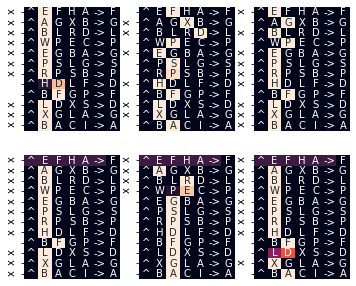

In [4605]:
ww0 = torch.eye(hidden_size)
# layer = 9; ln = blocks[layer].ln_1
# h0 = key0 = ln(hidden_states[layer])
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for i, attn in enumerate([_sattn, __sattn]):
    sum_a = 0
    for j, (w, layer) in enumerate([(ww, 11), (ww2, 9)]):
        ln = blocks[layer].ln_1
        h0 = key0 = ln(hidden_states[layer])
        query = attn.matmul(h0)[:, arrow_positions].matmul(w).unsqueeze(2)
        key = key0.view(key0.size(0), nrows, ncols + 3, hidden_size)
        a = (query * key).sum(-1) / 1
        a[:, :, [-1]] = -1e9
        sum_a = sum_a + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j])
    a = sum_a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2])
    print()

In [3719]:
aw = ww * ww.grad

In [3721]:
aw.norm(dim=0).topk(10)

torch.return_types.topk(
values=tensor([0.0037, 0.0029, 0.0027, 0.0025, 0.0023, 0.0023, 0.0018, 0.0016, 0.0016,
        0.0016], grad_fn=<TopkBackward>),
indices=tensor([  88,  586, 2484,  408, 1782,  578, 1781, 1019,  405, 1761]))

In [4962]:
head_outputs[9][0, :, ans_positions].norm(dim=-1).mean(-1).topk(10)

torch.return_types.topk(
values=tensor([12.2424, 11.6219, 11.3335, 10.7489,  9.3170,  9.2139,  8.5213,  7.5385,
         6.7957,  6.3538]),
indices=tensor([ 9, 19, 11,  7, 14,  6,  4, 10,  0,  8]))

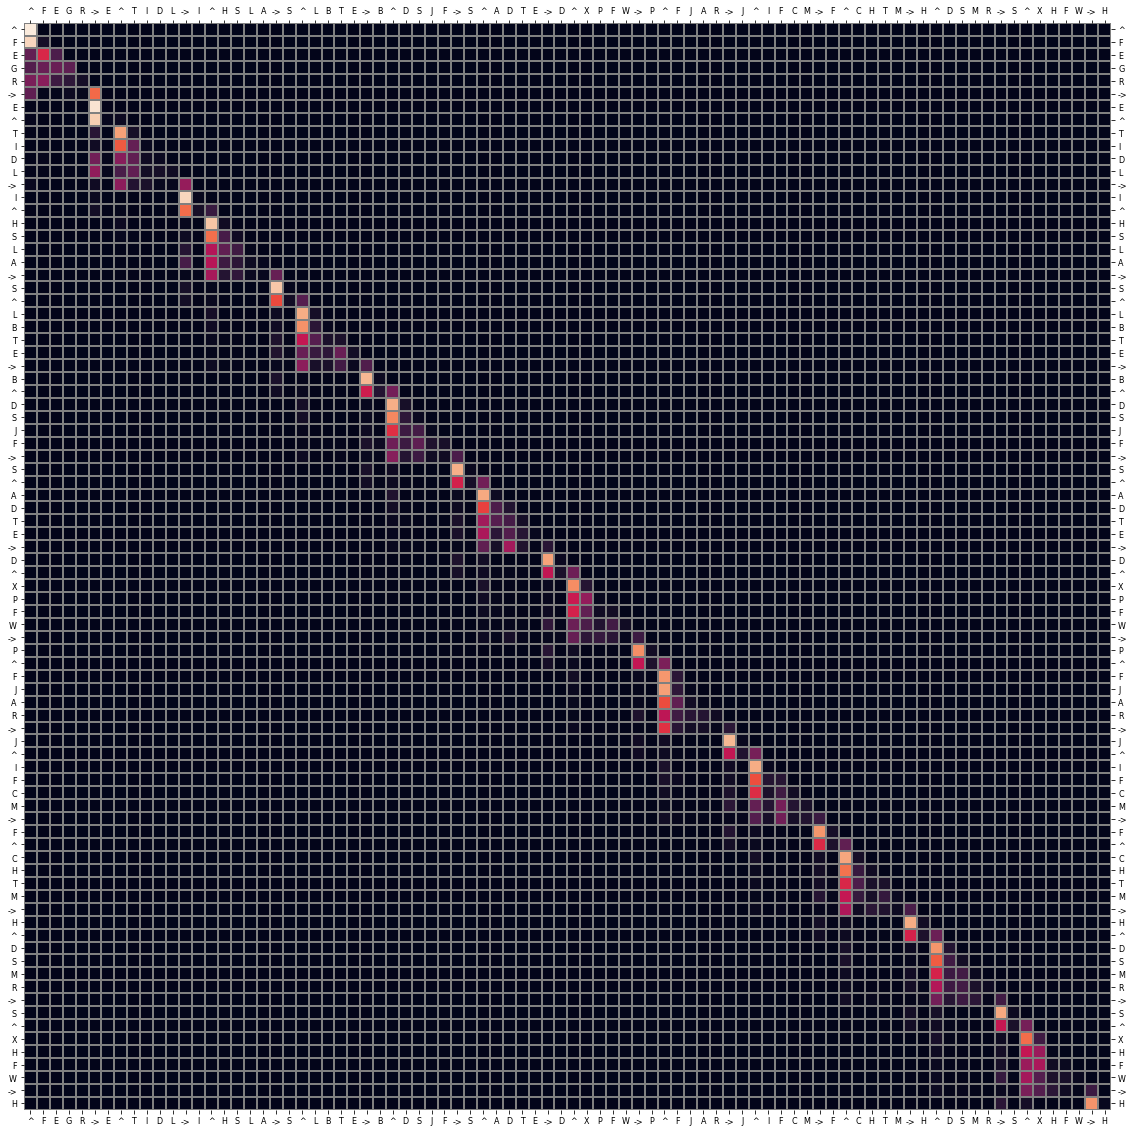

In [5037]:
plot_attn(globalize(attentions[9])[0, 6], figsize=(20, 20))

In [3360]:
a0 = head_outputs[9][0, 11, ans_positions]
a1 = head_outputs[11][0, 8, ans_positions]

In [3362]:
a0 = attrs['head_output'][9, 11, ans_positions]
a1 = attrs['head_output'][11, 8, ans_positions]

In [3363]:
cos = nn.CosineSimilarity(dim=1)
cos(a0, a1)

tensor([0.0226, 0.1145, 0.0712, 0.1595, 0.0533, 0.0150, 0.1125, 0.1410, 0.0172,
        0.0142, 0.0040, 0.0719])

In [3336]:
attr = attrs['attn_output'].sum(-1)
attr = attr / attr.view(attr.size(0), -1).norm(dim=1)[:, None]

<AxesSubplot:>

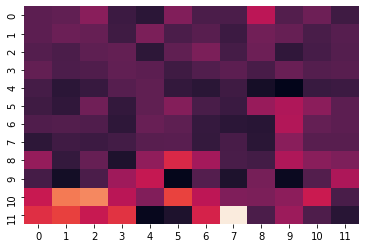

In [3337]:
sns.heatmap(numpy(attr[:, ans_positions]), cbar=False)

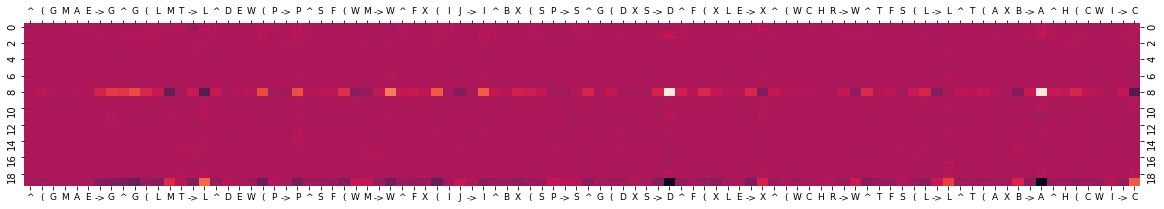

In [3887]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attrs['head_output'].sum(-1)[10]), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

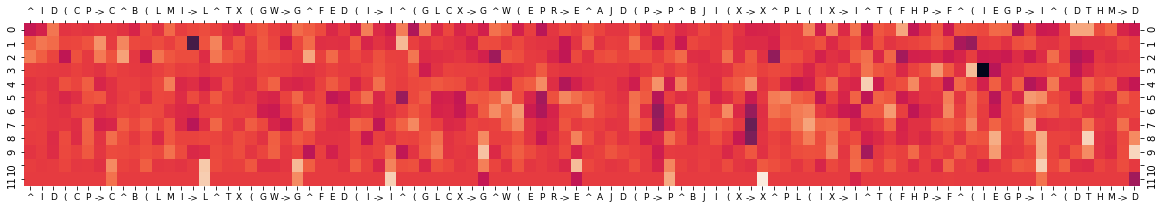

In [3303]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attr), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

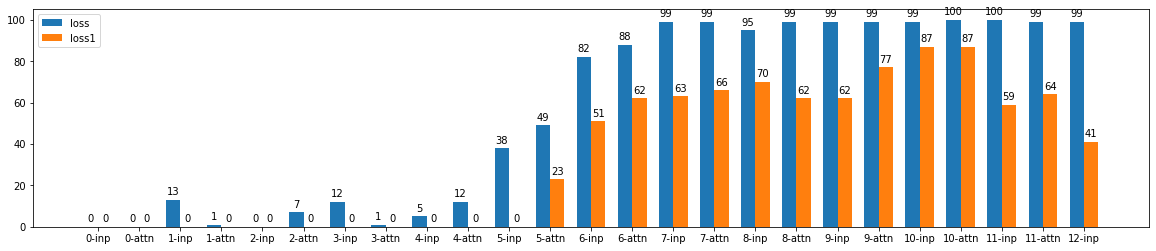

In [616]:
ffn_w = 0
results = []
for i in range(0, layer1 + 1):
    h1 = hidden_states[i] - hidden_states[0]*1
    residual = None #or hidden_states[layer1][:, arrow_positions]
    losses = [tgt_attn_loss(h1, attn, residual=residual, ffn_w=ffn_w) for attn in [_attn1, attn1]]
    results.append(('%d-inp' % i, losses[0], losses[1]))
    if i < layer1:
        losses = [tgt_attn_loss(h1 + attn_outputs[i], attn, residual=residual, ffn_w=ffn_w) 
                  for attn in [_attn1, attn1]]
        results.append(('%d-attn' % i, losses[0], losses[1]))
plot_tgt_attn_losses(*zip(*results))

10 tensor(0.2207, grad_fn=<MeanBackward0>)


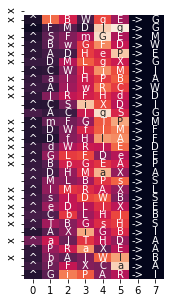

In [2149]:
a = []
tgt_h = hidden_states[layer0][0, tgt_positions]
h0 = hidden_states[layer0].view(nrows, ncols + 3, hidden_size)
for i in range(nrows):
    q = tgt_h[0:i].mean(dim=0)
    q = ln2(q).matmul(wq2.t())
    k = ln2(h0[i]).matmul(wq2.t())
#     attn1 = globalize(attentions[layer1]) * head_mask
#     attn_output1 = torch.matmul(attn1, _head_output1).sum(1)
#     q = ln2(attn_output1[:, arrow_positions[i]]).matmul(wq2.t())
#     q = ln2(_attn_output1[:, ans_positions][:, i:i+1].mean(1)).matmul(wq2.t())
#     k = key[i]
    a.append((q * k).sum(-1).unsqueeze(0))  # == torch.matmul(q, k.t())

a = torch.cat(a)
a[:, -2:] = -1000000
a = a.softmax(-1)
plot_tgt_attn(a)

In [3153]:
layer1, head1 = 12, 18
layer0, head0 = 11, 8
layer2, head2 = 13, 2  #17-4 for A[B]C->B,A*BC->B, 13-5 for reverse set diff
self0, self1, self2 = get_attn_module(blocks[layer0]), get_attn_module(blocks[layer1]), get_attn_module(blocks[layer2])

h_mask = torch.ones(hidden_size)
h_mask[top_i[0]] = 0

ln0, ln1, ln2 = blocks[layer0].ln_1, blocks[layer1].ln_1, blocks[layer2].ln_1
# mean, var = forward(blocks[layer2], 'ln1_mean_var')

wq0, wk0, wv0, wo0 = get_head_weights(layer0, head0)
wq1, wk1, wv1, wo1 = get_head_weights(layer1, head1)
wq2, wk2, wv2, wo2 = get_head_weights(layer2, head2)

In [3396]:
attn_output0, ffn_output0 = forward(blocks[layer0], ['attn_output', 'ffn_output'], exit_module=blocks[layer0],
                                    extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])
head_output0 = forward(get_attn_module(blocks[layer0]), 'head_output', exit_module=blocks[layer0],
                        extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])

10


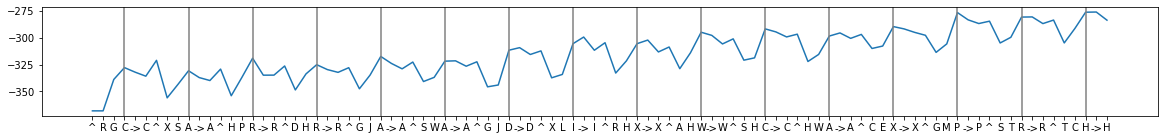

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
 tensor(1.0000, grad_fn=<MeanBackward0>)


In [1202]:
## h1 = ln1(hidden_states[10]*0 + attn_output0 * 1 + ffn_output0 * 1)
h1 = ln1(hidden_states[layer0]*1 + attn_outputs[10]*1 + ffn_outputs[10] * 1 + attn_outputs[11] * 1 + ffn_outputs[11] * 1)

self1.head_output, self1.attn_output = None, None
self1.w = attentions[layer1]
try: _ = self1(h1, attention_mask=attention_masks[layer1])
finally:
    head_output1, attn_output1 = getdelattr(self1, 'head_output'), getdelattr(self1, 'attn_output')
    try_delattr(self1, 'w')

query = get_query(self2, ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*0))
# query = get_query(self2, ln2(head_output1[:, [16, 18]].sum(1)))
# query = get_query((self2, head_outputs[layer1][:, head1]))
# query = get_query(self2, attn_hidden_states[layer2])
for layer in [layer0]:#range(layer2 + 1):
    key2 = get_key(self2, ln2(hidden_states[layer]))
#     key2 = get_key(self2, ln2(attn_outputs[9]))
    logits = (query * key2).sum(dim=-1)
    print(layer)
    _ = test(None, None, logits=logits, always_show=True)

In [73]:
emb = all_embs[task_name][key]
emb_attr = all_attrs[task_name][key + str(int(pred_attn))]

In [2881]:
layer0 = 10
# layer, head = 10, 8  # ABC->B, ABC->A(pred_attn<12-18), ABC->C(only pred_attn), find lowercase, set diff2(only pred_attn)
layer, head = 12, 18 # 12-16, 12-18, 12-1 ABC->A, ABC,AXC->X, set diff2, set diff
layer2, head2 = 13, 2  # ABC->B, ABC->A, ABC->C, ABC,AXC->X, set diff, set diff2(<13-12), find lowercase(<15-8)
# layer2, head2 = 15, 8  # 15-8, find lowercase
# layer2, head2 = 13, 12  # set diff2, ABC,AXC->X(<13-2)

In [483]:
positions = tgt_positions[1:]
offsets = [torch.zeros_like(positions) - 1, torch.zeros_like(positions), torch.zeros_like(positions) + 1]
labels = numpy(torch.cat(offsets))
for layer in range(layer2):
    for head in range(H):
        emb = numpy(torch.cat([attn_outs[layer][0, head, positions + offset] for offset in offsets]))
#         emb = numpy(torch.cat([head_outputs[layer][0, head, positions + offset] for offset in offsets]))
        head_output = head_outputs[layer][:, head]
        if cluster(emb, labels)[0]:# and test(head_output, always_show=False) is not None:
#         if test(head_output, always_show=False) is not None:
            visualize_by_pca(emb, labels)
#             attn = globalize(attentions[layer])[0, head]
#             plot_attn(attn)
            print(layer, head)

(tensor([0.0174, 0.0392, 0.0546, 0.0641, 0.0408, 0.2807, 0.1289, 0.1209, 0.0977],
        grad_fn=<IndexBackward>),
 tensor(0.8444, grad_fn=<SumBackward0>))

(tensor([0.6571, 0.1062, 0.3671, 0.5548, 0.2617, 0.7426, 0.6988, 0.5396, 0.8236,
         0.6873], grad_fn=<SelectBackward>),
 tensor(0.5439, grad_fn=<MeanBackward0>))

(tensor([1.1355e-16, 3.7752e-13, 7.8185e-12, 6.1335e-10, 5.1372e-08, 3.3332e-06,
         3.1391e-04, 5.4327e-03, 1.5451e-01, 5.4892e-01],
        grad_fn=<IndexBackward>),
 tensor(0.0709, grad_fn=<MeanBackward0>))

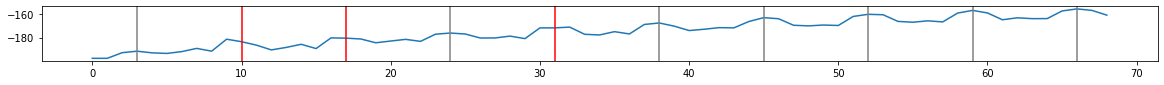

True

In [2023]:
layer0, head0 = 10, 1 #11-14  10-1
h_mask2 = torch.ones(hidden_size)
h_mask2[top_i[:]] = 0

attn_mask = torch.ones(H, seq_len, hidden_size // H)
# attn_mask[:, :] = 0
# attn_mask[8, :] = .1
m = get_attn_module(blocks[layer2])
outputs = forward(get_attn_module(blocks[layer0]), 'attn_mask', attn_mask, exit_module=blocks[layer2],
                 extra_tuples=[(m, 'return_attn_logits', True), #(m, 'hidden_states_mask', h_mask2),
#                                (get_attn_module(blocks[10]), 'hidden_states_mask', h_mask2),
                               (get_attn_module(blocks[layer1]), 'w', attentions[layer1])
                              ])

probs0 = outputs.attentions[layer1][0, head1, src, ans_positions[:-1]]
probs0, probs0.sum()
logits = globalize(outputs.attentions[layer2])[0, head2, src, : src + 1]
probs = logits[cand_positions].view(-1, n_candidates).softmax(-1)[:, task_name2idx[task_name]]
probs, probs.mean()
probs = logits.softmax(-1)[tgt_positions]
probs, probs.mean()
test(None, None, logits=logits)

tensor([[0.0066, 0.0076, 0.1356, 0.0835, 0.2636, 0.0631, 0.2177]],
       device='cuda:2')
tensor([0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143],
       device='cuda:2')
{'44 a': 0.3398, '42 ^': 0.2043, '43 Y': 0.1879, '38 I': 0.0659, '41 v': 0.0539}


{'Ġa': 0.3382, 'Ġv': 0.2697, 'ĠY': 0.0545, 'Ġu': 0.042, 'Ġy': 0.0365}

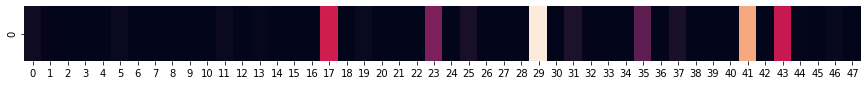

In [261]:
m = blocks[layer].attn.attention
mask = torch.ones(H, seq_len, seq_len)
# mask[:, src] = 0
mask[:] = 0
mask[head, src] = 0.1
_ = mask.requires_grad_(True)
# m.attn_mask = mask

# scaled_attn = attentions[layer] * mask.to(model.device)
# _ = scaled_attn.requires_grad_(True)
# m.w = scaled_attn
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
    attn = outputs.attentions[layer]
    _ = plt.figure(figsize=(15, 1))
    _ = sns.heatmap(numpy(attn[:, head, src, :]), cbar=False)
    print(attn[:, head, src, ans_positions[:-1]])
    
    attn[:] = 0
#     attn[0, head, src] = 0
    attn[0, head, src, ans_positions[:-1]] = 0.1 / len(ans_positions[:-1])
#     i = random.randint(0, attn.size(3) - 1); i
#     attn[0, head, src] = 0.1 / attn.size(3)
    print(attn[0, head, src, ans_positions[:-1]])
    m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     outputs = model(**inputs, output_attentions=True)
finally:
#     m.attn_mask = None
    m.w = None
# y = outputs.logits.softmax(-1)[:, src, pred_label]
# mask_grad = torch.autograd.grad(torch.unbind(y), mask)[0]
# attn_grad = torch.autograd.grad(torch.unbind(y), scaled_attn)[0]
    
attn = globalize(outputs.attentions[layer2])[0, head2, src]
print(show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions))
probs = outputs.logits[0, src].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [209]:
attn_grad[0, head - 2].mean()

tensor(0.0001, device='cuda:2')

In [169]:
attn_grad.size()
attn_grad2.size()
(attn_grad2[4:5] - attn_grad).abs().max()
attn_grad[0, head, src, ki]
attn_grad2[4, head, src, ki]

torch.Size([1, 20, 72, 72])

torch.Size([10, 20, 72, 72])

tensor(6.2585e-05, device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

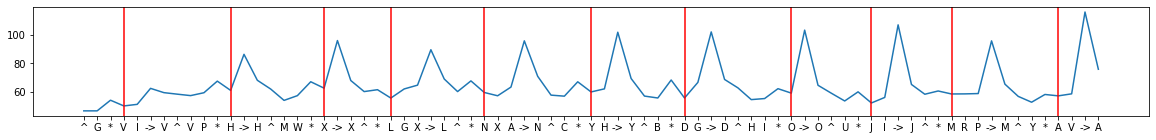

[0.017 0.002 0.011 0.    0.    0.001 0.    0.044 0.    0.088 0.13 ] 
 tensor(0.0266, grad_fn=<MeanBackward0>)


In [3504]:
qh = ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*1)[:, src:src+1]
kh = attn_hidden_states[layer2]
# kh = ln2(attn_outputs[9])
logits = (qh * kh).sum(dim=-1).squeeze(0)
_ = test(None, None, logits=logits, always_show=True)

In [11]:
texts = {
    'find lowercase': '''
X C e -> e
S f Z -> f
K y N -> y
q M N -> q
u S N -> u
S v Y -> v
v I J -> v
Y a N -> a''',
    'AbC->B': '''
X C e -> E
S f Z -> F
K y N -> Y
q M N -> Q
u S N -> U
S v Y -> V
g I J -> G
Y a N -> A
L n J -> N
d H I -> D
Z r C -> R
U S t -> T
K r A -> R
I G m -> M
t O X -> T''',  # failed, but GPT-3 can with low prob
    'set diff': '''
G L C, G L -> C
Y P J, Y P -> J
E S A, S A -> E
U P W, U P -> W
W Z A, W A -> Z
Z Q J, Z J -> Q
C Y L, Y L -> C
C K Z, C Z -> K
K O Q, O Q -> K
K O N, K N -> O
R U P, R P -> U
X C J, X C -> J
B G V, G V -> B
H V L, H V -> L
J K M, J M -> K
N W K, W K -> N
F B D, F B -> D''',
    'find majority': '''
n d d -> d
f f d -> f
e b e -> e
s q s -> s
d d o -> d
c e e -> e
g t g -> g
i i w -> i''', # basically failed
    'find special': '''
n d d -> n
f f d -> d
e b e -> b
s q s -> q
d d o -> o
c e e -> c
g g t -> t
w i i -> w''',  # failed, GPT-3 failed, too
    'find special2': '''
n d d d -> n
f f f d -> d
e b e e -> b
s s q s -> q
d d d o -> o
e c e e -> c
g g g t -> t
w i i i -> w''',  # failed, but GPT-3 can
    'ABC,AXC->X': '''
D O Q, K O Q -> K
K H N, K O N -> O
R X P, R U P -> U
X C G, X C J -> J
Z G V, B G V -> B
H V T, H V L -> L
J E M, J K M -> K
A W K, U W K -> U
F B Y, F B D -> D''',
    'reverse set diff': '''
O Q, K O Q -> K
K N, K O N -> O
R P, R U P -> U
X C, X C J -> J
G V, B G V -> B
H V, H V L -> L
J M, J K M -> K
W K, N W K -> N
F B, F B D -> D''',
    'set diff2': '''
Z Y, y -> z
K B, b -> k
N E, e -> n
J S, j -> s
O W, o -> w
F R, f -> r
J S, s -> j
N O, o -> n
P R, p -> r''',
    'find next': '''
W S D L, S -> D
F M W Q, F -> M
T W A V, A -> V
U V N M, N -> M
S D N O, S -> D
A S B T, S -> B
H W L Z, H -> W
C L J O, J -> O
T B A E, B -> A
L G C K, L -> G
G B S O, G -> B
K Y F O, F -> O
V Q U S, V -> Q
S E Y P, Y -> P
X D A U, A -> U
T L M N, L -> M
U O Y I, O -> Y''',  # failed, GPT-3 failed too
    'antonym': '''
big -> small
low -> high
fast -> slow
dark -> light
long -> short''',
}

In [ ]:
try:
#     with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     attn = outputs.attentions[layer]
#     print(attn[0, head, src, ans_positions[:-1]])
#     attn[0, head, src] = 0
#     attn[0, head, src, ans_positions[-8]] = 1
#     print(attn[0, head, src, ans_positions[:-1]])
#     m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    m.attn_mask = None
#     m.w = None

In [258]:
def norm(tensor): return round(tensor.abs().mean().item(), 4)
hidden_states.mean(), hidden_states.std()
for l in range(layer, layer2):
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].attn_output
    print(norm(h[l].attn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].ffn_output
    print(norm(h[l].ffn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())

(tensor(-0.7157, device='cuda:2'), tensor(17.1320, device='cuda:2'))

2.3035 0.7521 2.545 tensor(-0.7262, device='cuda:2') tensor(17.2453, device='cuda:2')
2.545 0.7547 2.7227 tensor(-0.7361, device='cuda:2') tensor(17.7049, device='cuda:2')
2.7227 0.7046 2.9372 tensor(-0.7366, device='cuda:2') tensor(17.8712, device='cuda:2')
2.9372 0.8032 3.1048 tensor(-0.7600, device='cuda:2') tensor(18.7369, device='cuda:2')
3.1048 0.8814 3.2894 tensor(-0.7694, device='cuda:2') tensor(18.9570, device='cuda:2')
3.2894 0.8759 3.2595 tensor(-0.7893, device='cuda:2') tensor(19.1697, device='cuda:2')


In [257]:
_hidden_states = h[layer2].ln_1(hidden_states)
try:
    with torch.no_grad(): _, attn = am2(am2_hidden_states, am2_attention_mask, output_attentions=True, q_hidden_states=_hidden_states)
finally: am2.q_hidden_states = None
attn = globalize(attn)
attn[0, head2, -1].topk(5)

torch.return_types.topk(
values=tensor([0.4904, 0.3162, 0.0501, 0.0432, 0.0416], device='cuda:2'),
indices=tensor([42, 43, 36, 44, 46], device='cuda:2'))

In [326]:
with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

for l in range(layer, layer + 1):
    mask_tgt_indices = [41, 35, 29, 23, 17, 11, 5]
    excluded_src_indices = [seq_len - 1] #if l == layer else []
    attn = outputs.attentions[l]
    if attn.dim() == 5:
        attn = attn[:, 0, :, :, -seq_len:] # (bsz, num_blokcs, H, seq_len, window_size + seq_len) -> (bsz, H, seq_len, seq_len)
#     for hd in range(H):
#         for src_idx in range(seq_len):
#             if hd != head and src_idx in excluded_src_indices:
#                 attn[:, hd, src_idx] = 0
    for hd in range(H):
        for src_idx in range(seq_len):
            for tgt_idx in range(seq_len):
                if hd == head and src_idx not in excluded_src_indices and tgt_idx in mask_tgt_indices:
                    attn[:, hd, src_idx, tgt_idx] = 0
    h[l].attn.attention.w = outputs.attentions[l]
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    for l in range(layer, layer2):
        h[l].attn.attention.w = None
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'44 E': 0.7865, '43 V': 0.1431, '38 K': 0.0355, '45 H': 0.0323, '37 A': 0.001}

{'ĠE': 0.8562, 'ĠH': 0.1216, 'ĠV': 0.0133, 'ĠD': 0.0009, 'ĠI': 0.0007}

{'28 ->': 0.6616,
 '40 ->': 0.3003,
 '22 ->': 0.0244,
 '34 ->': 0.013,
 '16 ->': 0.0003}

{'ĠT': 0.2914, 'ĠC': 0.1015, 'ĠL': 0.0839, 'ĠY': 0.0793, 'ĠE': 0.0643}

In [70]:
head_attrs = all_attrs['A B C D -> a'].sum(dim=(2, 3))
# head_attrs = attrs.sum(dim=(2, 3))

values, indices = head_attrs[:, :].view(-1).topk(10)
indices = unravel_index(indices, head_attrs.size())
top_heads = [(l, h, round(v, 8)) for l, h, v in zip(
    indices[0].tolist(), indices[1].tolist(), values.tolist())]
top_heads

[(17, 1, 1.08707237),
 (19, 21, 1.00648546),
 (21, 13, 0.78149551),
 (17, 10, 0.68284625),
 (17, 15, 0.63359404),
 (18, 18, 0.62241864),
 (22, 15, 0.52263898),
 (20, 5, 0.45230082),
 (19, 17, 0.36873266),
 (21, 4, 0.33636701)]

In [26]:
inputs = tokenizer.encode_plus(_text, return_tensors='pt')
outputs = model(**inputs, output_attentions=True)

logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
y = logits[0, -1].max()
attentions = outputs.attentions if hasattr(outputs, 'attentions') else outputs[-1]
for a in attentions: a.retain_grad()
model.zero_grad()
y.backward()

# attns = torch.cat(attentions)
grads = torch.cat([a.grad for a in attentions])
attrs2 = attns * grads

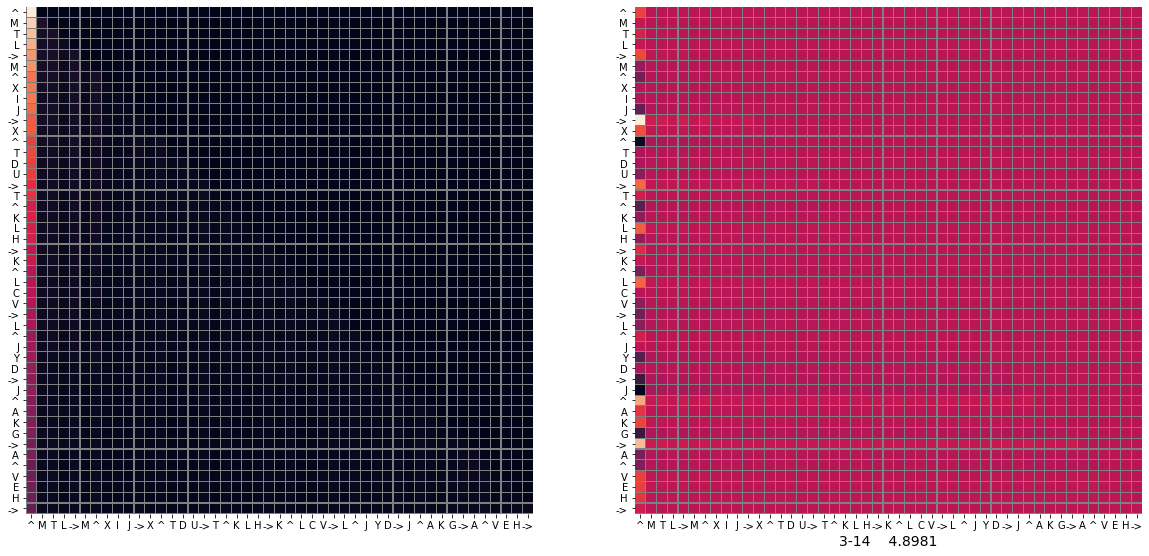

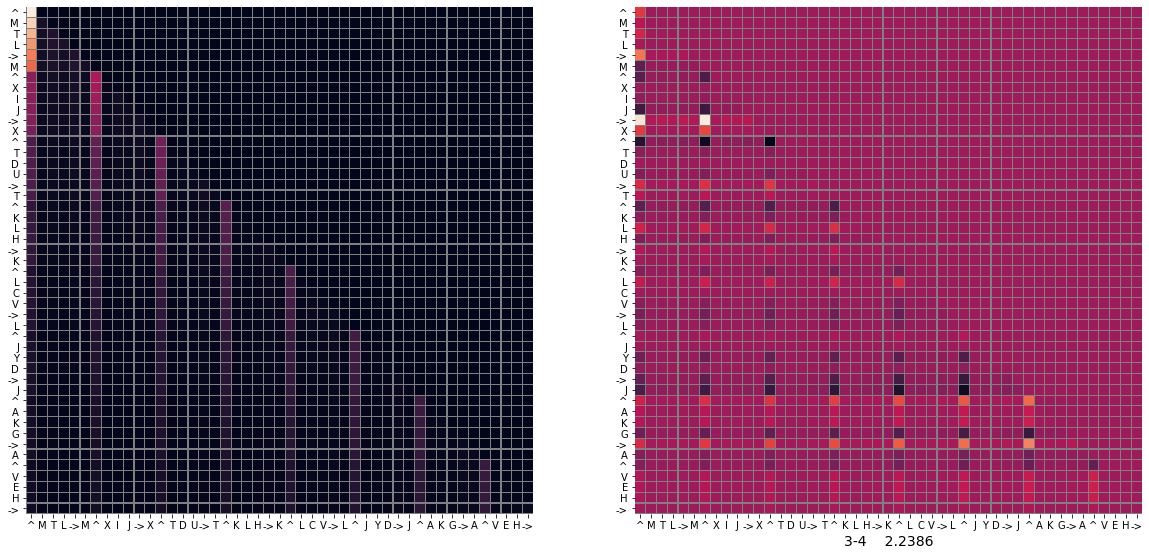

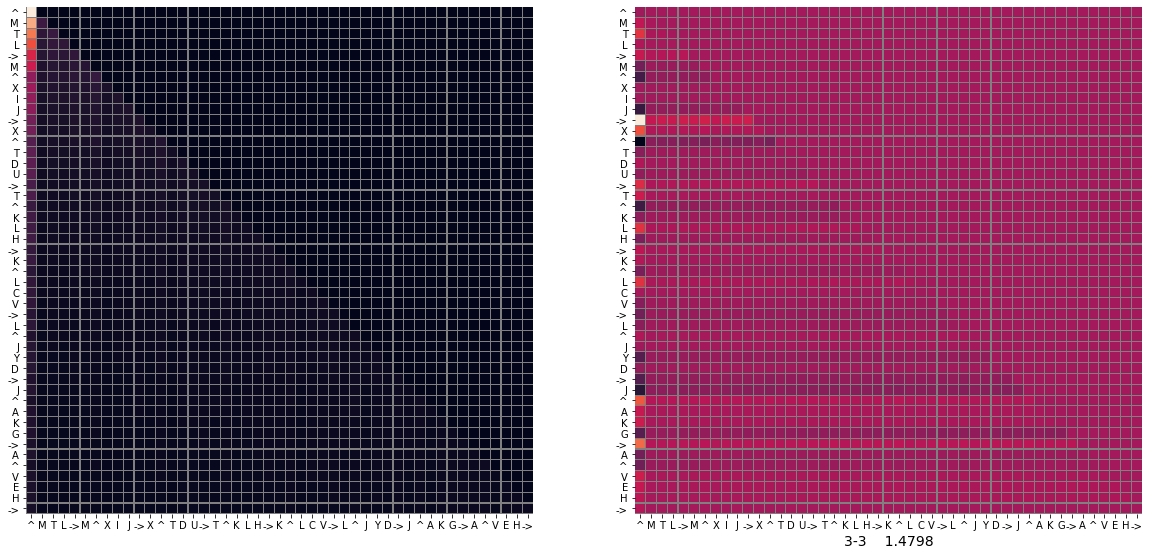

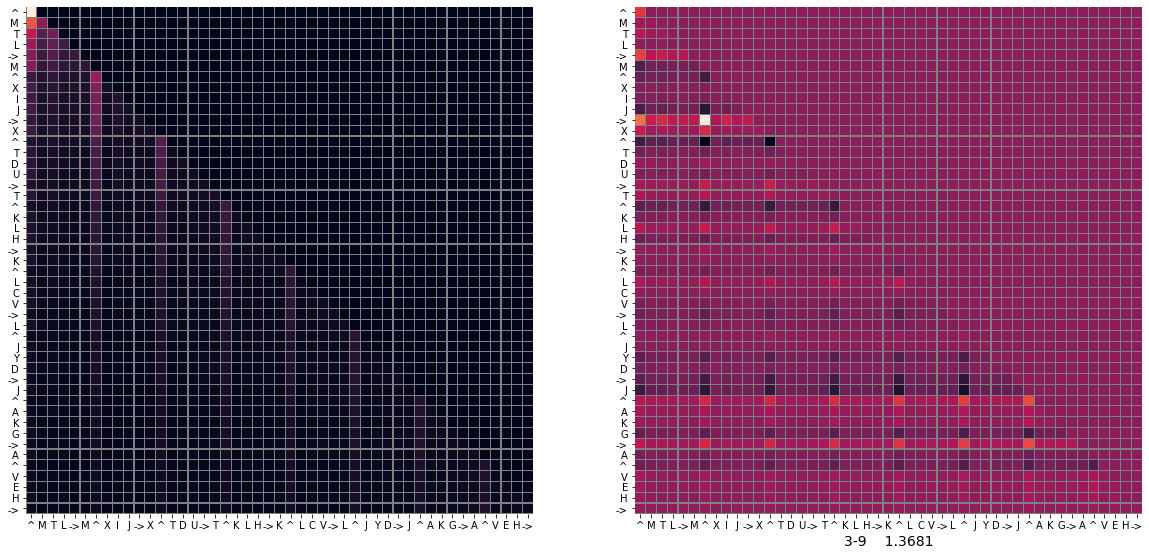

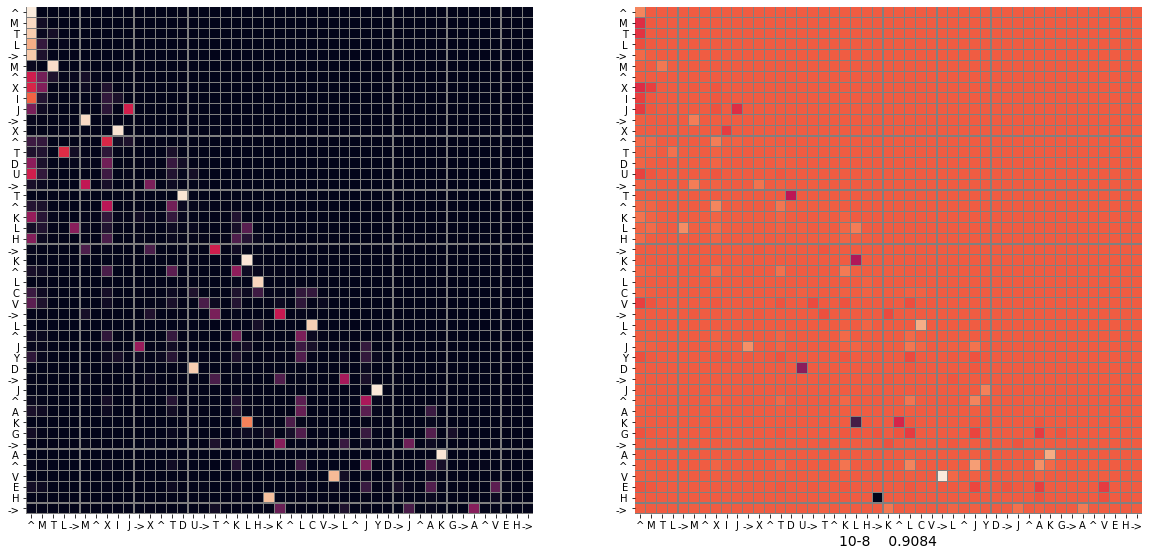

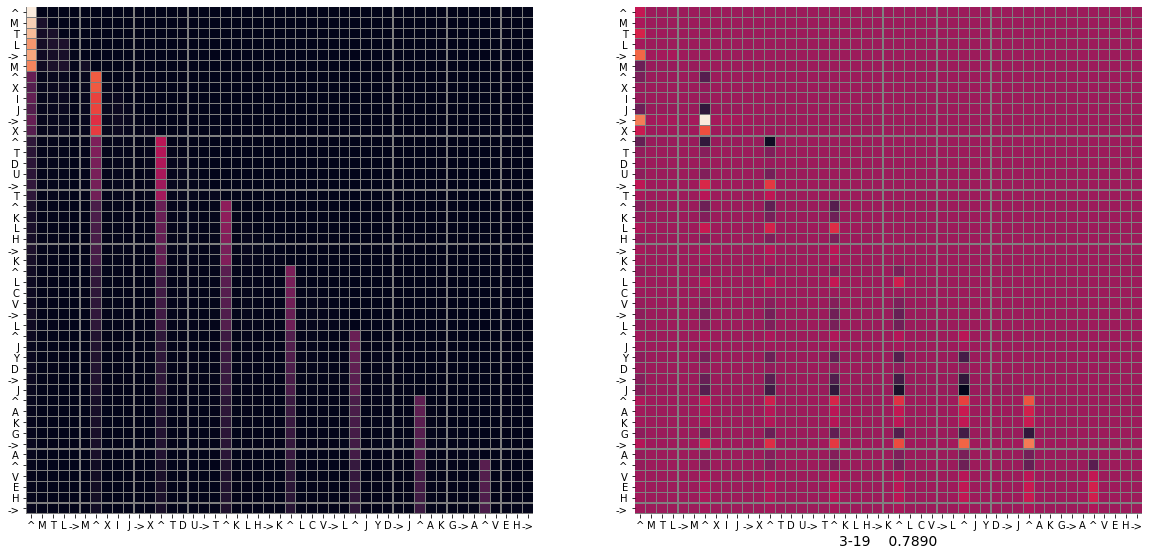

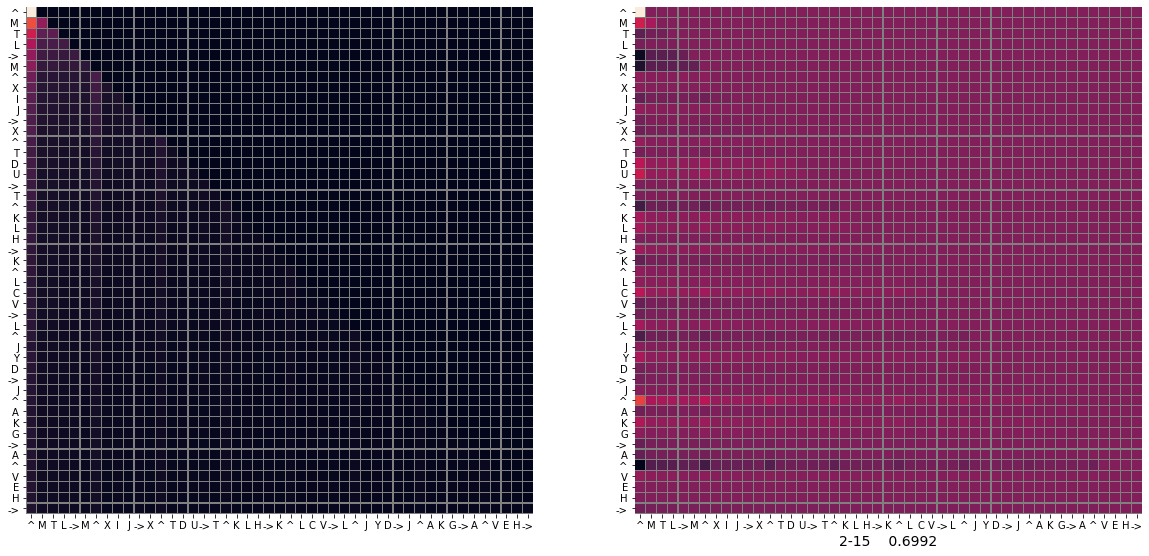

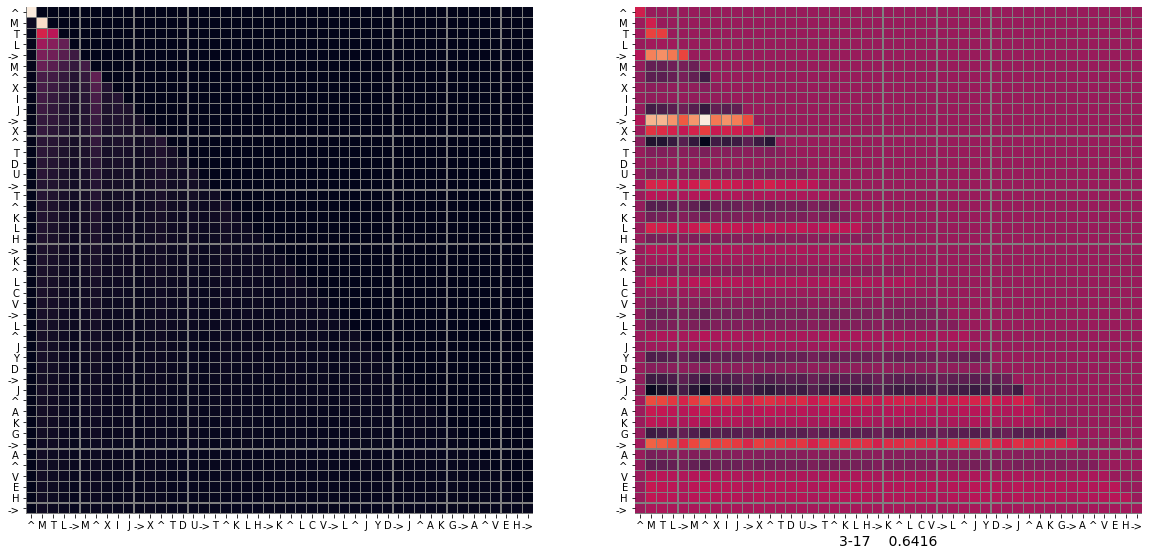

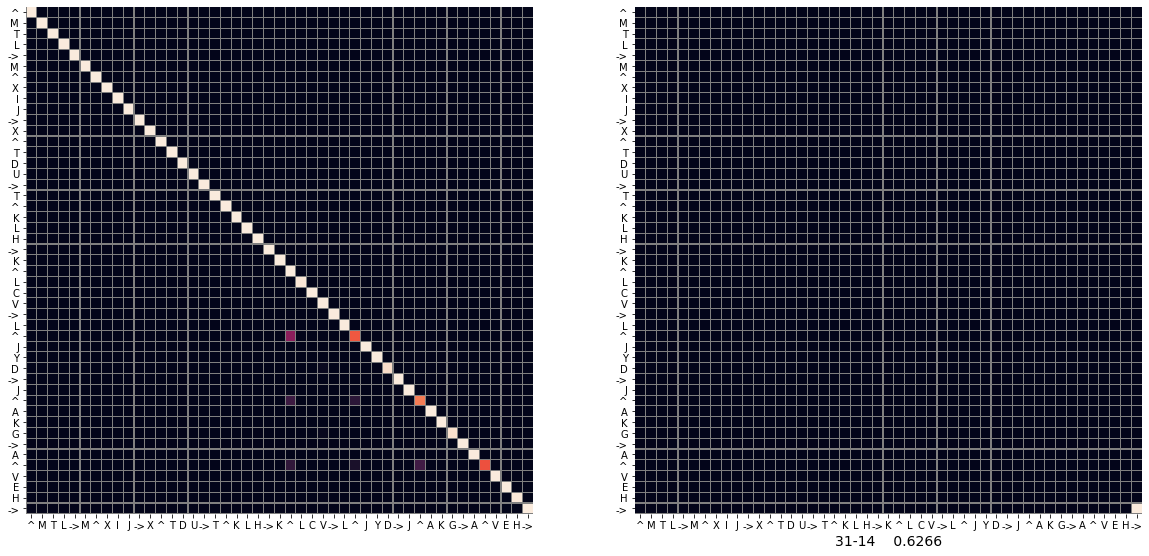

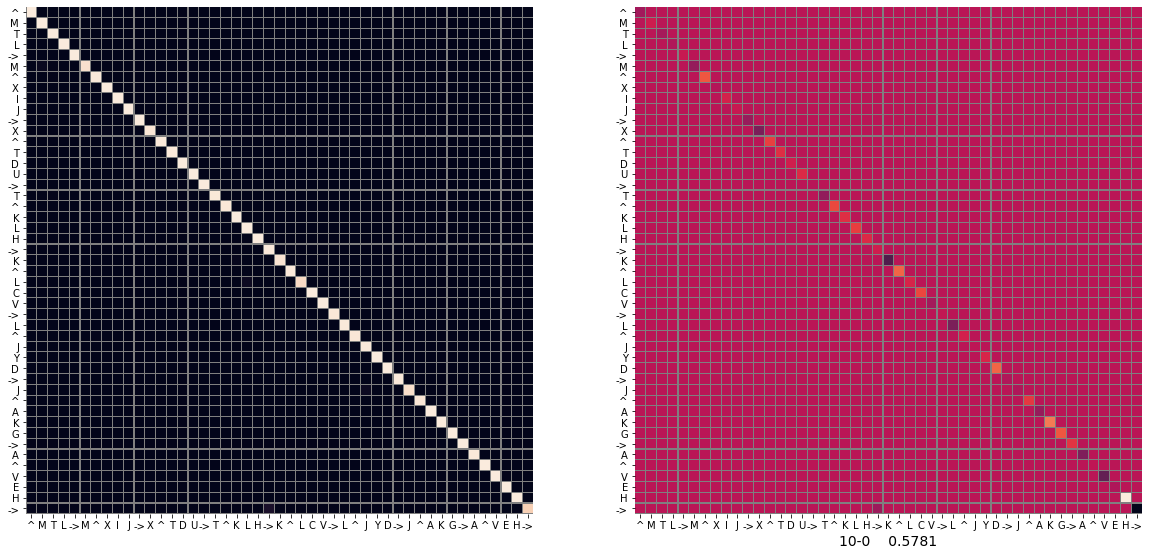

In [259]:
for i in range(len(top_heads)):
    layer, head, v, _ = top_heads[i]
    if layer in [0, 1, ]: continue
#     layer, head, v = 30, 10, 1.
    fig, axs = plt.subplots(1,2,sharey=False, figsize=(10 * 2, 10))
    for i, (a, _ax) in enumerate(zip([attns, attrs], axs)):
        a = a[layer][head].detach().cpu()
        a, annot = ((a * 100).long(), True) if i == -1 else (a, False)
        res = sns.heatmap(a, square=True, cbar=False, annot=annot, fmt='d', linewidths=0.1, linecolor='grey', 
                          xticklabels=tokens, yticklabels=tokens, ax=_ax)
        _ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = plt.xlabel('%d-%d    %.4f' % (layer, head, v), fontsize=14)

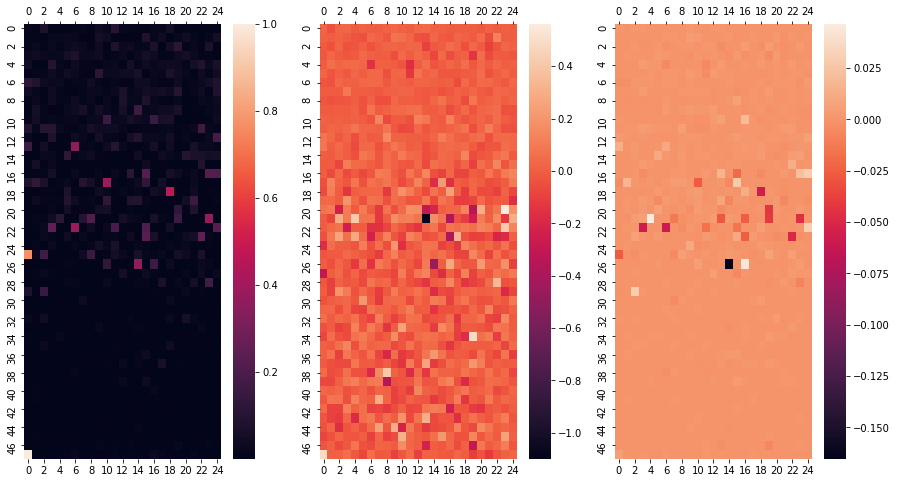

In [555]:
n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(5 * n_cols, 2 * 4 * n_rows))
A = [attns, grads, attrs]

for row in range(n_rows):
    for col in range(n_cols):
        ax = axs[row][col] if row > 1 else axs[col]
        a = A[col][:, :, src,tgt].detach()
        if col == 0: a[-1, 0] = 1.
#         fig = plt.subplots(1,1,sharey=False, figsize=(5 , 8))
        ax = sns.heatmap(a, ax=ax)
        ax.tick_params(top=True, labeltop=True)

In [383]:
logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
values, indices = logits[0, -1].softmax(dim=-1).topk(5)
list(zip(tokenizer.convert_ids_to_tokens(indices), values.tolist()))

In [132]:
input_ids = tokenizer.encode_plus(_text)['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

input_ids = input_ids[: -3] + input_ids[-2:]
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '▁', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1>.</s>
['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1> welcome.</s>


In [342]:
texts = [
    'Big is to small as fast is to _',
    'Bread is to eat as gun is to _',
    'big: small, fast: _',
    'bread: eat, gun: _ .',
    'flower: fragrant, fire: hot, bread: delicious, gun: _ ',
    'Big and small are _ .',
    'What is twice 3? _.',
    'What is the half 6? _.',
    'There is a sequence: 3, 5, 2, 7. The number immediately precedes 5 is _.',  # :)
    'There is a sequence: 3, 5, 2, 7. The number immediately follows 5 is _.',  # :(
    'There is a sequence: 3, 5, 2, 7. The number between 5 and 7 is _.',
    'There is a sequence of numbers: 3, 5, 2, 4. _ is the first number.',
    'There is a sequence of numbers: 3, 5, 2. The reversed sequence is _.',
    '''There is a sequence of numbers: 5, 1, 6, 3. The second number is 1.
There is a sequence of numbers: 3, 7, 2, 4. The second number is _.''',
    '''There is a sequence of letters: e, c, b, a. The last letter is a.
There is a sequence of letters: f, d, b, g. The last letter is _.''',
    '''The uppercase of c is C. The uppercase of f is _.''',
    '''The successor of 3 is 4. The successor of 8 is _.''',
    '''The successor of 3 is 4. The successor of _ is 6.''',
#     '''The predecessor of 3 is 2. The predecessor of 5 is 4. The predecessor of 6 is _''',
#     '''The previous integer of 4 is 3. The previous integer of 3 is _.''',
#     '''3 minus 1 equals 2. 5 minus 1 equals _.''',
    '''If 2 changes to 3, 5 changes to 6, then _ changes to 9''',
    '''If 2 changes to 20, 3 changes to 30, then 5 changes to _''',
    '''2 -> 3, 4 -> 5, 5 -> 6, 9 -> _.''',
    '''3 -> 2, 5 -> 4, 6 -> 5, 9 -> _''',
    '''9 -> 8, 7 -> 6, 6 -> 5, 2 -> _.''',
    '''3 is to _ as 4 is to 8 and 5 is to 10.''',
#     '''6 : _ :: 5 : 10 :: 7 : 14 :: 8 : 16.''',
#     '''a is to _ as f is to g, h to i, i to j, s to t.''',
#     '''c is to _ as f is to e, h to g, j to i.''',
    '''c is to _ as j is to i, h to g, f to e.''',
#     '''Twice 3 is 6, twice 4 is _.''',
#     '''Half of 4 is 2, half of 6 is _.''',

# '''Shall I compare thee to a summer's day?
# Thou''',
# '''Do not go gentle into that good night,
# Old age should burn and rave at close of day;
# Rage'''
]